In [1]:
%%html
<script>
    // AUTORUN ALL CELLS ON NOTEBOOK-LOAD!
    require(
        ['base/js/namespace', 'jquery'], 
        function(jupyter, $) {
            $(jupyter.events).on("kernel_ready.Kernel", function () {
                console.log("Auto-running all cells-below...");
                jupyter.actions.call('jupyter-notebook:run-all-cells-below');
                jupyter.actions.call('jupyter-notebook:save-notebook');
            });
        }
    );
</script>

In [2]:
from IPython.display import HTML, Javascript, display
from ipywidgets import widgets

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle();"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [4]:
%%capture
cd ..

In [5]:
%load_ext autoreload
%autoreload 2

import dill
import matplotlib.pyplot as plt

from dreamcoder.domains.list.handwrittenProperties import handWrittenProperties, getHandwrittenPropertiesFromTemplates
from dreamcoder.domains.list.makeListTasks import joshTasks
from dreamcoder.domains.list.propSim import getPropertySimTasksMatrix, getPriorDistributionsOfProperties, createSimilarTasksDf


# Load relevant tasks, properties and helmholtz frontiers
tasks = joshTasks("final")
properties = getHandwrittenPropertiesFromTemplates(tasks, filterEquivalent=False)
fileName = "data/prop_sig/helmholtz_frontiers/josh_rich_enumerated_1/enumerated_0_10000.pkl"
helmholtzFrontiers = dill.load(open(fileName, "rb"))[:100]
valuesToInt = {"allFalse":0, "allTrue":1, "mixed":2}

# Compute prior probabilities (over tasks) for property values
taskPropertyMatrix = getPropertySimTasksMatrix(tasks, properties, valuesToInt)
helmholtzTasksPropertyMatrix = getPropertySimTasksMatrix([f.task for f in helmholtzFrontiers], properties, valuesToInt)
propertyToPriorDistribution = getPriorDistributionsOfProperties(properties, taskPropertyMatrix, valuesToInt)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
taskDropdown = widgets.Dropdown(
    options=[t.name for t in tasks],
    value=tasks[0].name,
    description='Task:',
    disabled=False,
)

def run_all(ev):
    display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1,IPython.notebook.get_selected_index()+2)'))
taskDropdown.observe(run_all, names="value")

display(taskDropdown)

In [ ]:
def getTaskIdx(taskName, tasks):
    taskIdx = [i for i,t in enumerate(tasks) if t.name == taskName]
    assert len(taskIdx) == 1
    return taskIdx[0]

taskIdx = getTaskIdx(taskDropdown.value, tasks)

001_1 : list(int) -> list(int)
f([2, 67, 32, 46, 12]) = [11, 19, 24, 33, 42, 5, 82, 0, 64, 9]
f([77, 51, 8, 27, 39, 7, 4, 92, 2, 71]) = [11, 19, 24, 33, 42, 5, 82, 0, 64, 9]
f([36, 86, 78, 66, 6, 1, 70, 72]) = [11, 19, 24, 33, 42, 5, 82, 0, 64, 9]
f([37, 47, 3, 74, 20, 20, 3]) = [11, 19, 24, 33, 42, 5, 82, 0, 64, 9]
f([31, 80, 97, 98, 85, 60]) = [11, 19, 24, 33, 42, 5, 82, 0, 64, 9]
f([73, 52, 34, 41]) = [11, 19, 24, 33, 42, 5, 82, 0, 64, 9]
f([16, 69, 25]) = [11, 19, 24, 33, 42, 5, 82, 0, 64, 9]
f([29]) = [11, 19, 24, 33, 42, 5, 82, 0, 64, 9]
f([]) = [11, 19, 24, 33, 42, 5, 82, 0, 64, 9]
f([59, 26]) = [11, 19, 24, 33, 42, 5, 82, 0, 64, 9]
f([18, 8, 58, 92, 4, 6, 62, 47, 30]) = [11, 19, 24, 33, 42, 5, 82, 0, 64, 9]


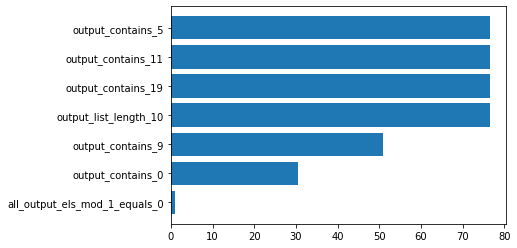

002_1 : list(int) -> list(int)
f([4, 72, 68, 63, 97]) = [4, 72, 68, 63, 97]
f([79, 50, 92, 5, 8, 91, 27, 2, 43]) = [79, 50, 92, 5, 8, 91, 27, 2, 43]
f([26, 86, 51]) = [26, 86, 51]
f([0, 75, 58, 55]) = [0, 75, 58, 55]
f([36, 57, 94, 1, 87, 38]) = [36, 57, 94, 1, 87, 38]
f([74, 9, 6, 53, 88, 10]) = [74, 9, 6, 53, 88, 10]
f([]) = []
f([39, 32, 93]) = [39, 32, 93]
f([60, 17, 3, 59, 96]) = [60, 17, 3, 59, 96]
f([54, 73]) = [54, 73]
f([85]) = [85]


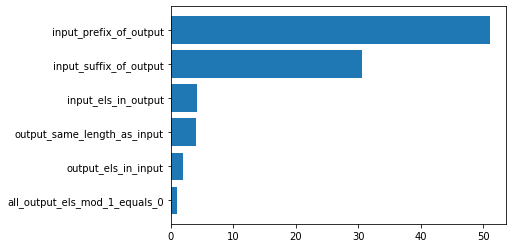

003_1 : list(int) -> list(int)
f([38, 51, 18, 72, 13]) = [5]
f([]) = [0]
f([83]) = [1]
f([73, 91, 96, 60, 61, 42, 2, 6, 33]) = [9]
f([90, 93, 81, 3, 57, 69, 21]) = [7]
f([33, 59, 44, 48]) = [4]
f([80, 54, 14, 74, 14, 74]) = [6]
f([9, 2, 27, 28, 41, 40, 31, 52]) = [8]
f([64, 39]) = [2]
f([63, 36, 7, 24, 4, 35, 0, 45, 47, 43]) = [10]
f([97, 88, 65]) = [3]


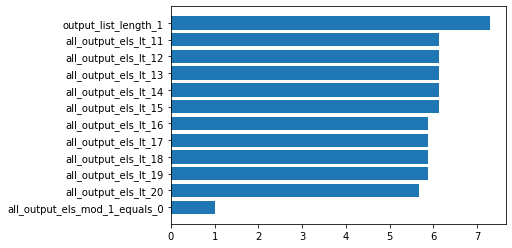

004_1 : list(int) -> list(int)
f([5, 26, 31, 76, 89]) = [89]
f([9, 42, 54, 18, 83, 7, 34]) = [83]
f([4, 24, 58, 93, 28, 60, 2, 0, 22, 8]) = [93]
f([48, 47]) = [48]
f([63, 46, 6]) = [63]
f([29, 64, 7, 57]) = [64]
f([43, 33, 88, 30, 20, 47, 44, 87]) = [88]
f([17, 56, 36, 8, 3, 80, 73, 41, 38]) = [80]
f([1, 53, 12]) = [53]
f([79, 19, 45, 82, 25, 23]) = [82]
f([84, 51]) = [84]


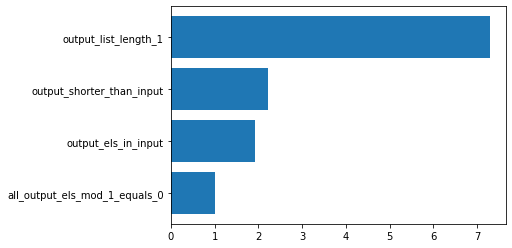

005_1 : list(int) -> list(int)
f([31, 40, 16, 44, 73]) = [31, 40, 16, 44, 40, 16, 44, 73]
f([5, 1, 10, 24]) = [5, 1, 10, 1, 10, 24]
f([26, 25, 85, 7, 94, 46]) = [26, 25, 85, 7, 94, 25, 85, 7, 94, 46]
f([45, 62, 96, 4, 79, 57]) = [45, 62, 96, 4, 79, 62, 96, 4, 79, 57]
f([6, 35, 75]) = [6, 35, 35, 75]
f([52, 41, 8, 17]) = [52, 41, 8, 41, 8, 17]
f([74, 56, 19, 34, 3]) = [74, 56, 19, 34, 56, 19, 34, 3]
f([38, 83, 89]) = [38, 83, 83, 89]
f([78, 72, 90, 36, 78]) = [78, 72, 90, 36, 72, 90, 36, 78]
f([21, 64, 11, 59]) = [21, 64, 11, 64, 11, 59]
f([28, 54, 2, 71, 51, 7]) = [28, 54, 2, 71, 51, 54, 2, 71, 51, 7]


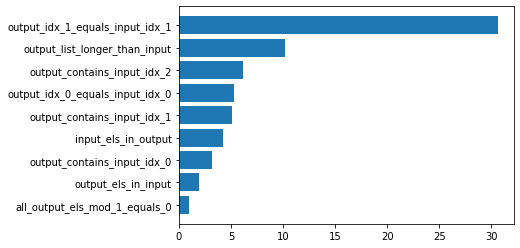

006_1 : list(int) -> list(int)
f([36, 86, 2, 97, 10]) = [2, 10, 36, 86, 97]
f([50, 94, 0, 83, 77, 71, 5, 3, 57, 8]) = [0, 3, 5, 8, 50, 57, 71, 77, 83, 94]
f([85, 26, 7, 23, 48, 39]) = [7, 23, 26, 39, 48, 85]
f([89, 4, 21, 35, 78, 96, 11, 90, 47]) = [4, 11, 21, 35, 47, 78, 89, 90, 96]
f([68, 1, 44, 93]) = [1, 44, 68, 93]
f([66, 9, 7, 30, 62]) = [7, 9, 30, 62, 66]
f([49, 2, 6, 81]) = [2, 6, 49, 81]
f([91, 98, 51, 1, 55]) = [1, 51, 55, 91, 98]
f([28, 59, 74, 37, 83, 1, 38, 18]) = [1, 18, 28, 37, 38, 59, 74, 83]
f([75, 13, 48, 89, 33, 87]) = [13, 33, 48, 75, 87, 89]
f([60, 43, 32, 67]) = [32, 43, 60, 67]


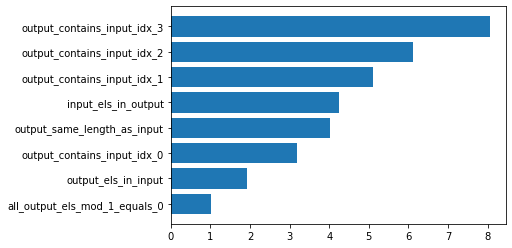

007_1 : list(int) -> list(int)
f([87, 87, 17, 17, 17, 87]) = [87, 17]
f([3, 92, 18, 6, 49, 49, 1, 38, 80]) = [3, 92, 18, 6, 49, 1, 38, 80]
f([68, 68, 68, 68, 68, 68, 68, 68, 68, 68]) = [68]
f([89, 89, 89, 36, 55, 14, 7, 14]) = [89, 36, 55, 14, 7]
f([81, 69, 85, 81, 69, 74, 0, 24, 74, 61]) = [81, 69, 85, 74, 0, 24, 61]
f([27, 12, 34, 73, 23, 34, 64, 23]) = [27, 12, 34, 73, 23, 64]
f([]) = []
f([75, 94, 9, 75, 9, 94, 75, 9, 2, 2]) = [75, 94, 9, 2]
f([22, 22, 22, 22, 22, 22, 22, 22, 22]) = [22]
f([48, 21, 4, 4, 21, 21, 48, 4, 48, 48]) = [48, 21, 4]
f([91, 63, 63, 91, 63, 91, 63]) = [91, 63]


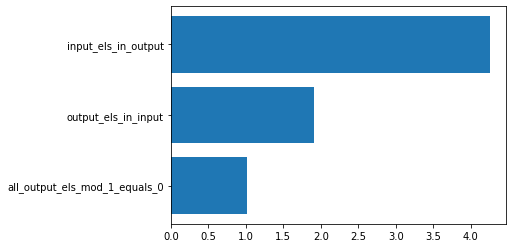

008_1 : list(int) -> list(int)
f([9, 6, 15, 3, 43]) = [76]
f([]) = [0]
f([12, 15, 7, 10, 8, 29]) = [81]
f([39, 23, 34]) = [96]
f([24, 46]) = [70]
f([3, 20, 40, 22]) = [85]
f([28, 28, 5, 6, 9, 11, 2, 0]) = [89]
f([9, 21, 37, 6, 8, 6, 4]) = [91]
f([67]) = [67]
f([8, 14, 2, 47, 0, 2, 8, 6, 6, 5]) = [98]
f([1, 6, 4, 32, 1, 17, 1, 4, 7]) = [73]


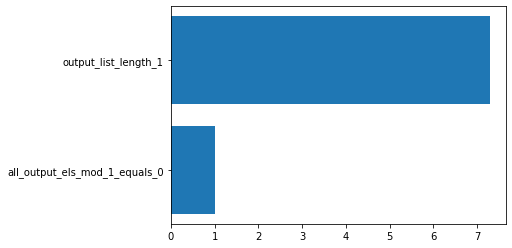

009_1 : list(int) -> list(int)
f([5, 1, 1, 1, 3]) = [15]
f([6, 6]) = [36]
f([]) = [1]
f([4, 3, 2, 3]) = [72]
f([7, 14, 1]) = [98]
f([48]) = [48]
f([3, 1, 1, 1, 3, 1, 1, 3]) = [27]
f([1, 1, 5, 1, 5, 1, 1]) = [25]
f([2, 2, 2, 2, 2, 2]) = [64]
f([2, 2, 2, 2, 1, 1, 1, 1, 1]) = [16]
f([42, 83, 91, 77, 13, 77, 36, 42, 9, 0]) = [0]


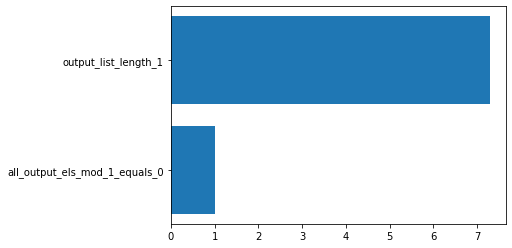

010_1 : list(int) -> list(int)
f([97, 7, 13, 2, 55]) = [13, 55, 97]
f([18, 35, 7, 70, 96, 74, 37, 45]) = [70, 74, 96]
f([45, 92, 5, 40, 3, 78, 81, 50, 4, 76]) = [78, 81, 92]
f([85, 89, 8, 7, 9, 44, 30, 68, 69]) = [69, 85, 89]
f([57, 15, 51, 31, 33, 61, 6]) = [51, 57, 61]
f([95, 21, 5, 1, 53, 24]) = [24, 53, 95]
f([1, 9, 88, 8, 64, 30, 6, 87]) = [64, 87, 88]
f([80, 22, 7, 4, 47, 5, 39]) = [39, 47, 80]
f([34, 16, 0, 3]) = [3, 16, 34]
f([59, 72, 98, 6, 20, 0, 58, 3, 25, 56]) = [59, 72, 98]
f([94, 83, 9, 54, 12, 4, 28, 49, 6]) = [54, 83, 94]


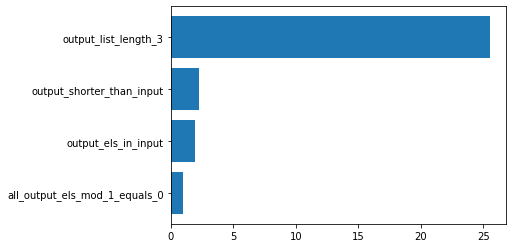

011_1 : list(int) -> list(int)
f([38, 76, 18, 31, 5]) = [76, 76, 76, 76, 76]
f([90, 28, 72, 2, 5, 94, 85, 88, 68]) = [94, 94]
f([52, 75, 83, 30, 3, 93]) = [93, 93, 93]
f([1, 82, 56, 49, 1, 60, 60, 90]) = [90]
f([0, 24, 65]) = []
f([67, 6]) = [67, 67, 67, 67, 67, 67]
f([8]) = [8, 8, 8, 8, 8, 8, 8, 8]
f([71, 68, 30, 9]) = [71, 71, 71, 71, 71, 71, 71, 71, 71]
f([33, 11, 74, 26, 66, 7, 62, 55, 9]) = [74, 74, 74, 74, 74, 74, 74]
f([34, 5, 34, 6, 4, 54, 47]) = [54, 54, 54, 54]
f([70, 36, 73, 10, 44, 13, 43, 18, 37, 12]) = [73, 73, 73, 73, 73, 73, 73, 73, 73, 73]


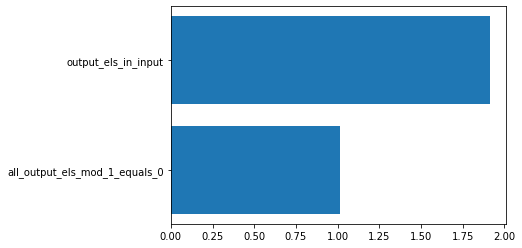

012_1 : list(int) -> list(int)
f([25, 0, 22, 48, 7]) = [1, 2, 3, 4, 5, 6, 7]
f([2, 66, 71, 42, 29, 99, 95, 81, 19, 3]) = [1, 2, 3]
f([5, 26, 75, 4, 97, 32, 73, 59, 1]) = [1]
f([9, 10]) = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
f([76, 61, 15, 74, 77, 6, 2]) = [1, 2]
f([8, 48, 89, 0, 35, 69, 84, 9]) = [1, 2, 3, 4, 5, 6, 7, 8, 9]
f([30, 7, 65, 62, 8]) = [1, 2, 3, 4, 5, 6, 7, 8]
f([82, 8, 5]) = [1, 2, 3, 4, 5]
f([27, 37, 63, 4, 0, 15]) = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
f([6]) = [1, 2, 3, 4, 5, 6]
f([42, 32, 37, 4]) = [1, 2, 3, 4]


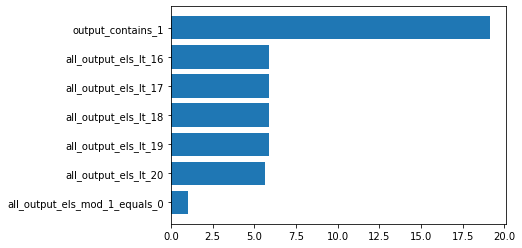

013_1 : list(int) -> list(int)
f([3, 91, 59, 91, 60, 6, 44, 2]) = [91, 91, 60, 2]
f([7, 35, 37, 74, 73, 22, 85, 8, 68, 7]) = [35, 74, 73, 22, 85]
f([7, 38, 1, 29, 40, 48, 45, 81]) = [1, 40, 45, 81]
f([2, 93, 68, 36, 41, 8, 27, 20, 8, 50]) = [41, 20, 50]
f([4, 82, 5, 52, 83, 7, 5, 4, 9]) = [82, 52, 83]
f([6, 72, 72, 8, 4, 8, 96, 58]) = [72, 72, 4]
f([8, 79, 79, 28, 19, 4, 34, 4, 1]) = [4, 34, 4, 1]
f([3, 1, 11, 89, 92, 88, 6, 40, 2, 39]) = [1, 11, 92, 40, 2]
f([2, 84, 84, 24, 84, 0, 71, 4, 71]) = [0, 71, 71]
f([4, 30, 8, 81, 4, 33, 68, 63, 53, 5]) = [30, 81, 33, 63, 53]
f([5, 24, 49, 41, 49, 0, 2, 59]) = [24, 41, 0, 2]


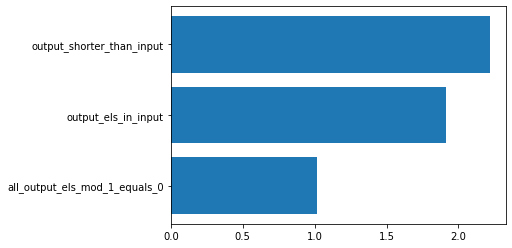

014_1 : list(int) -> list(int)
f([86, 84, 60, 20, 21]) = [21, 86, 84, 60, 20, 21]
f([10, 4, 51, 57]) = [57, 10, 4, 51, 57]
f([67, 72]) = [72, 67, 72]
f([35, 49, 2, 45, 46, 92, 9, 6, 58]) = [58, 35, 49, 2, 45, 46, 92, 9, 6, 58]
f([55, 5, 56]) = [56, 55, 5, 56]
f([43, 0, 18, 36, 1]) = [1, 43, 0, 18, 36, 1]
f([25, 39, 40]) = [40, 25, 39, 40]
f([74, 64, 95, 90]) = [90, 74, 64, 95, 90]
f([22, 3, 92, 8, 70, 34, 23, 71]) = [71, 22, 3, 92, 8, 70, 34, 23, 71]
f([24, 13]) = [13, 24, 13]
f([93, 80, 63, 82, 94]) = [94, 93, 80, 63, 82, 94]


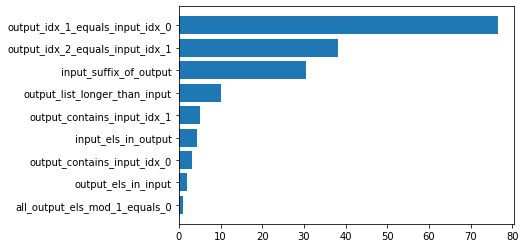

015_1 : list(int) -> list(int)
f([7, 17, 45, 17, 12]) = [81, 7, 17, 45, 12, 81]
f([4, 4, 31, 38, 38, 31, 38, 38]) = [73, 4, 31, 38, 73]
f([24, 3, 24, 1, 3, 2, 42, 2, 1, 42]) = [72, 24, 3, 1, 2, 42, 72]
f([27, 14, 14, 14, 14, 27, 27, 27, 27]) = [41, 27, 14, 41]
f([]) = [0, 0]
f([11, 11, 11, 52, 11, 11, 52, 52, 11, 52]) = [63, 11, 52, 63]
f([85, 85, 5, 5, 5, 85]) = [90, 85, 5, 90]
f([26, 26, 2, 50, 2, 50, 26, 26, 50]) = [78, 26, 2, 50, 78]
f([5, 8, 23, 8, 5, 23, 3]) = [39, 5, 8, 23, 3, 39]
f([99, 99, 99, 99, 99, 99, 99, 99, 99, 99]) = [99, 99, 99]
f([16, 9, 16, 9]) = [25, 16, 9, 25]


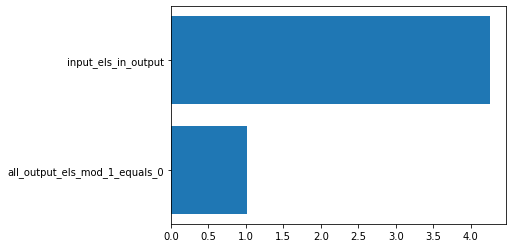

016_1 : list(int) -> list(int)
f([52, 72, 4, 18, 70]) = [70, 18, 4, 72, 52, 72, 4, 18, 70]
f([48, 47, 27]) = [27, 47, 48, 47, 27]
f([67, 23, 25, 54]) = [54, 25, 23, 67, 23, 25, 54]
f([31, 2, 68, 11, 5, 65, 81, 28]) = [28, 81, 65, 5, 11, 68, 2, 31, 2, 68, 11, 5, 65, 81, 28]
f([64, 66]) = [66, 64, 66]
f([]) = []
f([89, 37, 10, 36]) = [36, 10, 37, 89, 37, 10, 36]
f([80, 16, 69, 92, 15, 96, 8]) = [8, 96, 15, 92, 69, 16, 80, 16, 69, 92, 15, 96, 8]
f([3, 21, 35]) = [35, 21, 3, 21, 35]
f([71]) = [71]
f([9, 0, 1, 55, 91]) = [91, 55, 1, 0, 9, 0, 1, 55, 91]


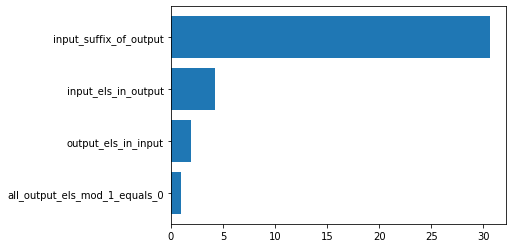

017_1 : list(int) -> list(int)
f([77, 90, 44, 9, 84]) = [9, 84, 77, 90, 44]
f([57, 0, 17, 95, 1, 94, 68, 31, 46]) = [95, 1, 94, 68, 31, 46, 57, 0, 17]
f([20, 6, 21, 56, 79, 8]) = [56, 79, 8, 20, 6, 21]
f([23, 5, 42, 7, 52, 74, 25]) = [7, 52, 74, 25, 23, 5, 42]
f([2, 81, 92, 80]) = [80, 2, 81, 92]
f([29, 8, 30, 18, 3, 5, 37, 67, 43, 13]) = [18, 3, 5, 37, 67, 43, 13, 29, 8, 30]
f([82, 49, 14]) = [82, 49, 14]
f([3, 12, 97, 36, 33, 2, 16]) = [36, 33, 2, 16, 3, 12, 97]
f([70, 38, 40, 39, 6, 83]) = [39, 6, 83, 70, 38, 40]
f([24, 1, 47, 61, 88]) = [61, 88, 24, 1, 47]
f([0, 62, 76, 59]) = [59, 0, 62, 76]


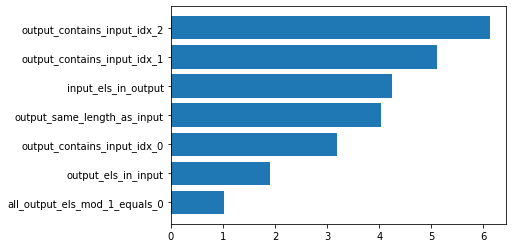

018_1 : list(int) -> list(int)
f([24, 8, 57, 44, 4]) = [4, 24, 8, 57, 44]
f([97, 28, 30, 5, 48, 7, 2, 76, 9, 1]) = [28, 30, 5, 48, 7, 2, 76, 9, 1, 97]
f([18, 96, 25, 71, 99, 1]) = [96, 25, 71, 99, 1, 18]
f([39, 85, 2]) = [2, 39, 85]
f([5, 6, 22, 44, 90, 11, 3]) = [44, 90, 11, 3, 5, 6, 22]
f([45, 7, 18, 0, 87, 5]) = [5, 45, 7, 18, 0, 87]
f([9, 46, 1, 2, 91, 8, 6]) = [6, 9, 46, 1, 2, 91, 8]
f([3, 55, 2, 14, 5, 68, 0]) = [3, 55, 2, 14, 5, 68, 0]
f([3, 77, 17, 4, 1, 44, 55, 19, 7]) = [19, 7, 3, 77, 17, 4, 1, 44, 55]
f([42, 61, 8, 69, 13, 0]) = [42, 61, 8, 69, 13, 0]
f([30, 22, 7, 1]) = [22, 7, 1, 30]


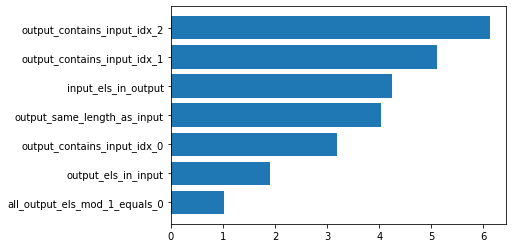

019_1 : list(int) -> list(int)
f([8, 87, 23, 25, 34]) = [8, 87, 23, 25, 34, 8]
f([63]) = [8, 63, 8]
f([47, 68, 84, 8]) = [8, 47, 68, 84, 8]
f([46, 77]) = [8, 46, 77, 8]
f([52, 7, 2, 91, 5, 75, 58, 3, 8]) = [8, 52, 7, 2, 91, 5, 75, 58, 3, 8]
f([8]) = [8]
f([12, 71, 59, 1, 6, 55, 8]) = [8, 12, 71, 59, 1, 6, 55, 8]
f([8, 39, 26]) = [8, 39, 26, 8]
f([8, 32]) = [8, 32, 8]
f([2, 9, 5, 11, 8]) = [8, 2, 9, 5, 11, 8]
f([8, 90, 7, 69]) = [8, 90, 7, 69, 8]


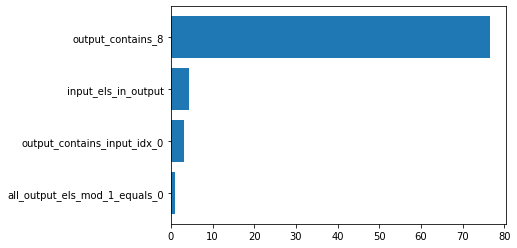

020_1 : list(int) -> list(int)
f([74, 1, 93, 44, 5]) = [74]
f([52, 27, 13, 3, 0, 60, 51, 80, 21]) = [52]
f([19, 54]) = [19]
f([46, 7, 84, 59, 89, 6, 2]) = [46]
f([62, 4, 98, 65, 42, 22]) = [62]
f([79, 38, 77, 8]) = [79]
f([40, 28, 68, 65, 32, 39, 78]) = [40]
f([92, 8, 72, 48, 41, 20, 1, 9]) = [92]
f([66, 87, 35]) = [66]
f([96, 12]) = [96]
f([73, 17, 82, 45, 2, 57, 33, 99, 37, 5]) = [73]


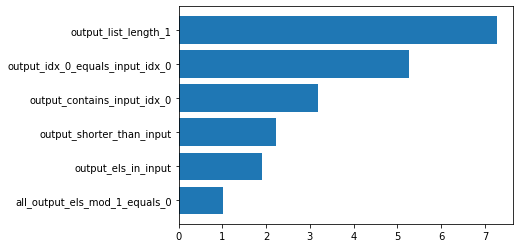

021_1 : list(int) -> list(int)
f([90, 80, 31, 14, 50]) = [50]
f([11, 79, 83]) = [83]
f([17, 59, 64, 22]) = [22]
f([65, 43, 10, 73, 3, 51, 56, 8, 0, 2]) = [2]
f([26, 24, 7, 85, 54, 52]) = [52]
f([5, 73, 77, 49, 85, 99, 97]) = [97]
f([6, 68, 41, 32, 3, 69, 1, 94, 58]) = [58]
f([4, 9, 8, 12, 71, 44, 33, 27]) = [27]
f([38, 48, 20, 0, 19, 29]) = [29]
f([34, 47]) = [47]
f([60, 81, 70]) = [70]


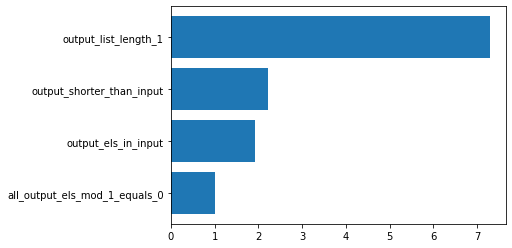

022_1 : list(int) -> list(int)
f([22, 46, 27, 2, 89]) = [2]
f([77, 4, 57]) = [4]
f([80, 70]) = [80]
f([9, 26, 65, 71, 33, 5, 67, 3, 40, 56]) = [40]
f([98, 55, 32, 41, 8, 93, 11, 44, 88]) = [44]
f([16, 48, 63]) = [48]
f([73, 25, 0, 85, 7, 90]) = [7]
f([17, 62, 5, 8, 58, 6, 64, 43]) = [64]
f([68, 49]) = [68]
f([12, 92, 95, 0, 50, 34, 30]) = [34]
f([54, 5, 14, 24]) = [14]


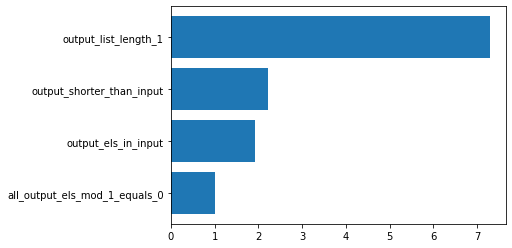

023_1 : list(int) -> list(int)
f([28, 48, 57, 36, 4]) = [36]
f([90, 54, 16, 3]) = [16]
f([22, 9, 14, 87, 71, 3]) = [14]
f([72, 1]) = [72]
f([69, 63, 50, 8, 86, 17, 0, 80, 19, 7]) = [0]
f([95, 51, 9, 93, 6, 5, 31, 47, 4]) = [93]
f([38, 79, 65, 26, 0, 96, 4]) = [26]
f([29, 86, 1, 2, 74, 22, 33, 5]) = [74]
f([62, 0, 1]) = [62]
f([36, 45, 15, 70, 85, 2]) = [45]
f([7, 25, 60, 3]) = [60]


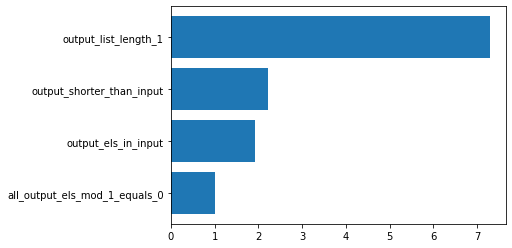

024_1 : list(int) -> list(int)
f([2, 5, 0, 82, 9]) = [9]
f([4, 93, 98, 3, 1, 96]) = [98]
f([3, 27, 5, 2, 8, 7, 97, 84, 42]) = [8]
f([8, 25, 16, 35, 6, 1, 49, 3, 2, 55]) = [16]
f([7, 61, 0, 56, 8, 92, 4, 2]) = [56]
f([3, 6, 2, 2]) = [6]
f([1, 0, 23]) = [1]
f([3, 2, 1, 6, 5, 9, 25, 19]) = [3]
f([2, 4, 5, 7, 48, 76]) = [7]
f([9, 79, 39, 90, 4, 3, 2, 88, 5, 3]) = [4]
f([2, 1, 4, 5, 6, 67, 43, 63, 37]) = [2]


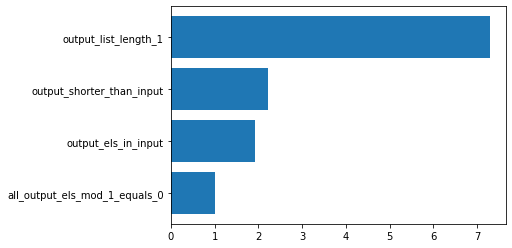

025_1 : list(int) -> list(int)
f([41, 6, 41, 27, 55, 66, 42, 3]) = [41, 41, 42]
f([61, 62, 9, 3, 56, 85, 64, 82, 49]) = [61, 62, 64]
f([5, 2, 90, 75, 57, 1, 7, 19, 8, 84]) = [5, 2, 1, 7, 8]
f([32, 32, 4, 3, 32, 7, 30, 96, 5]) = [32, 32, 32, 30]
f([99, 99, 97, 79, 16, 75, 75, 97, 16, 8]) = [99, 99, 97, 97]
f([15, 0, 35, 3, 3, 15, 10, 82, 15, 0]) = [15, 15, 10, 15]
f([5, 82, 28, 3, 6, 72, 2, 94, 52, 7]) = [5, 3, 6, 2, 7]
f([80, 87, 1, 13, 4, 8, 43, 55, 97, 81]) = [80, 87, 81]
f([78, 9, 79, 37, 79, 20, 3, 21, 7]) = [78, 79, 79]
f([54, 59, 7, 8, 58, 5, 34, 0, 14]) = [54, 59, 58]
f([29, 21, 61, 30, 6, 3, 85, 9, 26, 90]) = [29, 21, 26]


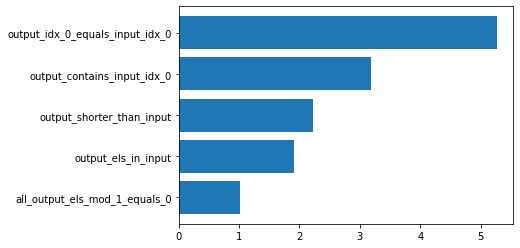

026_1 : list(int) -> list(int)
f([39, 52, 17, 56, 10]) = [52, 17, 56, 10]
f([42, 5, 82, 8, 16, 19, 99, 3]) = [5, 82, 8, 16, 19, 99, 3]
f([80, 0, 88, 30, 7, 15, 55]) = [0, 88, 30, 7, 15, 55]
f([36, 73, 54]) = [73, 54]
f([4, 24, 81, 64, 14, 70, 13, 32, 2, 9]) = [24, 81, 64, 14, 70, 13, 32, 2, 9]
f([6, 67]) = [67]
f([20, 23, 74, 25, 59, 77]) = [23, 74, 25, 59, 77]
f([24, 62, 1, 66, 7, 8, 83, 89, 65]) = [62, 1, 66, 7, 8, 83, 89, 65]
f([90]) = []
f([4, 60, 36, 51, 2, 98, 5, 86, 78, 28]) = [60, 36, 51, 2, 98, 5, 86, 78, 28]
f([50, 63, 96, 26]) = [63, 96, 26]


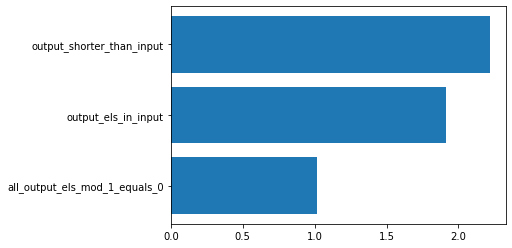

027_1 : list(int) -> list(int)
f([74, 12, 59, 87, 7]) = [74, 12, 59, 87]
f([9, 28, 91]) = [9, 28]
f([30, 36, 65, 95, 2, 4, 23, 93, 6, 73]) = [30, 36, 65, 95, 2, 4, 23, 93, 6]
f([45, 71, 78, 34, 3, 89, 67, 10, 96]) = [45, 71, 78, 34, 3, 89, 67, 10]
f([90, 83, 81, 1, 58, 88]) = [90, 83, 81, 1, 58]
f([70, 64, 0, 97, 66, 35, 82, 56]) = [70, 64, 0, 97, 66, 35, 82]
f([7, 75, 77, 8, 19, 60, 2, 46, 14, 27]) = [7, 75, 77, 8, 19, 60, 2, 46, 14]
f([31]) = []
f([21, 91, 18, 6, 20, 5, 17]) = [21, 91, 18, 6, 20, 5]
f([33, 11]) = [33]
f([24, 72, 6, 13]) = [24, 72, 6]


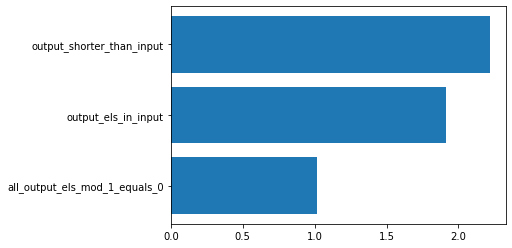

028_1 : list(int) -> list(int)
f([14, 46, 41, 44, 85, 5]) = [5, 41, 44]
f([34, 74, 96, 40, 9, 7, 58, 2]) = [2, 7, 40, 58, 96]
f([69, 8, 38, 91, 83, 54, 10, 17, 51]) = [10, 17, 38, 51, 54, 91]
f([3, 1, 28, 0, 6, 93, 90, 9, 56, 45]) = [0, 9, 28, 45, 56, 90, 93]
f([26, 49, 8, 4, 21, 16, 63]) = [4, 8, 16, 63]
f([0, 4, 43, 29, 19, 84, 25, 3]) = [3, 25, 29, 43, 84]
f([5, 55, 2, 8, 31, 97, 14, 32, 64, 76]) = [2, 8, 14, 32, 64, 76, 97]
f([4, 7, 81, 93, 8, 33, 13, 57, 15]) = [13, 15, 33, 57, 81, 93]
f([85, 87, 69, 61, 88, 35]) = [35, 61, 69]
f([98, 71, 53, 79, 9, 42, 25]) = [25, 42, 53, 79]
f([43, 21, 26, 5, 6, 89, 30, 55, 27]) = [5, 26, 27, 30, 55, 89]


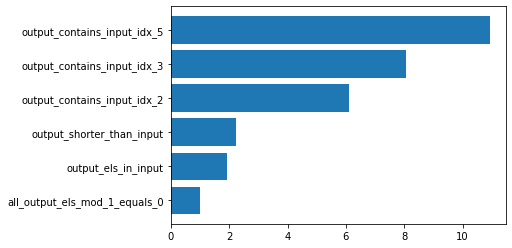

029_1 : list(int) -> list(int)
f([2, 3, 75, 17, 8, 6]) = [17, 8]
f([1, 4, 99, 5, 4, 14, 73, 28]) = [99, 5, 4, 14]
f([4, 6, 37, 8, 1, 31, 7, 69, 62, 67]) = [31, 7, 69]
f([4, 5, 20, 66, 61, 19, 16]) = [19, 16]
f([6, 6, 70, 27, 86, 99, 7, 30, 66]) = [30]
f([3, 6, 4, 48, 20, 75, 7, 30, 0, 43]) = [20, 75, 7, 30]
f([2, 4, 38, 74, 1, 6, 21, 3, 5]) = [74, 1, 6]
f([4, 5, 35, 3, 0, 5, 35, 1, 0, 35]) = [5, 35]
f([6, 7, 1, 31, 43, 56, 4, 2, 0, 65]) = [2, 0]
f([2, 6, 48, 84, 7, 77, 19, 59, 43]) = [84, 7, 77, 19, 59]
f([3, 5, 7, 0, 7, 17, 91, 84, 4, 2]) = [7, 17, 91]


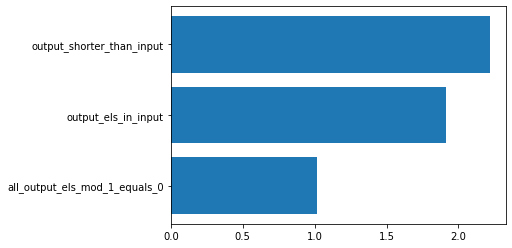

030_1 : list(int) -> list(int)
f([5, 0, 24, 4, 41, 18, 9]) = [0, 24, 4, 41, 18]
f([1, 75, 48, 90, 5, 9, 4, 21, 59]) = [75]
f([0, 96, 6, 62, 83, 96, 43, 25, 52, 43]) = []
f([3, 81, 0, 8, 87, 62, 6, 10]) = [81, 0, 8]
f([7, 9, 6, 4, 15, 45, 88, 83, 26, 92]) = [9, 6, 4, 15, 45, 88, 83]
f([4, 6, 94, 1, 3, 5, 48, 2, 24, 63]) = [6, 94, 1, 3]
f([2, 8, 15, 7, 72, 0, 6, 50, 82]) = [8, 15]
f([8, 27, 51, 44, 74, 0, 54, 5, 95, 49]) = [27, 51, 44, 74, 0, 54, 5, 95]
f([9, 91, 38, 8, 87, 42, 1, 3, 6, 2]) = [91, 38, 8, 87, 42, 1, 3, 6, 2]
f([1, 96, 0, 3, 22, 2, 7, 41, 3, 5]) = [96]
f([6, 0, 59, 1, 71, 2, 9, 72, 3, 90]) = [0, 59, 1, 71, 2, 9]


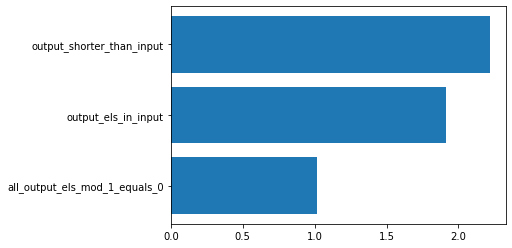

031_1 : list(int) -> list(int)
f([68, 93, 10, 24, 5]) = [68, 24, 5]
f([54, 99, 84, 58]) = [84]
f([3, 38, 7, 16, 78, 51, 41, 12, 67, 77]) = [3, 7, 41, 67]
f([95, 37, 73, 97, 97, 56, 97, 97]) = []
f([94, 0, 9, 5, 6, 33, 4, 59, 54]) = [0, 9, 5, 6, 4]
f([2, 1, 70]) = [2, 1]
f([7, 48, 28, 81, 6, 29]) = [7, 48, 28, 81, 6, 29]
f([95, 6, 78, 57, 96, 33, 78, 36]) = [6]
f([16, 51, 38, 22, 74, 38, 55, 51, 51, 50]) = [22]
f([5, 42, 83, 53, 6, 27, 26, 2, 78, 44]) = [5, 42, 83, 6, 27, 26, 2, 44]
f([4, 37, 95, 13, 39, 94, 0, 68, 3]) = [4, 0, 68, 3]


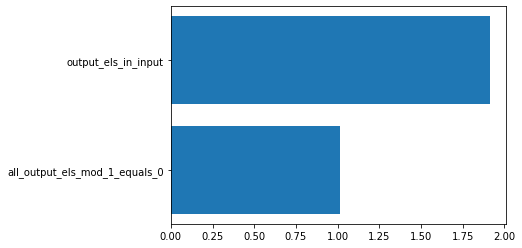

032_1 : list(int) -> list(int)
f([8, 0, 3, 56, 95]) = [8, 0, 56, 95]
f([93, 5, 51, 24, 11, 7, 44]) = [93, 5, 24, 11, 7, 44]
f([27, 20, 19, 63, 13, 64]) = [27, 20, 63, 13, 64]
f([15, 57, 70, 35]) = [15, 57, 35]
f([1, 43, 23, 65, 4, 6, 28, 2, 10, 40]) = [1, 43, 65, 4, 6, 28, 2, 10, 40]
f([21, 79, 73, 53, 3]) = [21, 79, 53, 3]
f([49, 44, 97, 96, 91, 38]) = [49, 44, 96, 91, 38]
f([5, 87, 12, 71, 2, 90, 37]) = [5, 87, 71, 2, 90, 37]
f([55, 88, 59, 92, 6, 8, 12, 17]) = [55, 88, 92, 6, 8, 12, 17]
f([48, 7, 72, 82]) = [48, 7, 82]
f([17, 77, 84, 33, 81, 36, 9]) = [17, 77, 33, 81, 36, 9]


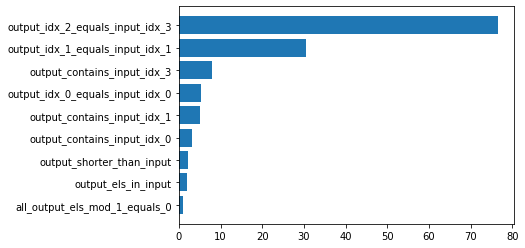

033_1 : list(int) -> list(int)
f([17, 65, 41, 49, 9, 5]) = [17, 5]
f([85, 50, 30, 14, 6, 89, 57, 77]) = [85, 89, 57, 77]
f([73, 3, 2, 70, 21, 87, 86, 23, 76]) = [73, 87, 86, 23, 76]
f([11, 2, 74, 41, 1, 10, 0]) = [11, 10, 0]
f([31, 47, 82, 96, 52, 98, 3, 4, 68, 61]) = [31, 98, 3, 4, 68, 61]
f([97, 26, 60, 9, 94, 96, 20]) = [97, 96, 20]
f([7, 1, 35, 26, 9, 5, 36, 33, 54, 23]) = [7, 5, 36, 33, 54, 23]
f([44, 74, 4, 97, 8, 53, 22, 6, 62, 69]) = [44, 53, 22, 6, 62, 69]
f([56, 71, 92, 0, 70, 55, 91, 40, 37]) = [56, 55, 91, 40, 37]
f([93, 3, 75, 1, 9, 99, 15, 2]) = [93, 99, 15, 2]
f([2, 21, 18, 89, 43, 8]) = [2, 8]


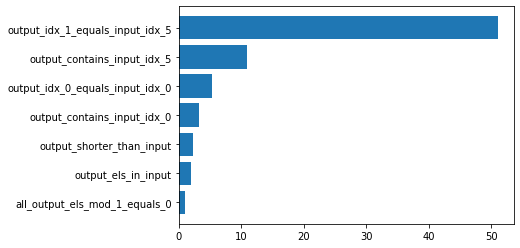

034_1 : list(int) -> list(int)
f([3, 4, 9, 6, 91]) = [3, 4, 91]
f([2, 9, 3, 29, 19, 61, 23, 59, 66, 76]) = [2, 76]
f([3, 5, 31, 85, 37, 9, 4]) = [3, 5, 9, 4]
f([1, 8, 0, 65, 95, 28, 3, 7]) = []
f([2, 4, 0, 7]) = [2]
f([1, 5, 9, 61, 56, 3]) = [3]
f([2, 2, 8, 7, 32, 64, 0, 45, 6]) = [2, 8, 7, 32, 64, 0, 45, 6]
f([1, 2, 9, 4]) = [9, 4]
f([3, 7, 4, 46, 2, 0, 61, 5]) = [3, 7, 5]
f([2, 3, 7, 0, 93, 23, 44]) = [2, 0, 93, 23, 44]
f([2, 3, 50, 6, 19, 0, 36, 9, 99]) = [2, 6, 19, 0, 36, 9, 99]


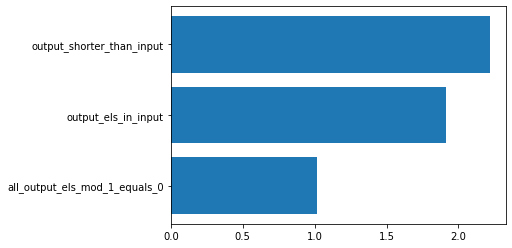

035_1 : list(int) -> list(int)
f([7, 99, 63, 7, 7]) = [99, 63, 7, 7]
f([7, 7]) = [7]
f([47, 14, 45, 7, 6, 59, 48, 50, 5, 19]) = [47, 14, 45, 6, 59, 48, 50, 5, 19]
f([8, 38, 3, 42, 7, 78, 71]) = [8, 38, 3, 42, 78, 71]
f([85, 46, 84, 79, 44, 7, 1, 2, 7]) = [85, 46, 84, 79, 44, 1, 2, 7]
f([7, 6, 7]) = [6, 7]
f([7, 7, 30, 65, 7, 75]) = [7, 30, 65, 7, 75]
f([6, 4, 15, 64, 7, 7, 7, 18, 3]) = [6, 4, 15, 64, 7, 7, 18, 3]
f([55, 1, 9, 7, 21, 73, 2, 96, 4, 8]) = [55, 1, 9, 21, 73, 2, 96, 4, 8]
f([7, 70, 7, 7]) = [70, 7, 7]
f([7, 97, 29, 13, 2, 4, 79, 7]) = [97, 29, 13, 2, 4, 79, 7]


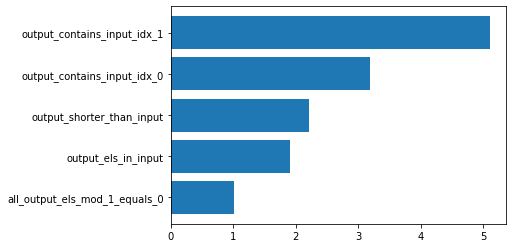

036_1 : list(int) -> list(int)
f([95, 95, 73, 95, 23]) = [95, 73, 95, 23]
f([35, 22, 46, 94, 94, 52]) = [35, 22, 46, 94, 52]
f([2, 90, 8, 90, 72, 14, 13, 1, 80]) = [2, 8, 90, 72, 14, 13, 1, 80]
f([92, 92]) = [92]
f([61, 79, 89, 71, 74, 20, 30, 62, 67, 3]) = [61, 79, 71, 74, 20, 30, 62, 67, 3]
f([99, 99, 8, 96, 99, 6, 40]) = [99, 8, 96, 99, 6, 40]
f([91, 27, 60, 16, 6, 46, 0, 75, 3]) = [27, 60, 16, 6, 46, 0, 75, 3]
f([41, 50, 50, 50]) = [41, 50, 50]
f([31, 31, 31]) = [31, 31]
f([1, 37, 70, 4, 7, 5, 29, 70]) = [1, 37, 4, 7, 5, 29, 70]
f([2, 80, 12, 93, 54, 53, 28, 9, 83, 7]) = [2, 80, 12, 54, 53, 28, 9, 83, 7]


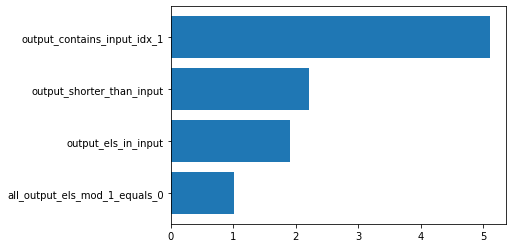

037_1 : list(int) -> list(int)
f([8, 3, 1, 3, 3]) = [8, 1]
f([73, 19, 51, 99, 67, 5, 47, 4, 3]) = [73, 19, 51, 99, 67, 5, 47, 4]
f([5, 3, 34, 63, 38, 3]) = [5, 34, 63, 38]
f([44, 66, 3, 46, 2, 6, 88, 75]) = [44, 66, 46, 2, 6, 88, 75]
f([68, 76, 1, 3, 8, 12, 42, 0, 6, 18]) = [68, 76, 1, 8, 12, 42, 0, 6, 18]
f([3, 1, 3, 81, 9, 43, 17, 89]) = [1, 81, 9, 43, 17, 89]
f([3, 8, 50, 3, 3, 7]) = [8, 50, 7]
f([3, 3, 3]) = []
f([73, 3, 9, 6, 3, 0, 26, 46, 74, 2]) = [73, 9, 6, 0, 26, 46, 74, 2]
f([3, 2, 3, 3]) = [2]
f([4, 7, 66, 61, 3, 2, 3]) = [4, 7, 66, 61, 2]


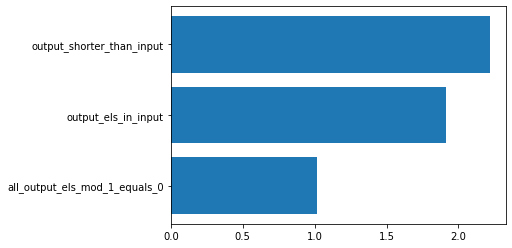

038_1 : list(int) -> list(int)
f([7, 32, 7, 32, 87]) = [32, 32, 87]
f([27, 38, 68, 75, 79, 8, 22, 0, 44, 1]) = [38, 68, 75, 79, 8, 22, 0, 44, 1]
f([34, 34, 19, 34, 35, 34]) = [19, 35]
f([17, 17, 17]) = []
f([92, 31, 45, 92, 49, 26, 11, 3, 97]) = [31, 45, 49, 26, 11, 3, 97]
f([13, 13, 9, 13, 3, 71, 78, 48]) = [9, 3, 71, 78, 48]
f([39, 39, 39, 28, 12, 12, 78]) = [28, 12, 12, 78]
f([15, 15, 15, 15]) = []
f([20, 40, 20, 20, 4, 20, 60, 5, 77, 36]) = [40, 4, 60, 5, 77, 36]
f([47, 47, 41, 47, 47]) = [41]
f([29, 18, 9, 24, 56, 6, 54, 35, 8]) = [18, 9, 24, 56, 6, 54, 35, 8]


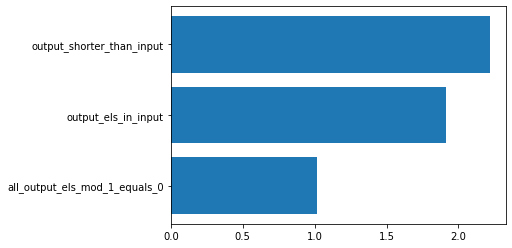

039_1 : list(int) -> list(int)
f([28, 97, 22, 97, 22]) = [28]
f([0, 85, 96, 30]) = [85, 30]
f([20, 45, 76, 66, 92, 52, 7, 8]) = [20, 45, 76, 66, 52, 8]
f([0, 4, 38, 1, 88, 88, 62, 2, 81, 87]) = [4, 38, 1, 62, 2, 81, 87]
f([14, 13, 91, 43, 13, 17]) = [14, 43, 17]
f([6, 63, 8, 47, 3, 5, 96, 3, 96, 11]) = [6, 63, 8, 47, 5, 11]
f([44, 44, 44]) = []
f([2, 61, 59, 26, 1, 6, 37, 53, 74, 77]) = [2, 61, 59, 26, 6, 37, 53, 74]
f([39, 4, 63, 63, 12, 14, 7]) = [39, 12, 14, 7]
f([75, 31, 35, 50, 4, 60, 40, 45, 86]) = [75, 31, 35, 50, 60, 40, 45]
f([23, 78, 24, 9, 8, 79, 89, 8]) = [23, 78, 24, 9, 79]


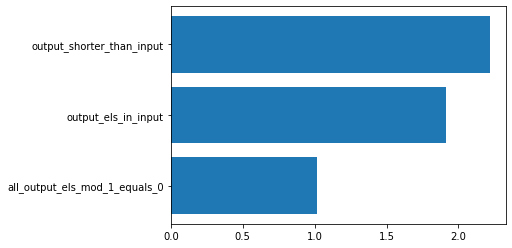

040_1 : list(int) -> list(int)
f([75, 78, 54, 76, 56]) = [75, 9, 54, 76, 56]
f([35, 24, 0, 8, 51, 42, 60, 20, 4]) = [35, 9, 0, 8, 51, 42, 60, 20, 4]
f([16, 31, 77, 74, 38, 23]) = [16, 9, 77, 74, 38, 23]
f([7, 2, 0, 6, 67, 64, 5, 30, 95, 70]) = [7, 9, 0, 6, 67, 64, 5, 30, 95, 70]
f([25, 48, 96, 89]) = [25, 9, 96, 89]
f([38, 7, 2, 0, 84, 10, 91]) = [38, 9, 2, 0, 84, 10, 91]
f([68, 21]) = [68, 9]
f([15, 2, 12, 98, 49, 90, 79, 1]) = [15, 9, 12, 98, 49, 90, 79, 1]
f([78, 32, 86, 54, 5, 33, 80, 28, 18, 39]) = [78, 9, 86, 54, 5, 33, 80, 28, 18, 39]
f([73, 40, 76, 57, 88, 3, 1, 7, 71]) = [73, 9, 76, 57, 88, 3, 1, 7, 71]
f([36, 82, 27]) = [36, 9, 27]


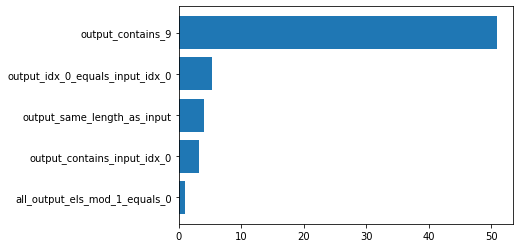

041_1 : list(int) -> list(int)
f([4, 3, 12, 6, 67, 1, 9]) = [12, 6, 67, 3, 9]
f([3, 1, 2, 10, 90, 6, 0, 76]) = [2, 10, 1, 6, 0, 76]
f([5, 7, 33, 0, 71, 9, 78, 4, 2, 66]) = [33, 0, 71, 9, 7, 4, 2, 66]
f([1, 0, 1, 39, 49, 14, 90, 57, 0, 99]) = [0, 39, 49, 14, 90, 57, 0, 99]
f([2, 4, 59, 62, 5, 6, 36, 45, 64]) = [59, 4, 5, 6, 36, 45, 64]
f([3, 6, 71, 90, 58, 59, 87, 0, 5]) = [71, 90, 6, 59, 87, 0, 5]
f([3, 3, 54, 0, 9, 18, 0]) = [54, 0, 3, 18, 0]
f([6, 8, 74, 4, 2, 9, 12, 86, 4, 21]) = [74, 4, 2, 9, 12, 8, 4, 21]
f([2, 1, 68, 0, 81, 75, 6, 7, 4, 53]) = [68, 1, 81, 75, 6, 7, 4, 53]
f([8, 5, 3, 2, 58, 65, 1, 6, 70, 9]) = [3, 2, 58, 65, 1, 6, 70, 5]
f([7, 2, 13, 9, 5, 1, 14, 8, 8, 4]) = [13, 9, 5, 1, 14, 8, 2, 4]


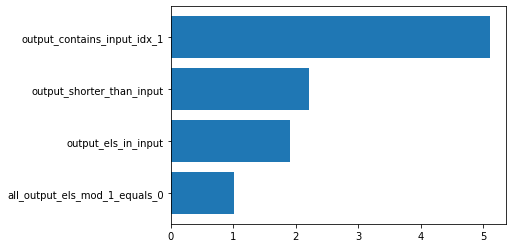

042_1 : list(int) -> list(int)
f([77, 63, 83, 97, 58]) = [7, 7, 6, 3, 8, 3, 9, 7, 5, 8]
f([47, 54]) = [4, 7, 5, 4]
f([95, 60, 15, 52]) = [9, 5, 6, 0, 1, 5, 5, 2]
f([33]) = [3, 3]
f([70, 2, 92, 13, 22, 19]) = [7, 0, 0, 2, 9, 2, 1, 3, 2, 2, 1, 9]
f([66, 4, 96, 91, 12]) = [6, 6, 0, 4, 9, 6, 9, 1, 1, 2]
f([53, 16, 48, 75, 41, 2, 78]) = [5, 3, 1, 6, 4, 8, 7, 5, 4, 1, 0, 2, 7, 8]
f([93, 11, 84, 5, 73, 45, 78]) = [9, 3, 1, 1, 8, 4, 0, 5, 7, 3, 4, 5, 7, 8]
f([26, 50, 88, 7, 30, 65]) = [2, 6, 5, 0, 8, 8, 0, 7, 3, 0, 6, 5]
f([80, 43, 63]) = [8, 0, 4, 3, 6, 3]
f([]) = []


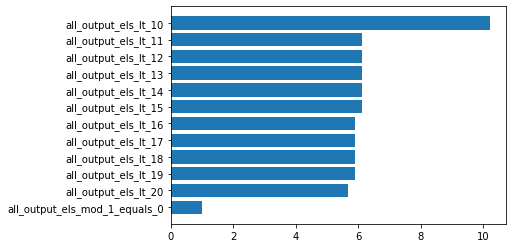

043_1 : list(int) -> list(int)
f([9, 0, 49, 49, 3]) = [9, 0, 0, 0, 3]
f([8, 82, 71, 25, 24, 31, 90, 34, 69, 6]) = [8, 82, 71, 25, 24, 31, 6, 34, 69, 6]
f([9, 83, 0, 56, 18, 48, 61, 5, 12]) = [9, 0, 0, 56, 18, 48, 61, 5, 12]
f([74, 8, 2, 74, 22, 4]) = [2, 8, 2, 2, 22, 4]
f([52, 44, 16, 1, 6, 5, 52, 23]) = [1, 44, 16, 1, 6, 5, 1, 23]
f([33, 33, 21]) = [21, 21, 21]
f([54, 54, 54, 54, 54, 54, 8, 54, 54]) = [8, 8, 8, 8, 8, 8, 8, 8, 8]
f([6, 38, 85, 85, 62, 0, 22, 2, 4, 10]) = [6, 38, 0, 0, 62, 0, 22, 2, 4, 10]
f([63, 79, 95, 17]) = [63, 79, 17, 17]
f([50, 50, 50, 1, 50, 50, 50, 50]) = [1, 1, 1, 1, 1, 1, 1, 1]
f([9, 11, 11, 11, 11, 11, 11]) = [9, 9, 9, 9, 9, 9, 9]


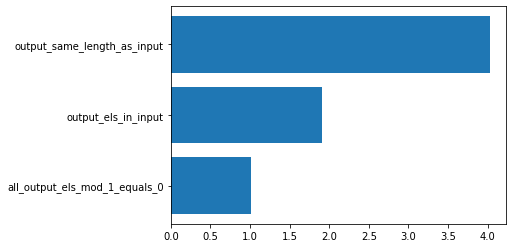

044_1 : list(int) -> list(int)
f([60, 87, 71, 94, 35]) = [60, 87, 71, 59, 59]
f([11, 90, 4, 16]) = [11, 86, 86, 16]
f([14, 52, 5]) = [14, 47, 47]
f([23, 77]) = [54, 54]
f([22]) = [0]
f([73, 58, 3, 15, 65, 7, 51]) = [70, 58, 70, 15, 65, 7, 51]
f([37, 6, 38, 56, 28]) = [37, 50, 38, 50, 28]
f([27, 94, 63, 44, 30, 91, 9, 74, 19]) = [27, 85, 63, 44, 30, 91, 85, 74, 19]
f([21, 39, 2, 84, 40, 45, 68, 67, 48, 95]) = [21, 39, 93, 84, 40, 45, 68, 67, 48, 93]
f([10, 25, 6, 4, 35, 8]) = [10, 25, 6, 31, 31, 8]
f([92, 1, 80, 82, 29, 74, 12, 0]) = [92, 1, 80, 82, 29, 74, 12, 92]


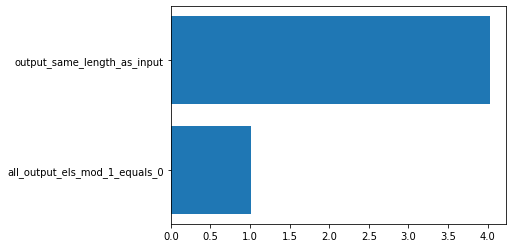

045_1 : list(int) -> list(int)
f([45, 30, 33, 4, 64]) = [45, 45, 45, 45, 45]
f([70, 43, 11, 75]) = [70, 70, 70, 70]
f([51, 46, 52, 74, 5, 72, 9]) = [51, 51, 51, 51, 51, 51, 51]
f([55, 22, 7, 94, 24, 60, 79, 97, 67]) = [55, 55, 55, 55, 55, 55, 55, 55, 55]
f([54, 2, 10, 8, 6, 95]) = [54, 54, 54, 54, 54, 54]
f([35, 99, 5, 0, 2, 8, 17, 58, 47, 81]) = [35, 35, 35, 35, 35, 35, 35, 35, 35, 35]
f([59, 84, 16, 82, 3, 18, 2, 1]) = [59, 59, 59, 59, 59, 59, 59, 59]
f([29]) = [29]
f([38, 7]) = [38, 38]
f([31, 86, 63]) = [31, 31, 31]
f([66, 76, 44, 89, 61, 88, 6, 97, 53]) = [66, 66, 66, 66, 66, 66, 66, 66, 66]


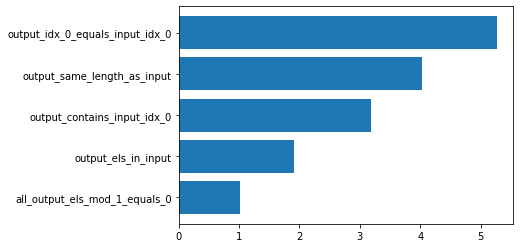

046_1 : list(int) -> list(int)
f([87, 67, 47, 9, 44]) = [20, 20, 38, 35]
f([80, 98, 4, 25]) = [18, 94, 21]
f([2, 53, 31, 23, 49, 6, 16]) = [51, 22, 8, 26, 43, 10]
f([58, 86, 12, 66, 90, 20, 45, 64]) = [28, 74, 54, 24, 70, 25, 19]
f([8, 34, 17, 82, 4, 93, 5, 18, 41, 11]) = [26, 17, 65, 78, 89, 88, 13, 23, 30]
f([88, 7, 36, 5, 53, 67, 86, 3]) = [81, 29, 31, 48, 14, 19, 83]
f([63, 89, 64, 7, 69]) = [26, 25, 57, 62]
f([35, 91, 19, 0, 8, 69]) = [56, 72, 19, 8, 61]
f([57, 2, 33, 9, 36, 8, 87, 10, 3, 68]) = [55, 31, 24, 27, 28, 79, 77, 7, 65]
f([6, 98, 3, 57, 97, 47, 7, 20, 0]) = [92, 95, 54, 40, 50, 40, 13, 20]
f([1, 60, 75, 94, 46, 39, 76]) = [59, 15, 19, 48, 7, 37]


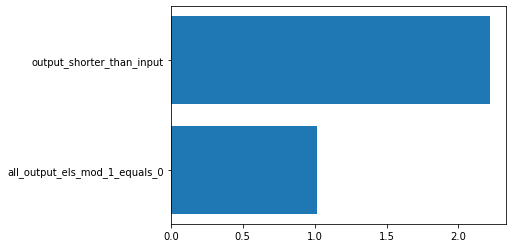

047_1 : list(int) -> list(int)
f([88, 93, 73, 54, 79]) = [88, 1, 93, 2, 73, 3, 54, 4, 79, 5]
f([11, 0, 85, 98]) = [11, 1, 0, 2, 85, 3, 98, 4]
f([62, 53, 21]) = [62, 1, 53, 2, 21, 3]
f([90, 33]) = [90, 1, 33, 2]
f([68, 49, 92, 75, 8, 17, 40]) = [68, 1, 49, 2, 92, 3, 75, 4, 8, 5, 17, 6, 40, 7]
f([55, 65, 13, 84]) = [55, 1, 65, 2, 13, 3, 84, 4]
f([4, 28, 42, 61, 96]) = [4, 1, 28, 2, 42, 3, 61, 4, 96, 5]
f([32, 25, 3, 69, 26, 44]) = [32, 1, 25, 2, 3, 3, 69, 4, 26, 5, 44, 6]
f([51, 89, 91]) = [51, 1, 89, 2, 91, 3]
f([59, 47]) = [59, 1, 47, 2]
f([77, 22, 60, 16, 50, 0, 19]) = [77, 1, 22, 2, 60, 3, 16, 4, 50, 5, 0, 6, 19, 7]


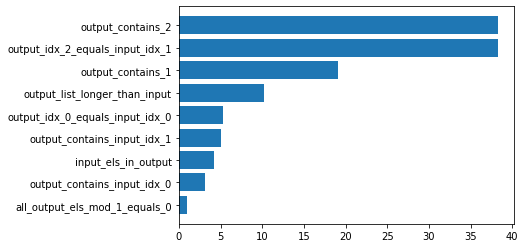

048_1 : list(int) -> list(int)
f([2, 5, 1, 4, 1]) = [1, 2, 1, 2, 3, 4, 5, 1, 1, 2, 3, 4, 1]
f([3, 3, 2]) = [1, 2, 3, 1, 2, 3, 1, 2]
f([5, 4]) = [1, 2, 3, 4, 5, 1, 2, 3, 4]
f([3, 0, 5, 2]) = [1, 2, 3, 1, 2, 3, 4, 5, 1, 2]
f([5]) = [1, 2, 3, 4, 5]
f([1, 4, 0, 9]) = [1, 1, 2, 3, 4, 1, 2, 3, 4, 5, 6, 7, 8, 9]
f([2, 3, 1, 6]) = [1, 2, 1, 2, 3, 1, 1, 2, 3, 4, 5, 6]
f([2, 2, 3]) = [1, 2, 1, 2, 1, 2, 3]
f([5, 4, 4]) = [1, 2, 3, 4, 5, 1, 2, 3, 4, 1, 2, 3, 4]
f([2, 5, 5]) = [1, 2, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5]
f([4]) = [1, 2, 3, 4]


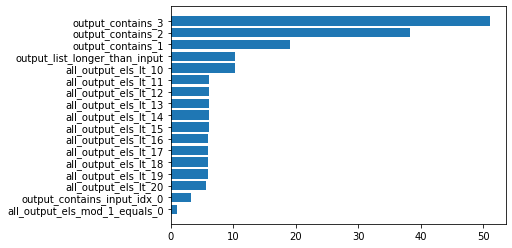

049_1 : list(int) -> list(int)
f([5, 2, 13, 6, 3]) = [10, 65, 30, 15]
f([3, 33]) = [99]
f([9]) = []
f([8, 2, 6, 9]) = [16, 48, 72]
f([6, 3, 1]) = [18, 6]
f([10, 5]) = [50]
f([7, 5, 6, 3]) = [35, 42, 21]
f([1, 0, 43, 9, 4, 6, 50, 58, 7]) = [0, 43, 9, 4, 6, 50, 58, 7]
f([2, 8, 4, 1, 5, 7]) = [16, 8, 2, 10, 14]
f([0, 67, 65, 73, 7, 93, 26]) = [0, 0, 0, 0, 0, 0]
f([4, 8, 3, 1, 2, 9, 6, 5]) = [32, 12, 4, 8, 36, 24, 20]


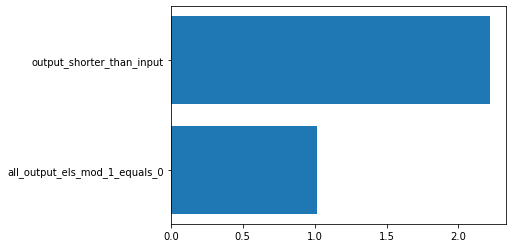

050_1 : list(int) -> list(int)
f([37, 20, 47, 8, 5]) = [37, 20, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 8, 5]
f([28, 29, 2]) = [28, 28, 29, 2]
f([83, 19, 7, 32, 9, 86]) = [83, 19, 7, 32, 9, 83, 84, 85, 86]
f([13, 1, 18]) = [13, 1, 13, 14, 15, 16, 17, 18]
f([24, 15, 27, 4]) = [24, 15, 24, 25, 26, 27, 4]
f([23, 7, 6, 28, 18, 4, 8]) = [23, 7, 6, 23, 24, 25, 26, 27, 28, 18, 4, 8]
f([94, 0, 3, 97, 44, 31, 27, 93, 5, 96]) = [94, 0, 3, 94, 95, 96, 97, 44, 31, 27, 93, 5, 94, 95, 96]
f([9, 4, 11, 2]) = [9, 4, 9, 10, 11, 2]
f([77, 41, 18, 4, 84]) = [77, 41, 18, 4, 77, 78, 79, 80, 81, 82, 83, 84]
f([59, 0, 43, 46, 63, 5]) = [59, 0, 43, 46, 59, 60, 61, 62, 63, 5]
f([6, 8, 2]) = [6, 6, 7, 8, 2]


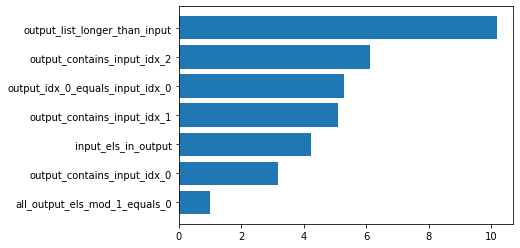

051_1 : list(int) -> list(int)
f([2, 1, 3, 5, 0]) = [2, 2, 1, 3, 3, 3, 5, 5, 5, 5, 5]
f([3, 4, 2, 0]) = [3, 3, 3, 4, 4, 4, 4, 2, 2]
f([3]) = [3, 3, 3]
f([0, 1, 1]) = [1, 1]
f([1, 0]) = [1]
f([5, 4, 3]) = [5, 5, 5, 5, 5, 4, 4, 4, 4, 3, 3, 3]
f([2, 2, 0]) = [2, 2, 2, 2]
f([1, 3, 0, 1]) = [1, 3, 3, 3, 1]
f([5, 4, 1, 2]) = [5, 5, 5, 5, 5, 4, 4, 4, 4, 1, 2, 2]
f([]) = []
f([0, 5, 2, 3, 2]) = [5, 5, 5, 5, 5, 2, 2, 3, 3, 3, 2, 2]


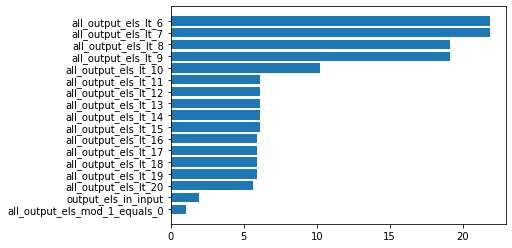

052_1 : list(int) -> list(int)
f([37, 98, 4, 19, 82]) = [21, 72, 0, 9, 16]
f([87, 5, 77, 7, 54, 67, 8]) = [56, 0, 49, 0, 20, 42, 0]
f([59, 47, 46]) = [45, 28, 24]
f([65, 25]) = [30, 10]
f([88]) = [64]
f([53, 31, 2, 13]) = [15, 3, 0, 3]
f([39, 18, 38, 50, 45, 7, 94]) = [27, 8, 24, 0, 20, 0, 36]
f([63, 84, 9, 16, 78, 69, 6, 4, 51]) = [18, 32, 0, 6, 56, 54, 0, 0, 5]
f([35, 41, 74, 91, 99, 3, 6, 26]) = [15, 4, 28, 9, 81, 0, 0, 12]
f([5, 68, 29, 86, 1, 27]) = [0, 48, 18, 48, 0, 14]
f([62, 42, 48, 76, 57, 23, 97, 73, 68, 11]) = [12, 8, 32, 42, 35, 6, 63, 21, 48, 1]


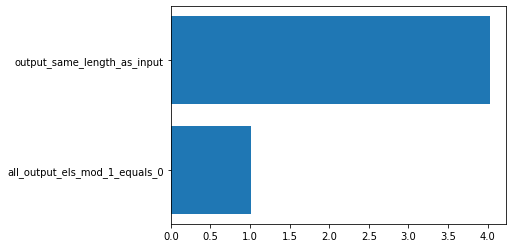

053_1 : list(int) -> list(int)
f([23, 23, 23, 27, 27]) = [23, 3, 27, 2]
f([1, 95, 95, 41, 41, 1, 35, 95, 35]) = [1, 2, 95, 3, 41, 2, 35, 2]
f([39, 39]) = [39, 2]
f([0, 0, 97, 97, 25, 25]) = [0, 2, 97, 2, 25, 2]
f([78, 99, 50, 5, 90, 5, 78, 90, 50, 99]) = [78, 2, 99, 2, 50, 2, 5, 2, 90, 2]
f([40, 30, 30, 40, 40, 40, 30]) = [40, 4, 30, 3]
f([]) = []
f([7, 7, 75, 75]) = [7, 2, 75, 2]
f([58, 58, 58]) = [58, 3]
f([55, 63, 63, 94, 8, 8, 55, 63, 94, 94]) = [55, 2, 63, 3, 94, 3, 8, 2]
f([6, 68, 6, 69, 6, 69, 6, 68]) = [6, 4, 68, 2, 69, 2]


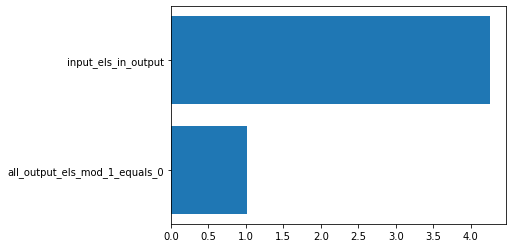

054_1 : list(int) -> list(int)
f([5, 93, 14, 73, 4, 8]) = [5, 93, 42, 73, 12, 24]
f([77, 0, 6, 8, 35, 7, 22, 21]) = [77, 0, 18, 24, 35, 7, 66, 21]
f([81, 23, 89, 6, 9, 2, 1, 5, 55]) = [81, 23, 89, 18, 9, 6, 1, 5, 55]
f([71, 75, 8, 1, 99, 6, 4]) = [71, 75, 24, 1, 99, 18, 12]
f([6, 3, 16, 53, 20, 47, 69, 5, 33, 0]) = [18, 3, 48, 53, 60, 47, 69, 5, 33, 0]
f([9, 83, 8, 6, 75, 26, 87, 69]) = [9, 83, 24, 18, 75, 78, 87, 69]
f([2, 6, 81, 59, 99, 15]) = [6, 18, 81, 59, 99, 15]
f([3, 65, 4, 7, 57, 11]) = [3, 65, 12, 7, 57, 11]
f([53, 6, 63, 7, 4, 0, 37, 1, 93]) = [53, 18, 63, 7, 12, 0, 37, 1, 93]
f([2, 20, 45, 6, 13, 5, 87]) = [6, 60, 45, 18, 13, 5, 87]
f([41, 51, 30, 3, 9, 8, 1, 4, 26, 0]) = [41, 51, 90, 3, 9, 24, 1, 12, 78, 0]


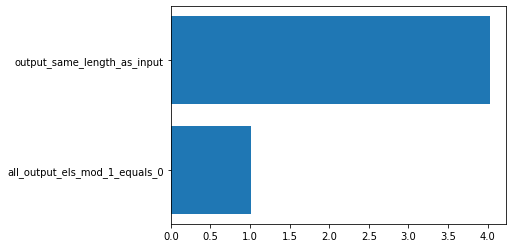

055_1 : list(int) -> list(int)
f([2, 0, 6, 0, 3, 2]) = [2, 0, 18, 0, 15, 12]
f([3, 7, 9, 8, 0, 6, 1, 2]) = [3, 14, 27, 32, 0, 36, 7, 16]
f([5, 5, 10, 5, 6, 4, 5]) = [5, 10, 30, 20, 30, 24, 35]
f([2, 4, 2, 1, 0, 2, 9, 1, 7, 6]) = [2, 8, 6, 4, 0, 12, 63, 8, 63, 60]
f([9, 3, 3, 5, 8, 0, 7, 4, 2]) = [9, 6, 9, 20, 40, 0, 49, 32, 18]
f([4, 4, 3, 7, 6, 5]) = [4, 8, 9, 28, 30, 30]
f([8, 9, 0, 6, 8, 7, 7]) = [8, 18, 0, 24, 40, 42, 49]
f([4, 7, 0, 1, 7, 2, 0, 1, 5]) = [4, 14, 0, 4, 35, 12, 0, 8, 45]
f([2, 7, 5, 2, 8, 8, 5, 5, 0, 5]) = [2, 14, 15, 8, 40, 48, 35, 40, 0, 50]
f([3, 3, 9, 8, 7, 3, 8, 8]) = [3, 6, 27, 32, 35, 18, 56, 64]
f([1, 1, 3, 4, 6, 1, 2]) = [1, 2, 9, 16, 30, 6, 14]


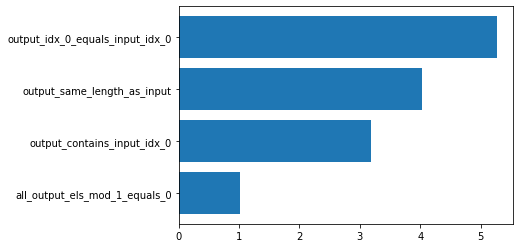

056_1 : list(int) -> list(int)
f([38, 61, 56, 17, 51, 4]) = [5, 53, 20, 60, 66, 44]
f([28, 7, 69, 5, 55, 18, 83, 71, 46]) = [47, 73, 86, 22, 60, 11, 76, 15, 37]
f([2, 33, 39, 42, 8, 7, 1, 64]) = [65, 3, 10, 12, 47, 45, 40, 10]
f([37, 23, 94, 5, 27, 72, 0]) = [1, 74, 30, 9, 99, 29, 44]
f([6, 48, 13, 78, 18, 88, 30, 86, 62, 21]) = [22, 64, 89, 34, 93, 24, 85, 21, 57, 16]
f([68, 7, 2, 69, 85, 79]) = [80, 87, 72, 6, 12, 74]
f([89, 26, 21, 65, 50, 6, 0, 75]) = [76, 2, 9, 54, 70, 27, 33, 97]
f([81, 59, 19, 7, 16, 76, 0, 9, 3]) = [4, 11, 3, 80, 21, 13, 26, 67, 90]
f([1, 25, 76, 53, 41, 27, 11, 77, 60, 91]) = [92, 62, 80, 15, 32, 47, 60, 84, 34, 11]
f([24, 83, 18, 51, 65, 0, 7]) = [8, 2, 68, 55, 23, 89, 31]
f([41, 35, 24, 32, 88, 36]) = [37, 90, 35, 28, 40, 47]


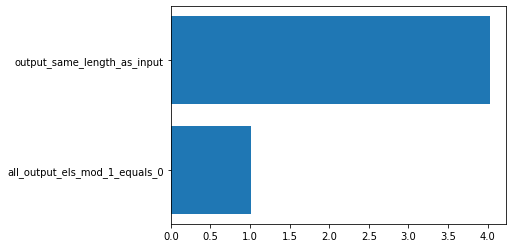

057_1 : list(int) -> list(int)
f([32, 3, 5, 81, 16, 6]) = [32, 0, 3, 1, 5, 1, 81, 1, 16, 0, 6, 0]
f([63, 18, 24, 92, 44, 89, 30]) = [63, 1, 18, 0, 24, 0, 92, 0, 44, 0, 89, 1, 30, 0]
f([74, 71, 15, 46, 26, 59]) = [74, 0, 71, 1, 15, 1, 46, 0, 26, 0, 59, 1]
f([78, 94, 6, 90, 7, 77, 79]) = [78, 0, 94, 0, 6, 0, 90, 0, 7, 1, 77, 1, 79, 1]
f([96, 28, 95, 6, 4, 57, 9]) = [96, 0, 28, 0, 95, 1, 6, 0, 4, 0, 57, 1, 9, 1]
f([5, 68, 22, 26, 6, 38, 35]) = [5, 1, 68, 0, 22, 0, 26, 0, 6, 0, 38, 0, 35, 1]
f([75, 9, 1, 80, 69, 28, 72]) = [75, 1, 9, 1, 1, 1, 80, 0, 69, 1, 28, 0, 72, 0]
f([41, 31, 6, 34, 66, 2]) = [41, 1, 31, 1, 6, 0, 34, 0, 66, 0, 2, 0]
f([1, 39, 10, 73, 88, 84]) = [1, 1, 39, 1, 10, 0, 73, 1, 88, 0, 84, 0]
f([12, 40, 33, 5, 4, 83, 52]) = [12, 0, 40, 0, 33, 1, 5, 1, 4, 0, 83, 1, 52, 0]
f([76, 20, 46, 7, 37, 97]) = [76, 0, 20, 0, 46, 0, 7, 1, 37, 1, 97, 1]


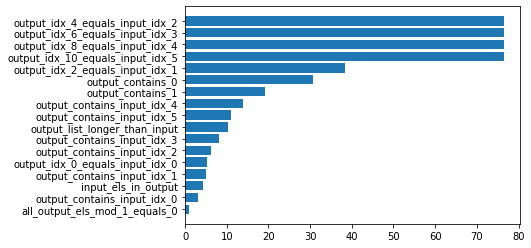

058_1 : list(int) -> list(int)
f([1, 45, 3, 4, 23, 55]) = [1, 0, 1, 1, 0, 0]
f([4, 68, 3, 68, 24, 8, 7, 8]) = [0, 0, 1, 0, 0, 0, 1, 1]
f([84, 2, 29, 7, 35, 2, 4, 8, 9, 31]) = [0, 1, 0, 0, 0, 0, 0, 1, 1, 0]
f([9, 3, 8, 6, 7, 5, 2]) = [0, 0, 0, 0, 0, 0, 0]
f([16, 20, 67, 4, 63, 1, 7, 6, 9, 4]) = [0, 0, 0, 1, 0, 0, 1, 0, 1, 0]
f([59, 0, 49, 4, 24, 6, 7, 11, 0, 13]) = [0, 0, 0, 1, 0, 1, 1, 0, 0, 0]
f([3, 2, 1, 6, 9, 1, 2, 5]) = [0, 1, 0, 0, 0, 0, 0, 0]
f([1, 2, 8, 4, 15, 0, 6, 90, 26, 62]) = [1, 1, 0, 1, 0, 0, 0, 0, 0, 0]
f([4, 2, 33, 4, 7, 4, 7]) = [0, 1, 0, 1, 0, 0, 1]
f([1, 4, 4, 4, 1, 6, 4, 4]) = [1, 0, 0, 1, 0, 1, 0, 0]
f([1, 52, 3, 0, 1, 6, 8, 4, 96, 52]) = [1, 0, 1, 0, 0, 1, 0, 0, 0, 0]


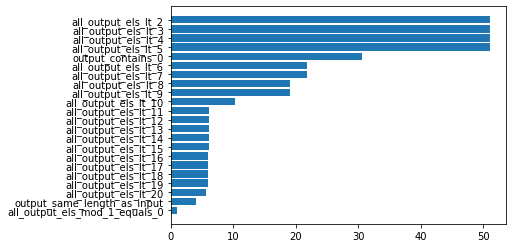

059_1 : list(int) -> list(int)
f([8, 8, 8, 6, 5, 5, 5, 6]) = [0, 0, 0, 0, 3, 2, 0, 3]
f([3, 4, 3, 5, 4, 4, 5, 5, 4, 3]) = [0, 0, 3, 4, 3]
f([7, 6, 6, 6, 6, 2, 2, 7, 6]) = [0, 2, 0, 0, 0, 5, 2]
f([4, 4, 7, 7, 9, 4, 9, 2, 2]) = [0, 2, 0, 3, 0, 0, 2, 0, 2]
f([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]) = [10]
f([2, 3, 1, 1, 3, 2, 2, 2, 3]) = [2, 4, 3]
f([9, 1, 3, 3, 1, 4, 9, 7, 9]) = [2, 0, 2, 1, 0, 0, 1, 0, 3]
f([2, 8, 2, 8, 8, 8, 5, 5, 8, 3]) = [0, 2, 1, 0, 2, 0, 0, 5]
f([2, 1, 9, 1, 2, 1, 9, 1, 2, 1]) = [5, 3, 0, 0, 0, 0, 0, 0, 2]
f([5, 4, 5, 4, 2, 8, 9, 7, 7]) = [0, 1, 0, 2, 2, 0, 2, 1, 1]
f([3, 6, 3, 1, 1, 3, 3, 6, 6, 3]) = [2, 0, 5, 0, 0, 3]


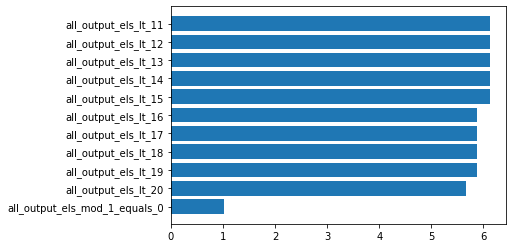

060_1 : list(int) -> list(int)
f([55, 82, 57, 4, 59, 6]) = [44, 17, 42, 95, 40, 93]
f([1, 13, 34, 6, 36, 79, 21, 11, 64, 46]) = [98, 86, 65, 93, 63, 20, 78, 88, 35, 53]
f([32, 70, 51, 41, 5, 69, 28]) = [67, 29, 48, 58, 94, 30, 71]
f([9, 72, 7, 75, 74, 1, 79, 84, 2]) = [90, 27, 92, 24, 25, 98, 20, 15, 97]
f([8, 66, 3, 43, 2, 73, 48, 74]) = [91, 33, 96, 56, 97, 26, 51, 25]
f([18, 15, 8, 63, 0, 62]) = [81, 84, 91, 36, 99, 37]
f([61, 87, 11, 12, 85, 77, 50]) = [38, 12, 88, 87, 14, 22, 49]
f([32, 31, 45, 8, 47, 48, 6, 44, 7]) = [67, 68, 54, 91, 52, 51, 93, 55, 92]
f([9, 53, 89, 60, 65, 8, 3, 1]) = [90, 46, 10, 39, 34, 91, 96, 98]
f([13, 80, 4, 7, 33, 84, 3]) = [86, 19, 95, 92, 66, 15, 96]
f([67, 6, 23, 50, 61, 83, 2, 65, 4, 1]) = [32, 93, 76, 49, 38, 16, 97, 34, 95, 98]


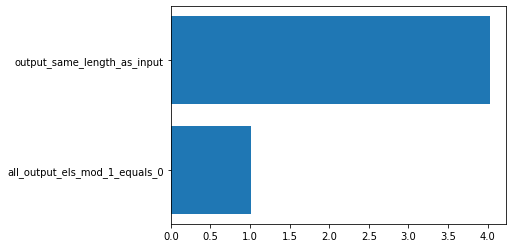

061_1 : list(int) -> list(int)
f([75, 25, 38, 55, 91, 26]) = [80, 29, 41, 57, 92, 26]
f([5, 30, 2, 9, 3, 19, 92, 15]) = [12, 36, 7, 13, 6, 21, 93, 15]
f([38, 10, 66, 49, 50, 8, 61, 59, 64]) = [46, 17, 72, 54, 54, 11, 63, 60, 64]
f([11, 19, 0, 31, 40, 16, 78]) = [17, 24, 4, 34, 42, 17, 78]
f([89, 4, 7, 8, 82, 3, 9, 45, 38, 94]) = [98, 12, 14, 14, 87, 7, 12, 47, 39, 94]
f([1, 47, 81, 66, 94, 21, 43]) = [7, 52, 85, 69, 96, 22, 43]
f([78, 52, 80, 93, 98, 44]) = [83, 56, 83, 95, 99, 44]
f([81, 3, 33, 77, 17, 0]) = [86, 7, 36, 79, 18, 0]
f([6, 0, 37, 7, 44, 71, 8, 2, 59]) = [14, 7, 43, 12, 48, 74, 10, 3, 59]
f([7, 5, 65, 3, 86, 2, 88, 73, 66, 99]) = [16, 13, 72, 9, 91, 6, 91, 75, 67, 99]
f([28, 45, 24, 16, 88, 22, 1, 46]) = [35, 51, 29, 20, 91, 24, 2, 46]


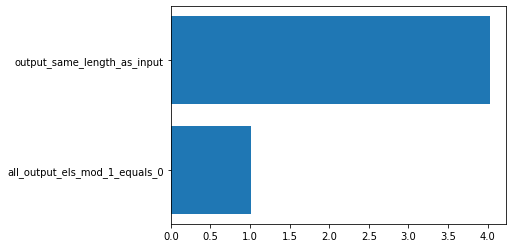

062_1 : list(int) -> list(int)
f([8, 0, 17, 5, 5, 0]) = [31, 7, 58, 22, 22, 7]
f([3, 9, 1, 7, 2, 4, 8, 0, 15, 5]) = [16, 34, 10, 28, 13, 19, 31, 7, 52, 22]
f([18, 1, 5, 11, 2, 1, 18]) = [61, 10, 22, 40, 13, 10, 61]
f([8, 7, 3, 9, 5, 1, 5, 1, 4]) = [31, 28, 16, 34, 22, 10, 22, 10, 19]
f([19, 3, 4, 1, 6, 2, 0, 9]) = [64, 16, 19, 10, 25, 13, 7, 34]
f([1, 6, 6, 7, 7, 5, 7]) = [10, 25, 25, 28, 28, 22, 28]
f([4, 9, 2, 8, 5, 8]) = [19, 34, 13, 31, 22, 31]
f([1, 16, 0, 8, 6, 1, 5, 2]) = [10, 55, 7, 31, 25, 10, 22, 13]
f([6, 4, 2, 9, 2, 18, 9]) = [25, 19, 13, 34, 13, 61, 34]
f([1, 1, 9, 4, 0, 0]) = [10, 10, 34, 19, 7, 7]
f([1, 2, 3, 13, 8, 13]) = [10, 13, 16, 46, 31, 46]


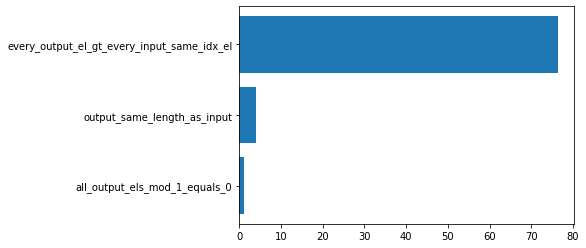

063_1 : list(int) -> list(int)
f([7, 9, 8, 24, 23]) = [4, 8, 6, 38, 36]
f([6, 8, 47, 6]) = [2, 6, 84, 2]
f([7, 11, 7, 5]) = [4, 12, 4, 0]
f([9, 5, 22, 18]) = [8, 0, 34, 26]
f([33, 19, 29, 8]) = [56, 28, 48, 6]
f([6, 6, 5, 9]) = [2, 2, 0, 8]
f([7, 9, 8, 46]) = [4, 8, 6, 82]
f([22, 5, 8, 41]) = [34, 0, 6, 72]
f([9, 7, 53, 8]) = [8, 4, 96, 6]
f([8, 5, 27, 19, 14]) = [6, 0, 44, 28, 18]
f([54, 8, 7, 54]) = [98, 6, 4, 98]


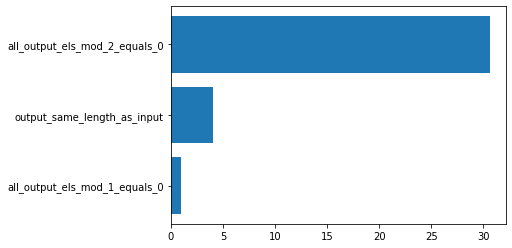

064_1 : list(int) -> list(int)
f([22, 14, 26, 39, 26, 13]) = [10, 8, 11, 14, 11, 8]
f([6, 50, 18, 72, 7, 84, 94, 0, 46, 8]) = [6, 17, 9, 23, 6, 26, 28, 5, 16, 7]
f([31]) = [12]
f([55, 3, 92, 85, 63, 58, 33, 67, 48]) = [18, 5, 28, 26, 20, 19, 13, 21, 17]
f([8, 2, 42, 59, 95, 97, 3]) = [7, 5, 15, 19, 28, 29, 5]
f([60, 96, 9, 72, 64, 89, 8, 25]) = [20, 29, 7, 23, 21, 27, 7, 11]
f([22, 38]) = [10, 14]
f([60, 87, 57, 6, 39, 2, 73, 1, 41]) = [20, 26, 19, 6, 14, 5, 23, 5, 15]
f([74, 1, 52, 63, 4, 61, 77]) = [23, 5, 18, 20, 6, 20, 24]
f([54, 55, 48, 40, 53, 0, 86, 7, 8, 3]) = [18, 18, 17, 15, 18, 5, 26, 6, 7, 5]
f([82, 2, 69, 47, 85, 93]) = [25, 5, 22, 16, 26, 28]


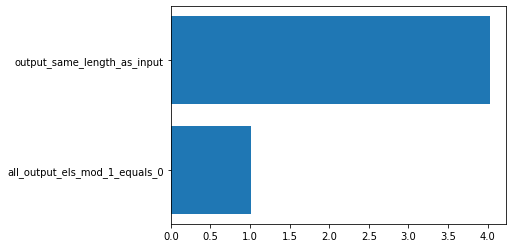

065_1 : list(int) -> list(int)
f([68, 9, 86, 13, 57, 14, 72, 25, 69]) = [72, 14, 86, 68]
f([77, 5, 56, 4, 34, 22, 65, 94, 20, 3]) = [20, 94, 22, 34, 4, 56]
f([42, 7, 59, 1, 92, 48, 24, 63, 5, 8]) = [8, 24, 48, 92, 42]
f([53, 5, 0, 7, 78, 43, 45, 39, 2]) = [2, 78, 0]
f([54, 0, 97, 79, 99, 50, 6, 93, 3, 84]) = [84, 6, 50, 0, 54]
f([68, 21, 69, 2, 39, 0, 93, 1, 16]) = [16, 0, 2, 68]
f([26, 7, 88, 48, 95, 94, 9, 27, 37, 3]) = [94, 48, 88, 26]
f([95, 78, 3, 76, 82, 87, 29, 68, 6]) = [6, 68, 82, 76, 78]
f([72, 85, 9, 36, 78, 90, 1, 65, 60, 4]) = [4, 60, 90, 78, 36, 72]
f([49, 8, 36, 70, 96, 23, 4, 19, 2]) = [2, 4, 96, 70, 36, 8]
f([4, 75, 1, 37, 9, 68, 89, 83, 74, 43]) = [74, 68, 4]


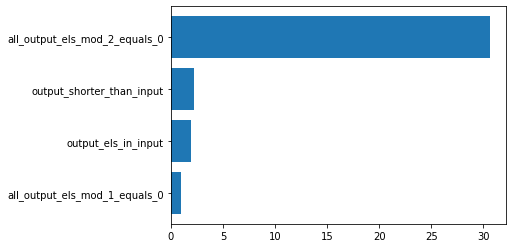

066_1 : list(int) -> list(int)
f([43, 20, 1, 20, 17, 55]) = [1, 20, 43, 17, 55]
f([92, 24, 11, 25, 21, 53, 25, 21]) = [11, 21, 24, 25, 53, 92]
f([86, 7, 63, 81, 9, 97, 41, 86, 3]) = [3, 41, 7, 63, 81, 9, 86, 97]
f([70, 70, 50, 70, 8, 50, 8, 50, 8, 8]) = [50, 70, 8]
f([58, 58, 58, 82, 58, 82, 58]) = [82, 58]
f([93, 93, 16, 78, 94, 14, 94, 16, 29, 62]) = [14, 16, 62, 29, 93, 94, 78]
f([8, 85, 72, 52, 88, 4, 75, 87, 51]) = [4, 51, 52, 8, 72, 75, 85, 87, 88]
f([90, 90, 2, 90, 2, 2, 90, 2, 90, 90]) = [2, 90]
f([19, 19, 19, 19, 19, 19, 19, 19, 19, 19]) = [19]
f([37, 3, 28, 28, 28, 28, 37, 54]) = [3, 54, 37, 28]
f([6, 73, 73, 64, 6, 64, 64, 73, 73]) = [6, 73, 64]


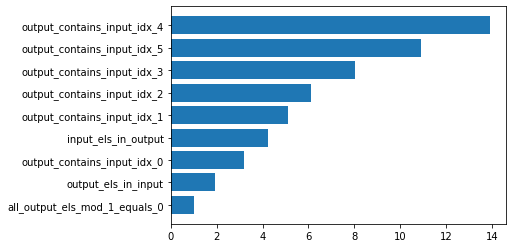

067_1 : list(int) -> list(int)
f([18, 78, 3, 5, 62, 8]) = [18, 78, 3]
f([27, 70, 0, 21, 74, 33, 87, 12, 22]) = [27, 0, 21, 33, 87, 12]
f([31, 91, 84, 30, 38, 10, 66, 0, 98, 94]) = [84, 30, 66, 0]
f([90, 50, 3, 1, 99, 0, 93]) = [90, 3, 99, 0, 93]
f([45, 8, 2, 69, 39, 9, 44, 4]) = [45, 69, 39, 9]
f([10, 7, 40, 2, 1, 27, 42, 83, 18, 96]) = [27, 42, 18, 96]
f([27, 57, 84, 75, 83, 1, 45]) = [27, 57, 84, 75, 45]
f([9, 54, 1, 26, 5, 0, 25, 12, 8, 3]) = [9, 54, 0, 12, 3]
f([36, 8, 0, 3, 6, 7, 72, 10, 66]) = [36, 0, 3, 6, 72, 66]
f([66, 24, 61, 13, 63, 10]) = [66, 24, 63]
f([6, 4, 7, 43, 8, 51, 41, 30]) = [6, 51, 30]


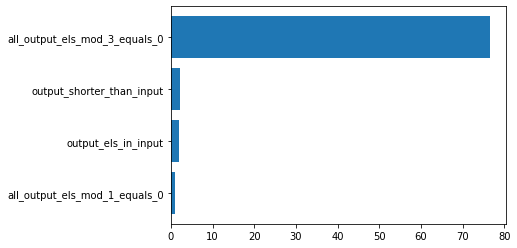

068_1 : list(int) -> list(int)
f([66, 74, 88, 49, 15]) = [1, 2, 3, 4, 6, 7, 8, 9, 10]
f([96, 25, 43, 86, 50, 44, 13, 87, 2, 84]) = [1, 2, 3, 4, 5, 6, 7, 8, 9]
f([21, 85]) = [1, 3, 4, 5, 6, 7, 8, 9, 10]
f([98, 30, 27, 53, 7, 45, 0]) = [1, 2, 3, 4, 5, 6, 8, 9, 10]
f([65, 1, 69, 76, 33, 16]) = [1, 2, 3, 4, 5, 7, 8, 9, 10]
f([43, 23, 57, 54, 28, 8, 9, 95]) = [1, 2, 3, 4, 5, 6, 7, 9, 10]
f([0, 96, 36, 7, 34, 93, 5, 91, 58]) = [1, 2, 3, 4, 5, 6, 7, 8, 10]
f([46]) = [2, 3, 4, 5, 6, 7, 8, 9, 10]
f([97, 84, 26]) = [1, 2, 4, 5, 6, 7, 8, 9, 10]
f([94, 24, 50, 49, 56, 61, 52, 37, 9, 39]) = [1, 2, 3, 4, 5, 6, 7, 8, 9]
f([4, 38, 89, 55]) = [1, 2, 3, 5, 6, 7, 8, 9, 10]


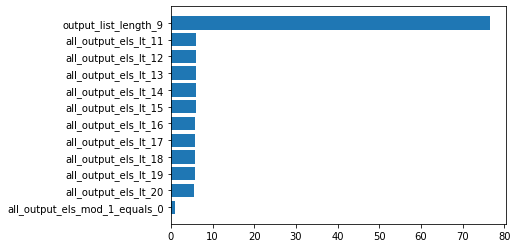

069_1 : list(int) -> list(int)
f([26, 68, 87, 84, 58, 10]) = [84]
f([8, 24, 51, 14, 2, 69, 9, 28, 48]) = [51]
f([5, 32, 76, 7, 90, 53, 65, 54]) = [76]
f([36, 99, 8, 9, 16, 67, 94, 0, 4, 40]) = [94]
f([3, 13, 1, 95, 17, 20, 12]) = [20]
f([75, 97, 64, 70, 5, 36, 1]) = [75]
f([89, 30, 61, 24, 85, 57, 66, 2, 42, 4]) = [85]
f([7, 33, 81, 1, 97, 77]) = [81]
f([11, 55, 59, 88, 9, 5, 22, 56, 53]) = [59]
f([6, 7, 8, 49, 35, 2, 5, 82]) = [49]
f([71, 27, 37, 54, 23, 56]) = [56]


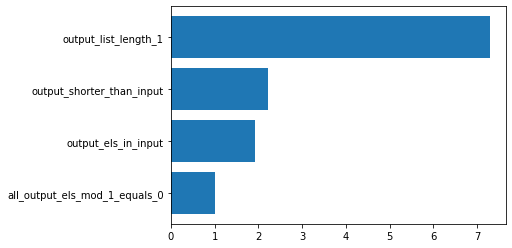

070_1 : list(int) -> list(int)
f([15, 4, 87, 8, 64, 14]) = [15, 14]
f([90, 35, 8, 1, 5, 6, 21, 70, 48, 51]) = [90, 51]
f([57, 74, 80, 40, 60, 25, 0, 52]) = [57, 52]
f([44, 3, 19, 58, 50, 38, 29, 39, 2]) = [44, 2]
f([56, 72, 9, 32, 7, 11, 30]) = [56, 30]
f([81, 6, 43, 1, 23, 12]) = [81, 12]
f([88, 54, 65, 37, 17, 5, 10]) = [88, 10]
f([84, 1, 24, 3, 29, 97, 94, 65, 7]) = [84, 7]
f([85, 42, 38, 9, 2, 15, 67, 47]) = [85, 47]
f([45, 69, 8, 5, 90, 1, 13, 59, 78, 29]) = [45, 29]
f([0, 31, 41, 91, 44, 92, 1, 50, 33]) = [0, 33]


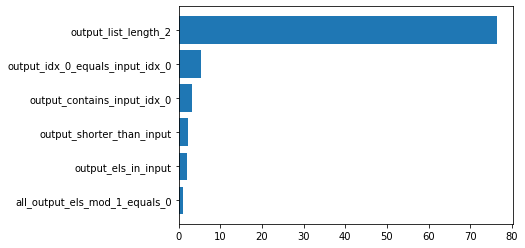

071_1 : list(int) -> list(int)
f([2, 9, 17, 9, 17, 4]) = [2, 11, 28, 37, 54, 58]
f([7, 7, 8, 3, 4, 4, 5, 0]) = [7, 14, 22, 25, 29, 33, 38, 38]
f([5, 7, 2, 6, 1, 0, 9]) = [5, 12, 14, 20, 21, 21, 30]
f([5, 0, 4, 15, 5, 7, 6, 15, 2, 7]) = [5, 5, 9, 24, 29, 36, 42, 57, 59, 66]
f([7, 7, 2, 7, 11, 0, 16, 16, 7]) = [7, 14, 16, 23, 34, 34, 50, 66, 73]
f([7, 8, 2, 5, 4, 0]) = [7, 15, 17, 22, 26, 26]
f([8, 1, 0, 6, 20, 5]) = [8, 9, 9, 15, 35, 40]
f([6, 0, 1, 5, 4, 6, 1, 5, 3, 4]) = [6, 6, 7, 12, 16, 22, 23, 28, 31, 35]
f([9, 5, 11, 1, 5, 2]) = [9, 14, 25, 26, 31, 33]
f([17, 2, 3, 1, 5, 7, 1]) = [17, 19, 22, 23, 28, 35, 36]
f([20, 5, 1, 7, 0, 4]) = [20, 25, 26, 33, 33, 37]


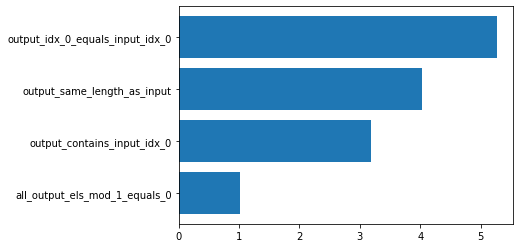

072_1 : list(int) -> list(int)
f([4, 2, 2, 2]) = [4, 8, 16, 32]
f([5, 2, 7]) = [5, 10, 70]
f([4, 1, 1, 4, 1, 4, 1]) = [4, 4, 4, 16, 16, 64, 64]
f([7, 9]) = [7, 63]
f([2, 2, 2, 3, 3, 1]) = [2, 4, 8, 24, 72, 72]
f([4, 6, 4]) = [4, 24, 96]
f([4, 2, 6]) = [4, 8, 48]
f([5, 1, 1, 1, 8, 1]) = [5, 5, 5, 5, 40, 40]
f([2, 2, 2, 2, 2, 2]) = [2, 4, 8, 16, 32, 64]
f([6, 2, 6]) = [6, 12, 72]
f([3, 4, 7]) = [3, 12, 84]


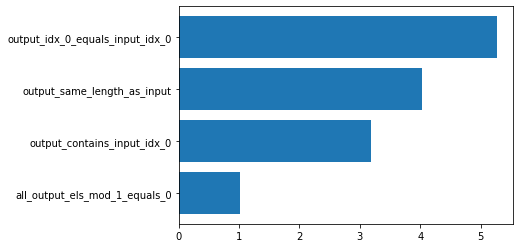

073_1 : list(int) -> list(int)
f([2, 6, 74, 86, 1, 89]) = [2, 6, 74, 86, 86, 89]
f([8, 9, 19, 2, 67, 83, 53, 4, 56, 95]) = [8, 9, 19, 19, 67, 83, 83, 83, 83, 95]
f([3, 5, 9, 50, 7, 62, 78, 0]) = [3, 5, 9, 50, 50, 62, 78, 78]
f([9, 11, 21, 25, 55, 48, 7, 1, 70]) = [9, 11, 21, 25, 55, 55, 55, 55, 70]
f([47, 66, 81, 0, 1, 99, 4]) = [47, 66, 81, 81, 81, 99, 99]
f([2, 3, 33, 8, 52, 4]) = [2, 3, 33, 33, 52, 52]
f([35, 69, 3, 25, 71, 96]) = [35, 69, 69, 69, 71, 96]
f([7, 22, 6, 29, 59, 36, 2, 1]) = [7, 22, 22, 29, 59, 59, 59, 59]
f([5, 2, 7, 24, 26, 97]) = [5, 5, 7, 24, 26, 97]
f([3, 6, 23, 9, 45, 46, 11]) = [3, 6, 23, 23, 45, 46, 46]
f([5, 16, 83, 85, 2, 9, 40, 3, 99]) = [5, 16, 83, 85, 85, 85, 85, 85, 99]


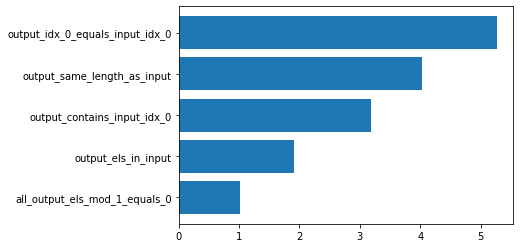

074_1 : list(int) -> list(int)
f([49, 32, 85, 49, 32, 2]) = [49, 32, 85, 49]
f([29, 0, 77, 35, 50, 7, 53, 35, 8, 82]) = [29, 0, 77, 35, 50, 7, 53, 35, 8]
f([66, 71, 9, 72, 11, 86, 91, 9]) = [66, 71, 9, 72, 11, 86, 91]
f([67, 1, 24, 37, 5, 18, 67]) = [67, 1, 24, 37, 5, 18]
f([9, 52, 96, 27, 83, 4, 42, 98, 4]) = [9, 52, 96, 27, 83, 4, 42, 98]
f([65, 70, 80, 70, 70, 65, 65, 0, 23]) = [65, 70, 80, 70, 70]
f([54, 26, 54, 26, 54, 54, 26, 26]) = [54, 26]
f([51, 43, 51, 51, 31, 51, 31]) = [51, 43, 51]
f([44, 38, 88, 6, 92, 92, 7, 73, 10, 22]) = [44, 38, 88, 6, 92, 92, 7, 73, 10]
f([57, 2, 45, 94, 59, 58, 94, 0, 2, 56]) = [57, 2, 45, 94, 59, 58, 94, 0]
f([61, 61, 61, 61, 61, 61]) = [61]


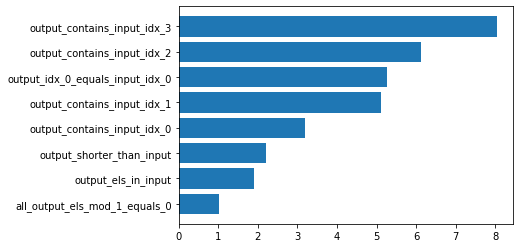

075_1 : list(int) -> list(int)
f([45, 58, 87, 48, 31, 34]) = [45, 58, 87]
f([7, 8, 39, 95, 11, 1, 72]) = [7, 8, 39, 95]
f([2, 44, 50, 62, 65, 9, 3, 8, 88, 91]) = [2, 44, 50, 62, 65, 88, 91]
f([2, 25, 39, 51, 16, 5, 66, 7]) = [2, 25, 39, 51, 66]
f([4, 31, 40, 6, 63, 1, 3, 66, 88]) = [4, 31, 40, 63, 66, 88]
f([9, 19, 3, 39, 87, 94, 41, 67, 0, 1]) = [9, 19, 39, 87, 94]
f([0, 37, 60, 57, 93, 38]) = [0, 37, 60, 93]
f([0, 3, 7, 21, 18, 40, 5, 27, 30, 92]) = [0, 3, 7, 21, 40, 92]
f([2, 38, 24, 77, 90, 1, 51]) = [2, 38, 77, 90]
f([29, 53, 0, 31, 84, 54, 6, 4, 80]) = [29, 53, 84]
f([5, 78, 52, 4, 82, 6, 7, 10]) = [5, 78, 82]


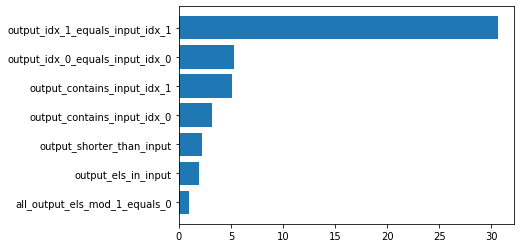

076_1 : list(int) -> list(int)
f([22, 1, 6, 8, 51, 26]) = [23, 7, 14, 59, 77]
f([8, 2, 65, 9, 81, 16, 79, 3, 80, 5]) = [10, 67, 74, 90, 97, 95, 82, 83, 85]
f([8, 5, 28, 36, 58, 40, 0]) = [13, 33, 64, 94, 98, 40]
f([31, 29, 3, 19, 5, 50, 0, 76]) = [60, 32, 22, 24, 55, 50, 76]
f([20, 71, 5, 1, 38, 4, 93, 2, 50]) = [91, 76, 6, 39, 42, 97, 95, 52]
f([5, 26, 61, 36, 4, 47, 1, 52]) = [31, 87, 97, 40, 51, 48, 53]
f([48, 35, 32, 14, 36, 26]) = [83, 67, 46, 50, 62]
f([37, 38, 40, 59, 11, 4]) = [75, 78, 99, 70, 15]
f([7, 2, 25, 8, 10, 23, 29, 6, 4]) = [9, 27, 33, 18, 33, 52, 35, 10]
f([9, 1, 48, 2, 54, 19, 63]) = [10, 49, 50, 56, 73, 82]
f([52, 8, 1, 17, 20, 51, 0, 21, 57, 5]) = [60, 9, 18, 37, 71, 51, 21, 78, 62]


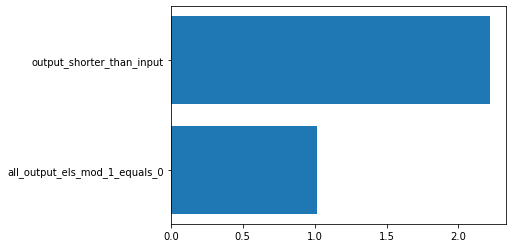

077_1 : list(int) -> list(int)
f([64, 98, 27, 26, 32]) = [64, 32, 98, 26, 27, 27, 26, 98, 32, 64]
f([1, 15, 28, 4]) = [1, 4, 15, 28, 28, 15, 4, 1]
f([80, 2, 61, 24, 37, 8]) = [80, 8, 2, 37, 61, 24, 24, 61, 37, 2, 8, 80]
f([93, 50, 81]) = [93, 81, 50, 50, 81, 93]
f([59, 90]) = [59, 90, 90, 59]
f([78, 9, 54, 23, 21]) = [78, 21, 9, 23, 54, 54, 23, 9, 21, 78]
f([62, 11, 88]) = [62, 88, 11, 11, 88, 62]
f([96, 51, 94, 91]) = [96, 91, 51, 94, 94, 51, 91, 96]
f([7, 16, 82, 19, 55, 6]) = [7, 6, 16, 55, 82, 19, 19, 82, 55, 16, 6, 7]
f([83]) = [83, 83]
f([76, 38, 66, 5, 3, 68]) = [76, 68, 38, 3, 66, 5, 5, 66, 3, 38, 68, 76]


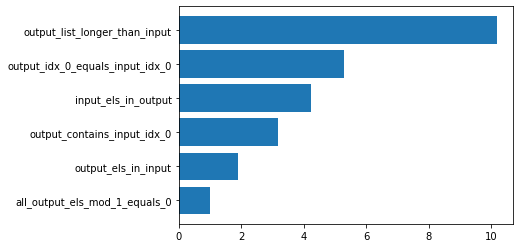

078_1 : list(int) -> list(int)
f([27, 4, 9, 71, 45, 69]) = [27]
f([10, 68, 80, 5, 29, 23, 9, 33, 69]) = [10, 68]
f([73, 32, 70, 0, 22, 2, 46, 8, 7, 92]) = [73, 32, 70, 0, 22, 2, 46, 7]
f([19, 81, 1, 53, 85, 3, 97]) = []
f([40, 2, 91, 28, 61, 0, 55, 4]) = [40, 91, 61, 55]
f([24, 41, 96, 14, 93, 47]) = [41, 96]
f([62, 54, 6, 4, 66, 50, 2]) = [62, 54, 6, 4, 66, 50]
f([54, 4, 7, 43, 8, 97, 25, 5, 0]) = [54, 43, 5]
f([3, 2, 6, 57, 9, 88, 4, 48, 30, 26]) = [3, 2, 9, 88, 4, 48, 30]
f([3, 76, 20, 11, 86, 8, 5, 94]) = [3, 76, 11, 86, 5]
f([29, 88, 44, 75, 5, 17, 36, 0, 89, 31]) = [29, 88, 17, 36]


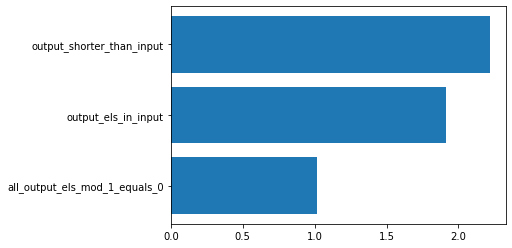

079_1 : list(int) -> list(int)
f([80, 68, 56, 38, 97, 92]) = [56, 80, 97, 92, 68, 38]
f([3, 81, 25, 8, 5, 7, 41, 75, 39]) = [5, 8, 39, 75, 81, 41, 25, 7, 3]
f([46, 85, 95, 0, 38, 4, 66, 35]) = [4, 38, 66, 95, 85, 46, 35, 0]
f([53, 27, 30, 13, 1, 18, 55]) = [13, 27, 53, 55, 30, 18, 1]
f([11, 4, 36, 71, 19, 2, 90, 6, 10, 86]) = [4, 10, 19, 71, 90, 86, 36, 11, 6, 2]
f([57, 99, 54, 0, 80, 76, 20]) = [20, 57, 80, 99, 76, 54, 0]
f([64, 21, 70, 49, 5, 7]) = [7, 49, 70, 64, 21, 5]
f([69, 56, 3, 91, 90, 34]) = [34, 69, 91, 90, 56, 3]
f([54, 8, 67, 72, 79, 24, 33, 1]) = [8, 33, 67, 79, 72, 54, 24, 1]
f([15, 65, 98, 30, 89, 0, 84, 19, 45]) = [15, 30, 65, 89, 98, 84, 45, 19, 0]
f([78, 34, 9, 73, 3, 2, 52, 74, 47, 7]) = [3, 9, 47, 73, 78, 74, 52, 34, 7, 2]


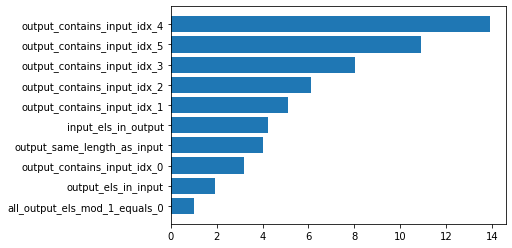

080_1 : list(int) -> list(int)
f([43, 6, 18, 33, 8, 38]) = [38, 18, 6, 8, 33, 43]
f([11, 7, 56, 84, 4, 60, 5]) = [60, 11, 5, 4, 7, 56, 84]
f([1, 67, 23, 63, 59, 36, 45, 21, 5]) = [63, 45, 23, 5, 1, 21, 36, 59, 67]
f([93, 3, 48, 34, 21, 83, 14, 66, 65, 80]) = [83, 66, 48, 21, 3, 14, 34, 65, 80, 93]
f([92, 94, 57, 2, 98, 89, 13, 28]) = [94, 89, 28, 2, 13, 57, 92, 98]
f([53, 52, 51, 17, 39, 7, 48, 72]) = [53, 51, 39, 7, 17, 48, 52, 72]
f([24, 4, 15, 5, 76, 6, 30, 2, 41, 33]) = [41, 30, 15, 5, 2, 4, 6, 24, 33, 76]
f([54, 18, 74, 9, 4, 7, 50, 29, 62]) = [62, 50, 18, 7, 4, 9, 29, 54, 74]
f([86, 0, 73, 1, 40, 33]) = [73, 33, 0, 1, 40, 86]
f([6, 12, 64, 10, 57, 92, 46]) = [64, 46, 10, 6, 12, 57, 92]
f([99, 21, 27, 89, 0, 70, 88]) = [89, 70, 21, 0, 27, 88, 99]


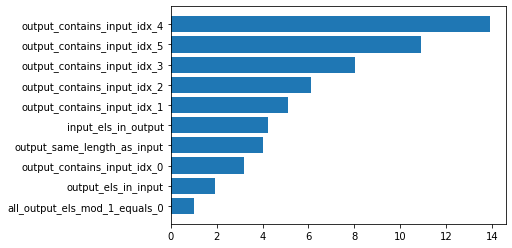

081_1 : list(int) -> list(int)
f([24, 99, 36, 61, 55, 6]) = [24, 6, 36, 61, 55, 99]
f([1, 53, 21, 2, 57, 48, 74, 7]) = [1, 7, 21, 48, 57, 2, 74, 53]
f([16, 97, 40, 26, 35, 65, 63, 59]) = [16, 59, 40, 65, 35, 26, 63, 97]
f([4, 19, 51, 96, 33, 3]) = [4, 3, 51, 96, 33, 19]
f([39, 50, 8, 82, 68, 52, 1, 89, 14, 5]) = [39, 5, 8, 89, 68, 52, 1, 82, 14, 50]
f([55, 8, 10, 98, 88, 3, 41, 74]) = [55, 74, 10, 3, 88, 98, 41, 8]
f([5, 1, 2, 81, 28, 4, 54, 66, 64, 0]) = [5, 0, 2, 66, 28, 4, 54, 81, 64, 1]
f([1, 73, 38, 33, 87, 56, 95, 57]) = [1, 57, 38, 56, 87, 33, 95, 73]
f([93, 71, 95, 0, 21, 69, 4, 43, 78, 9]) = [93, 9, 95, 43, 21, 69, 4, 0, 78, 71]
f([25, 15, 3, 29, 8, 42]) = [25, 42, 3, 29, 8, 15]
f([5, 27, 80, 31, 7, 47]) = [5, 47, 80, 31, 7, 27]


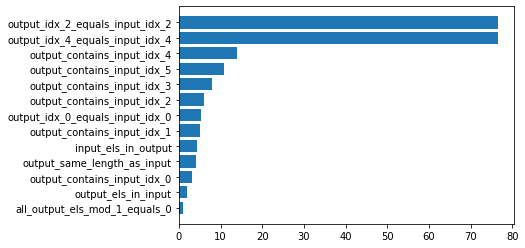

082_1 : list(int) -> list(int)
f([64, 6, 85, 21, 47, 46, 60, 4, 7]) = [85, 46, 7]
f([56, 12, 39, 29, 71, 2, 1, 55, 9, 93]) = [39, 2, 9]
f([20, 92, 79, 36, 7, 34, 26, 25, 1]) = [79, 34, 1]
f([41, 67, 38, 84, 14, 80, 99, 91, 23, 8]) = [38, 80, 23]
f([42, 77, 3, 57, 5, 0, 79, 13, 83, 4]) = [3, 0, 83]
f([30, 2, 22, 4, 56, 50, 0, 9, 1]) = [22, 50, 1]
f([7, 51, 94, 72, 88, 19, 73, 5, 79]) = [94, 19, 79]
f([52, 87, 27, 25, 4, 24, 56, 91, 93]) = [27, 24, 93]
f([10, 44, 12, 11, 8, 4, 89, 9, 82, 7]) = [12, 4, 82]
f([2, 0, 92, 1, 21, 33, 6, 15, 95, 67]) = [92, 33, 95]
f([75, 32, 46, 71, 49, 60, 65, 0, 9, 4]) = [46, 60, 9]


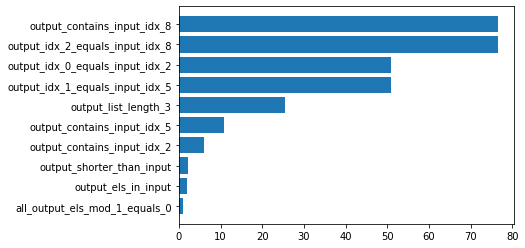

083_1 : list(int) -> list(int)
f([3, 4, 3, 3, 3, 9, 5, 8]) = [2, 3, 4]
f([8, 7, 2, 1, 1, 2, 8, 9, 6]) = [6]
f([2, 2, 2, 2, 5, 2, 5, 4, 4, 5]) = [1, 2, 3, 5]
f([6, 3, 6, 6, 9, 9, 3, 6, 6, 6]) = [2, 3, 7, 8, 9]
f([2, 12, 2, 49, 8, 2, 65, 83, 36]) = [2, 5]
f([5, 10, 9, 4, 5, 5, 4, 9, 9, 4]) = [4, 5]
f([6, 6, 6, 6, 6, 6, 6, 6, 6]) = [1, 2, 3, 4, 5, 6, 7, 8]
f([1, 9, 9, 2, 2, 8, 1, 8, 1]) = [6, 8]
f([1, 1, 5, 5, 5, 1, 5, 5, 1, 5]) = [1, 5, 8]
f([8, 6, 6, 8, 8, 8, 6, 8, 6]) = [3, 4, 5, 7]
f([7, 7, 7, 3, 3, 7, 3, 7, 3, 3]) = [1, 2, 5, 7]


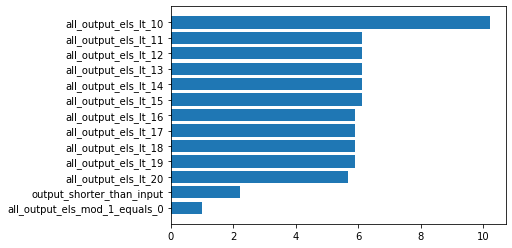

084_1 : list(int) -> list(int)
f([6, 91, 0, 77, 18, 25]) = [91, 77, 25]
f([19, 45, 91, 1, 70, 33, 0, 81, 47, 73]) = [45, 1, 33, 81, 73]
f([82, 7, 87, 9, 2, 31, 67]) = [7, 9, 31]
f([54, 97, 49, 5, 6, 35, 2, 1, 78]) = [97, 5, 35, 1]
f([4, 75, 8, 63, 18, 3, 51, 7]) = [75, 63, 3, 7]
f([7, 43, 66, 79, 68, 33, 8]) = [43, 79, 33]
f([5, 81, 2, 15, 56, 57]) = [81, 15, 57]
f([99, 65, 46, 2, 6, 23, 78, 1, 58]) = [65, 23, 1]
f([7, 89, 8, 21, 2, 71, 20, 67, 37]) = [89, 21, 71, 67]
f([68, 40, 6, 1, 5, 17, 0, 85, 82, 9]) = [1, 17, 85, 9]
f([70, 85, 55, 5, 6, 3, 13, 64]) = [85, 5, 3]


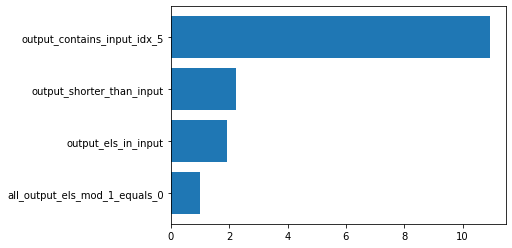

085_1 : list(int) -> list(int)
f([41, 9, 5, 45, 30, 89]) = [41, 89, 89]
f([65, 0, 2, 23, 7, 21, 5, 3, 74]) = [65, 61, 74]
f([16, 19, 36, 12, 4, 6, 8, 2, 0, 23]) = [16, 87, 23]
f([53, 3, 1, 4, 26, 41, 35]) = [53, 75, 35]
f([81, 29, 31, 15, 7, 9, 4, 47]) = [81, 95, 47]
f([98, 30, 11, 47, 1, 3, 0]) = [98, 92, 0]
f([77, 1, 6, 2, 5, 48, 0, 54]) = [77, 62, 54]
f([3, 4, 8, 7, 1, 9, 2, 6, 5, 66]) = [3, 42, 66]
f([49, 36, 26, 8, 9, 0]) = [49, 79, 0]
f([22, 4, 5, 18, 1, 52, 8, 67]) = [22, 88, 67]
f([37, 4, 2, 0, 6, 60]) = [37, 12, 60]


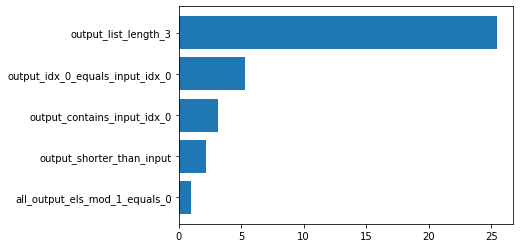

086_1 : list(int) -> list(int)
f([6, 71, 97, 98, 0, 64, 60, 3, 0]) = [71, 97, 98, 64, 60]
f([79, 7, 32, 2, 8, 86, 93, 51, 95, 5]) = [86, 93, 95]
f([31, 30, 53, 74, 9, 12, 12, 5, 31, 31]) = [53, 74]
f([77, 20, 26, 99, 12, 81, 27, 90, 90, 77]) = [99, 81, 90, 90]
f([72, 17, 4, 50, 80, 17, 37, 29, 57]) = [80]
f([61, 42, 5, 1, 0, 54, 87, 77, 9]) = [87, 77]
f([4, 47, 96, 24, 88, 55, 38, 13, 26, 9]) = [47, 96, 24, 88, 55, 38, 13, 26, 9]
f([73, 39, 94, 5, 95, 23, 73, 84, 66]) = [94, 95, 84]
f([30, 38, 7, 2, 4, 58, 6, 62, 10, 83]) = [38, 58, 62, 83]
f([7, 34, 6, 7, 35, 67, 4, 15, 28, 1]) = [34, 35, 67, 15, 28]
f([9, 46, 5, 70, 46, 3, 66, 43, 7]) = [46, 70, 46, 66, 43]


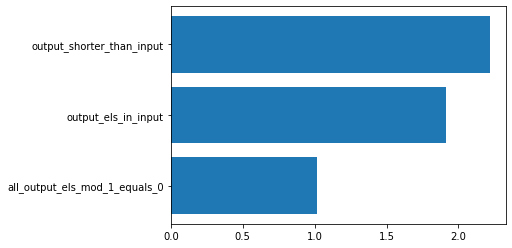

087_1 : list(int) -> list(int)
f([83, 90, 11, 35, 5]) = [83, 90, 11, 35, 5, 0, 83, 90, 11, 35, 5]
f([53, 73]) = [53, 73, 0, 53, 73]
f([77, 7, 22]) = [77, 7, 22, 0, 77, 7, 22]
f([89, 50, 2, 95]) = [89, 50, 2, 95, 0, 89, 50, 2, 95]
f([16]) = [16, 0, 16]
f([97, 47, 39, 94, 92]) = [97, 47, 39, 94, 92, 0, 97, 47, 39, 94, 92]
f([75, 52]) = [75, 52, 0, 75, 52]
f([]) = [0]
f([67, 71, 3, 4, 21]) = [67, 71, 3, 4, 21, 0, 67, 71, 3, 4, 21]
f([33, 58, 61]) = [33, 58, 61, 0, 33, 58, 61]
f([1, 64, 54, 28]) = [1, 64, 54, 28, 0, 1, 64, 54, 28]


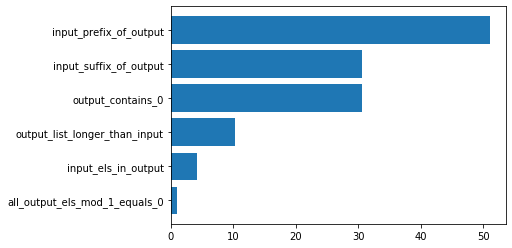

088_1 : list(int) -> list(int)
f([84, 9, 10, 11, 4]) = [1, 1, 0, 0, 0]
f([79, 3, 48, 13, 53, 41, 22, 2, 5]) = [0, 1, 1, 0, 0, 0, 0, 0, 0]
f([95, 28, 86, 2, 21, 6, 40, 55]) = [0, 0, 0, 0, 1, 1, 0, 0]
f([90, 60]) = [1, 1]
f([38, 51, 9]) = [0, 1, 1]
f([96, 4, 93, 44, 2, 63, 9, 54]) = [1, 0, 1, 0, 0, 1, 1, 1]
f([6, 21, 73, 8]) = [1, 1, 0, 0]
f([62, 87, 70, 57, 28, 72, 43]) = [0, 1, 0, 1, 0, 1, 0]
f([39, 75, 94, 6, 33, 85]) = [1, 1, 0, 1, 1, 0]
f([9, 99, 78, 27, 19, 16, 83, 58, 7]) = [1, 1, 1, 1, 0, 0, 0, 0, 0]
f([5, 59, 45, 42, 3, 20, 4, 69, 66, 89]) = [0, 0, 1, 1, 1, 0, 0, 1, 1, 0]


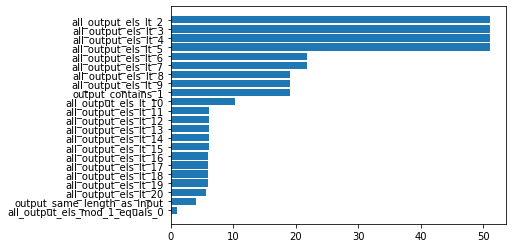

089_1 : list(int) -> list(int)
f([2, 7, 6, 8, 4]) = [2, 3, 4, 5, 6, 7, 8]
f([69, 65, 65, 65]) = [65, 66, 67, 68, 69]
f([98, 98, 98, 98]) = [98]
f([10, 5, 10, 9, 4, 6, 4]) = [4, 5, 6, 7, 8, 9, 10]
f([0, 0, 4, 3, 1, 5, 0, 1]) = [0, 1, 2, 3, 4, 5]
f([3, 7, 5, 3, 9, 9]) = [3, 4, 5, 6, 7, 8, 9]
f([42, 42, 36, 36]) = [36, 37, 38, 39, 40, 41, 42]
f([2, 1, 6, 3]) = [1, 2, 3, 4, 5, 6]
f([73, 79, 79, 73]) = [73, 74, 75, 76, 77, 78, 79]
f([7, 7, 11, 11]) = [7, 8, 9, 10, 11]
f([7, 7, 6, 6]) = [6, 7]


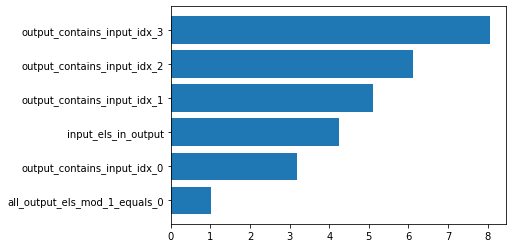

090_1 : list(int) -> list(int)
f([46, 19, 96, 58, 58]) = [46, 48, 50, 52, 54, 56, 58]
f([2, 8, 1, 14, 7, 4, 61, 0, 6]) = [2, 4, 6]
f([66, 3, 6, 46, 82, 88, 17, 1, 93, 76]) = [66, 68, 70, 72, 74, 76]
f([8, 92, 0, 2, 94, 41, 14]) = [8, 10, 12, 14]
f([24, 4, 32]) = [24, 26, 28, 30, 32]
f([8, 70, 4, 12]) = [8, 10, 12]
f([5, 13]) = [5, 7, 9, 11, 13]
f([5, 8, 6, 39, 86, 16, 32, 7, 1, 9]) = [5, 7, 9]
f([0, 2, 6]) = [0, 2, 4, 6]
f([13, 1, 48, 96, 76, 44, 82, 21]) = [13, 15, 17, 19, 21]
f([43, 63, 7, 76, 3, 55]) = [43, 45, 47, 49, 51, 53, 55]


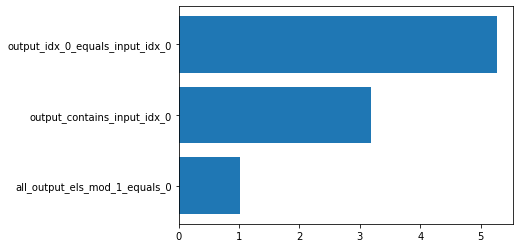

091_1 : list(int) -> list(int)
f([2, 0, 7, 30, 26]) = [30, 30, 30, 26, 26]
f([37]) = [37, 37, 37]
f([1, 12, 7, 9, 8, 23, 0, 6, 15]) = [12, 23, 23, 15]
f([55, 5, 7, 20, 1, 27]) = [55, 55, 55, 55, 55, 20, 20, 27, 27]
f([3, 4, 2]) = []
f([40, 4, 10, 15, 0, 48, 2, 6, 5, 1]) = [40, 40, 40, 40, 10, 15, 48, 48, 48, 48]
f([61, 9, 6, 1]) = [61, 61, 61, 61, 61, 61]
f([8, 14]) = [14]
f([3, 7, 5, 9, 1, 29, 8]) = [29, 29]
f([7, 34, 6, 18, 1, 45, 3, 9]) = [34, 34, 34, 18, 45, 45, 45, 45]
f([0, 8, 5, 73, 4, 2]) = [73, 73, 73, 73, 73, 73, 73]


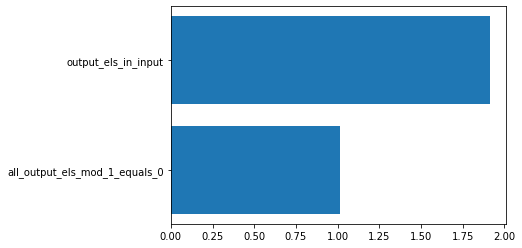

092_1 : list(int) -> list(int)
f([31, 14, 3, 18, 32]) = [3, 1, 0, 1, 3]
f([61, 40, 77, 2]) = [6, 4, 7, 0]
f([92, 47, 62]) = [9, 4, 6]
f([13]) = [1]
f([45, 58]) = [4, 5]
f([69, 82, 6, 9, 49, 89, 5, 43, 25]) = [6, 8, 0, 0, 4, 8, 0, 4, 2]
f([85, 71, 97, 70, 27, 37, 18, 88]) = [8, 7, 9, 7, 2, 3, 1, 8]
f([90, 81, 6, 98, 28, 23, 27, 2, 20, 67]) = [9, 8, 0, 9, 2, 2, 2, 0, 2, 6]
f([74, 59, 44, 91, 35, 55]) = [7, 5, 4, 9, 3, 5]
f([]) = []
f([53, 33, 47, 83, 50, 14, 57]) = [5, 3, 4, 8, 5, 1, 5]


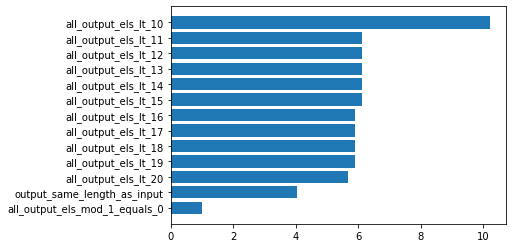

093_1 : list(int) -> list(int)
f([37, 24, 71, 8, 0, 39, 6, 25, 90]) = [6, 8, 24, 25, 37, 39, 71]
f([6, 5, 7, 34, 78, 29, 23, 26, 1, 28]) = [5, 6, 7, 23, 26, 28, 29, 34]
f([53, 60, 91, 61, 12, 3, 68, 8, 79, 96]) = [8, 12, 53, 60, 61, 68, 79, 91]
f([88, 46, 2, 10, 34, 56, 45, 4, 64]) = [4, 10, 34, 45, 46, 56, 64]
f([57, 77, 16, 17, 27, 44, 0, 42, 1]) = [1, 16, 17, 27, 42, 44, 57]
f([30, 77, 10, 7, 9, 55, 80, 83, 1]) = [7, 9, 10, 30, 55, 77, 80]
f([1, 5, 77, 38, 4, 6, 40, 67, 3, 56]) = [3, 4, 5, 6, 38, 40, 56, 67]
f([21, 49, 1, 8, 2, 70, 98, 35, 66]) = [2, 8, 21, 35, 49, 66, 70]
f([1, 3, 53, 92, 0, 38, 26, 65, 94]) = [1, 3, 26, 38, 53, 65, 92]
f([32, 69, 8, 48, 88, 47, 76, 95, 1, 23]) = [8, 23, 32, 47, 48, 69, 76, 88]
f([46, 89, 9, 83, 26, 42, 5, 22, 1, 62]) = [5, 9, 22, 26, 42, 46, 62, 83]


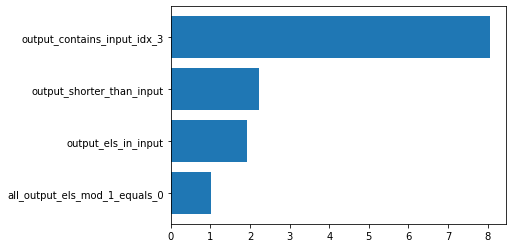

094_1 : list(int) -> list(int)
f([76, 62, 80, 54, 23]) = [5, 23, 54, 80, 62, 76, 5]
f([81, 43]) = [2, 43, 81, 2]
f([1, 63, 21, 16]) = [4, 16, 21, 63, 1, 4]
f([92, 51, 35, 20, 9, 0, 18]) = [7, 18, 0, 9, 20, 35, 51, 92, 7]
f([39, 90, 8]) = [3, 8, 90, 39, 3]
f([36, 7, 17, 34, 42, 65, 41, 12, 2]) = [9, 2, 12, 41, 65, 42, 34, 17, 7, 36, 9]
f([84, 32, 61, 98, 16, 86, 1, 79, 88, 74]) = [10, 74, 88, 79, 1, 86, 16, 98, 61, 32, 84, 10]
f([82]) = [1, 82, 1]
f([40, 6, 70, 56, 25, 99]) = [6, 99, 25, 56, 70, 6, 40, 6]
f([]) = [0, 0]
f([86, 95, 15, 5, 77, 85, 46, 11]) = [8, 11, 46, 85, 77, 5, 15, 95, 86, 8]


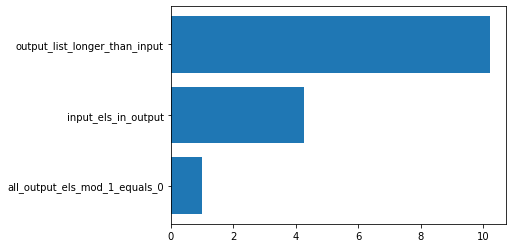

095_1 : list(int) -> list(int)
f([1, 72, 24, 78, 31]) = [1, 23, 68, 42, 99, 71, 31]
f([6, 61, 57, 53, 51, 95, 26]) = [6, 23, 68, 42, 99, 71, 26]
f([79, 7, 54, 1, 38, 84]) = [79, 23, 68, 42, 99, 71, 84]
f([64, 41, 89, 75, 63, 40, 2, 43, 21, 9]) = [64, 23, 68, 42, 99, 71, 9]
f([56, 55, 17, 46, 94, 50, 29, 5, 0]) = [56, 23, 68, 42, 99, 71, 0]
f([82, 81, 90, 89, 2, 87, 55, 1, 10]) = [82, 23, 68, 42, 99, 71, 10]
f([25, 75, 58, 92, 98, 70, 3, 88, 96, 8]) = [25, 23, 68, 42, 99, 71, 8]
f([46, 57, 3, 4]) = [46, 23, 68, 42, 99, 71, 4]
f([12, 9, 31, 97, 37, 7, 48, 77]) = [12, 23, 68, 42, 99, 71, 77]
f([74, 76, 66]) = [74, 23, 68, 42, 99, 71, 66]
f([16, 29, 44, 39, 0, 84, 62]) = [16, 23, 68, 42, 99, 71, 62]


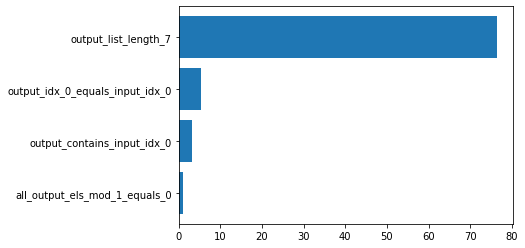

096_1 : list(int) -> list(int)
f([90, 0, 19, 94, 8]) = [17, 38, 82, 90, 0, 19, 94, 8, 1, 55, 27]
f([24, 49, 53]) = [17, 38, 82, 24, 49, 53, 1, 55, 27]
f([86, 77]) = [17, 38, 82, 86, 77, 1, 55, 27]
f([51, 52, 91, 9]) = [17, 38, 82, 51, 52, 91, 9, 1, 55, 27]
f([15]) = [17, 38, 82, 15, 1, 55, 27]
f([7, 47]) = [17, 38, 82, 7, 47, 1, 55, 27]
f([56]) = [17, 38, 82, 56, 1, 55, 27]
f([2, 25, 21, 5]) = [17, 38, 82, 2, 25, 21, 5, 1, 55, 27]
f([4, 45, 96]) = [17, 38, 82, 4, 45, 96, 1, 55, 27]
f([6, 3, 12, 79, 20]) = [17, 38, 82, 6, 3, 12, 79, 20, 1, 55, 27]
f([]) = [17, 38, 82, 1, 55, 27]


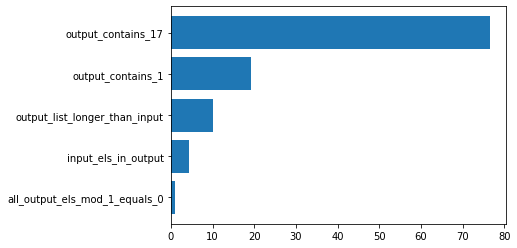

097_1 : list(int) -> list(int)
f([43, 43, 19, 72, 73]) = [2, 2, 1, 1, 1]
f([23, 53, 46, 79, 41, 0, 51, 41, 16, 93]) = [1, 1, 1, 1, 2, 1, 1, 2, 1, 1]
f([70, 70, 70, 70, 42, 42]) = [4, 4, 4, 4, 2, 2]
f([27, 74, 27, 74, 64, 74, 27, 74, 74]) = [3, 5, 3, 5, 1, 5, 3, 5, 5]
f([8, 80, 80]) = [1, 2, 2]
f([88, 68, 34, 68, 88, 88, 88]) = [4, 2, 1, 2, 4, 4, 4]
f([63, 95, 63, 95, 95, 95, 63, 95, 95]) = [3, 6, 3, 6, 6, 6, 3, 6, 6]
f([29, 97, 97, 29, 29, 29, 97, 29, 29, 29]) = [7, 3, 3, 7, 7, 7, 3, 7, 7, 7]
f([25, 9, 90, 99, 52, 67, 67, 94]) = [1, 1, 1, 1, 1, 2, 2, 1]
f([49, 49, 12, 31]) = [2, 2, 1, 1]
f([22, 76, 76, 22, 89, 22]) = [3, 2, 2, 3, 1, 3]


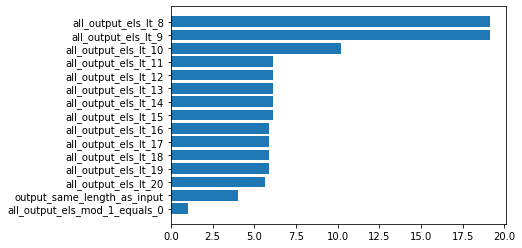

098_1 : list(int) -> list(int)
f([62, 86, 85, 62, 29, 8, 85, 29]) = [86, 85, 62, 29, 8]
f([26, 26, 26, 26, 10, 55, 6, 10, 55, 6]) = [55, 26, 10, 6]
f([18, 65, 98, 98, 98, 18, 18, 98, 65]) = [98, 65, 18]
f([7, 5, 5, 69, 69, 30, 30, 7, 5]) = [69, 30, 7, 5]
f([73, 66, 24, 52, 24, 43, 73, 24, 66, 52]) = [73, 66, 52, 43, 24]
f([12, 0, 60, 12, 67, 0, 12, 60, 9]) = [67, 60, 12, 9, 0]
f([23, 23, 23, 23, 1, 1, 61, 99]) = [99, 61, 23, 1]
f([90, 11, 48, 11, 90, 11, 90, 90, 48]) = [90, 48, 11]
f([42, 25, 76, 25, 25, 42, 25, 76]) = [76, 42, 25]
f([64, 64, 22, 95, 64, 95, 95, 45, 45, 45]) = [95, 64, 45, 22]
f([80, 2, 80, 2, 4, 51, 50, 2, 2, 51]) = [80, 51, 50, 4, 2]


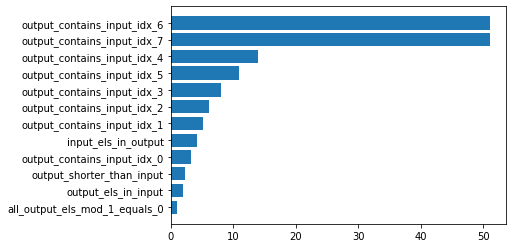

099_1 : list(int) -> list(int)
f([59, 22, 86, 64, 25]) = [1, 22, 2, 25, 3, 59, 4, 64, 5, 86]
f([72, 69, 74, 27]) = [1, 27, 2, 69, 3, 72, 4, 74]
f([6, 99, 46, 0, 96, 49, 77]) = [1, 0, 2, 6, 3, 46, 4, 49, 5, 77, 6, 96, 7, 99]
f([12, 81]) = [1, 12, 2, 81]
f([42]) = [1, 42]
f([38, 41, 14, 8, 54, 98]) = [1, 8, 2, 14, 3, 38, 4, 41, 5, 54, 6, 98]
f([56, 57, 51, 67, 80, 89, 7]) = [1, 7, 2, 51, 3, 56, 4, 57, 5, 67, 6, 80, 7, 89]
f([85, 46, 53, 75, 35, 47, 22]) = [1, 22, 2, 35, 3, 46, 4, 47, 5, 53, 6, 75, 7, 85]
f([66, 78, 10]) = [1, 10, 2, 66, 3, 78]
f([]) = []
f([26, 9, 0, 97, 16, 70]) = [1, 0, 2, 9, 3, 16, 4, 26, 5, 70, 6, 97]


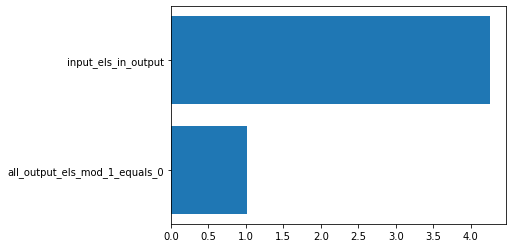

100_1 : list(int) -> list(int)
f([49, 0, 24, 33, 92]) = [0, 2, 3, 4, 9]
f([5, 54, 41, 72]) = [0, 4, 5, 7]
f([68, 5, 91, 59, 36, 18, 71]) = [0, 1, 3, 5, 6, 7, 9]
f([14, 89, 46, 34, 79, 0]) = [0, 1, 3, 4, 7, 8]
f([87, 90, 16]) = [1, 8, 9]
f([77, 11, 52, 92, 24, 8, 9, 47]) = [0, 0, 1, 2, 4, 5, 7, 9]
f([89, 57, 95]) = [5, 8, 9]
f([2, 95, 71, 1, 49, 53, 87, 82, 67]) = [0, 0, 4, 5, 6, 7, 8, 8, 9]
f([45, 12, 20]) = [1, 2, 4]
f([37, 29, 10, 7]) = [0, 1, 2, 3]
f([12, 45, 52, 2, 90, 79, 3, 24, 5, 68]) = [0, 0, 0, 1, 2, 4, 5, 6, 7, 9]


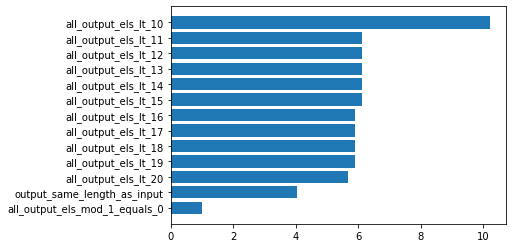

101_1 : list(int) -> list(int)
f([9, 0, 73, 25, 4]) = [73, 25, 0, 4]
f([57, 62, 34, 54, 3, 6, 75, 8, 91, 99]) = [62, 75, 91, 99, 34, 54, 3, 6, 8]
f([51, 20, 95, 39, 52, 53, 78, 2]) = [95, 52, 53, 78, 20, 39, 2]
f([40]) = []
f([43, 41, 22, 48, 77, 82, 18]) = [48, 77, 82, 41, 22, 18]
f([6, 14, 2]) = [14, 2]
f([28, 32, 49, 2, 46, 8, 44, 85, 27, 24]) = [32, 49, 46, 44, 85, 2, 8, 27, 24]
f([29, 38, 9, 72, 51, 26]) = [38, 72, 51, 9, 26]
f([48, 55]) = [55]
f([32, 21, 0, 86, 65, 43, 1, 63, 19]) = [86, 65, 43, 63, 21, 0, 1, 19]
f([9, 71, 7, 5]) = [71, 7, 5]


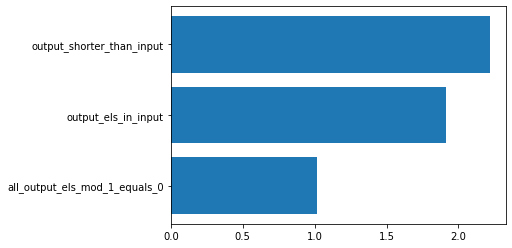

102_1 : list(int) -> list(int)
f([31, 98, 55, 14, 50]) = [2, 4, 5]
f([71, 7, 23, 20, 13, 66, 26, 42, 52]) = [4, 6, 7, 8, 9]
f([91, 78, 5, 46, 15, 33, 0, 62]) = [2, 4, 7, 8]
f([73, 41, 58, 24]) = [3, 4]
f([90, 60, 25]) = [1, 2]
f([11, 9, 83, 86, 76, 1, 38]) = [4, 5, 7]
f([19, 1, 22, 6, 34, 44]) = [3, 4, 5, 6]
f([54, 50, 77, 43, 70, 9, 79, 1, 97, 69]) = [1, 2, 5]
f([56, 40]) = [1, 2]
f([8, 36, 30, 7, 3, 67, 96, 33]) = [1, 2, 3, 7]
f([6, 57, 72, 98, 35, 53, 84, 2, 23]) = [1, 3, 4, 7, 8]


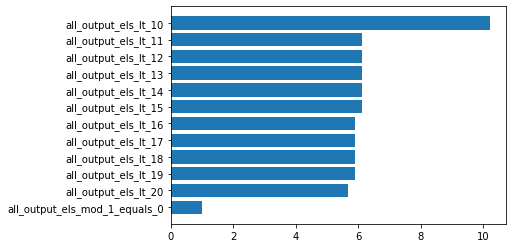

103_1 : list(int) -> list(int)
f([7, 3, 5, 2, 1]) = [1, 2, 3, 4, 5]
f([37, 82]) = [37, 74]
f([23, 92, 84]) = [23, 46, 69]
f([67, 64, 29, 99, 8, 62, 22, 81, 44]) = [8, 16, 24, 32, 40, 48, 56, 64, 72]
f([36, 78, 19, 89]) = [19, 38, 57, 76]
f([91, 31, 8, 77, 9, 7, 56, 13]) = [7, 14, 21, 28, 35, 42, 49, 56]
f([47, 5, 22, 17, 4, 56, 51]) = [4, 8, 12, 16, 20, 24, 28]
f([9, 59, 10, 6, 5, 46, 32, 85, 78, 68]) = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
f([90]) = [90]
f([96, 64, 9, 45, 65, 93]) = [9, 18, 27, 36, 45, 54]
f([]) = []


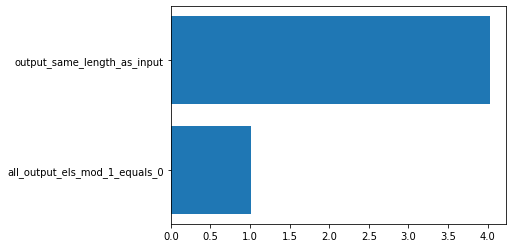

104_1 : list(int) -> list(int)
f([9, 34, 0, 0, 96]) = [34, 0]
f([4, 0, 29, 3, 0, 5, 6, 51]) = [4, 3]
f([29, 28, 0, 2, 0, 64]) = [28, 2]
f([13, 53, 88, 0, 6, 65, 21, 0, 9]) = [88, 21]
f([28, 4, 97, 34, 14, 0, 0, 1, 0, 88]) = [14, 0, 1]
f([6, 0, 92, 40, 0, 4, 96, 7, 16]) = [6, 40]
f([5, 0, 9, 0, 8, 9, 4]) = [5, 9]
f([67, 3, 0, 58, 0, 85, 71, 9, 13, 24]) = [3, 58]
f([18, 0, 0]) = [18, 0]
f([49, 77, 4, 8, 5, 2, 0, 0]) = [2, 0]
f([84, 0, 0, 91]) = [84, 0]


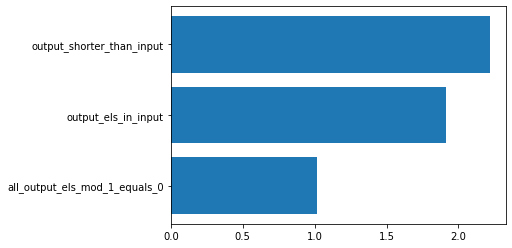

105_1 : list(int) -> list(int)
f([4, 1, 9, 20, 3, 11, 70]) = [80]
f([99, 46, 7, 5, 2, 8, 5, 12]) = [96]
f([15, 73, 98, 8, 53, 1, 95, 9, 4]) = [32]
f([67, 19, 23, 7, 2, 12, 8, 23, 97, 6]) = [96]
f([83, 37, 16, 21, 0, 6, 2, 87, 7]) = [0]
f([1, 62, 35, 11, 5, 3, 4, 97, 7, 8]) = [32]
f([9, 79, 4, 58, 79, 4, 79]) = [16]
f([37, 42, 5, 63, 8, 8, 43]) = [64]
f([2, 57, 12, 53, 4, 98, 15, 6, 78, 3]) = [48]
f([30, 35, 12, 58, 42, 3, 8, 7]) = [96]
f([8, 7, 90, 5, 9, 71, 4, 1, 2]) = [32]


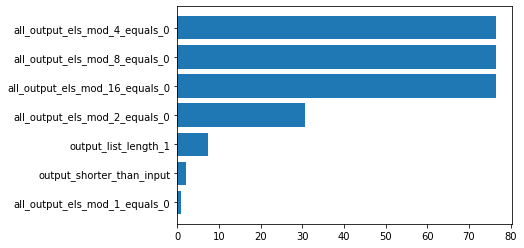

106_1 : list(int) -> list(int)
f([43, 3, 80, 40, 29, 31]) = [40, 29, 31]
f([1, 63, 2, 7, 48, 9, 97, 4]) = [2, 7, 48, 9, 4]
f([39, 80, 95, 9, 44, 77, 2, 33, 75, 6]) = [44, 77, 75]
f([6, 90, 25, 9, 18, 0, 7]) = [25, 9, 18, 7]
f([87, 5, 71, 7, 3, 19, 8, 22, 56]) = [71, 7, 19, 8, 22, 56]
f([92, 59, 1, 7, 15, 85, 68, 30, 62]) = [85, 68, 62]
f([19, 0, 95, 42, 20, 4, 74, 13, 9, 27]) = [4, 13, 9]
f([64, 8, 61, 37, 9, 38, 15, 59, 2, 5]) = [61, 37, 9, 38, 15, 59]
f([96, 61, 5, 89, 3, 79, 86, 97]) = [89, 79, 86]
f([98, 7, 3, 51, 88, 82, 2, 25]) = [51, 88, 82, 25]
f([2, 57, 8, 23, 7, 95, 34]) = [8, 23, 7, 34]


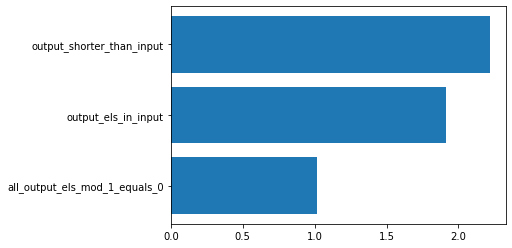

107_1 : list(int) -> list(int)
f([7, 6, 9, 79, 46]) = [53, 85, 18, 85, 53]
f([14, 8, 22]) = [36, 16, 36]
f([1, 31, 84, 4, 68, 89]) = [90, 99, 88, 88, 99, 90]
f([19, 1, 97, 62]) = [81, 98, 98, 81]
f([5, 13, 51]) = [56, 26, 56]
f([57, 28, 3, 8, 6, 39]) = [96, 34, 11, 11, 34, 96]
f([0, 74, 41, 35, 7, 66]) = [66, 81, 76, 76, 81, 66]
f([1, 2, 43, 47]) = [48, 45, 45, 48]
f([60, 21, 10]) = [70, 42, 70]
f([50, 24, 26, 3, 1]) = [51, 27, 52, 27, 51]
f([40, 80, 12, 32]) = [72, 92, 92, 72]


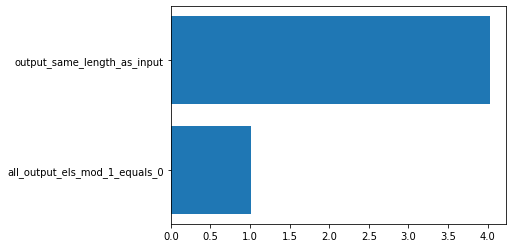

108_1 : list(int) -> list(int)
f([3, 1, 5, 35, 65, 7, 84, 4]) = [65, 7, 84, 4]
f([28, 69, 5, 58, 51, 66, 16, 9, 7]) = [5, 58, 51, 66, 16, 9, 7]
f([23, 9, 22, 0, 76, 3, 5, 75, 2, 1]) = [1]
f([2, 24, 92, 14, 95, 54, 79, 42, 71, 8]) = [92, 14, 95, 54, 79, 42, 71, 8]
f([94, 8, 68, 86, 7, 95, 56, 0, 6]) = [86, 7, 95, 56, 0, 6]
f([85, 19, 48, 14, 5, 68, 0, 75, 58, 9]) = [19, 48, 14, 5, 68, 0, 75, 58, 9]
f([0, 3, 8, 7, 86, 4, 5, 1]) = [1]
f([9, 29, 41, 6, 50, 1, 4, 15, 3, 0]) = []
f([2, 35, 58, 4, 6, 37, 10, 1, 75, 5]) = [37, 10, 1, 75, 5]
f([2, 4, 78, 0, 9, 6, 7, 66, 3]) = [7, 66, 3]
f([1, 27, 68, 4, 7, 3, 37, 34, 5, 2]) = [5, 2]


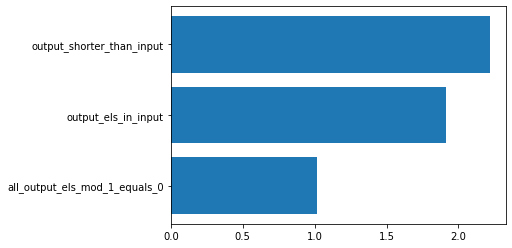

109_1 : list(int) -> list(int)
f([34, 2, 3, 96, 64]) = [2, 3, 98, 34, 64, 96]
f([87, 76, 1, 38, 85, 83]) = [1, 38, 88, 76, 83, 85, 87]
f([9, 67, 94, 5]) = [5, 9, 99, 67, 94]
f([39, 86, 23, 8, 7, 31]) = [7, 8, 93, 23, 31, 39, 86]
f([25, 72, 49]) = [25, 49, 97, 72]
f([54, 11, 12, 74, 78]) = [11, 12, 89, 54, 74, 78]
f([42, 59, 53, 38]) = [38, 42, 97, 53, 59]
f([6, 33, 16, 51, 44]) = [6, 16, 57, 33, 44, 51]
f([55, 10, 69, 3, 41, 77]) = [3, 10, 80, 41, 55, 69, 77]
f([35, 0, 65, 19]) = [0, 19, 65, 35, 65]
f([52, 20, 8]) = [8, 20, 60, 52]


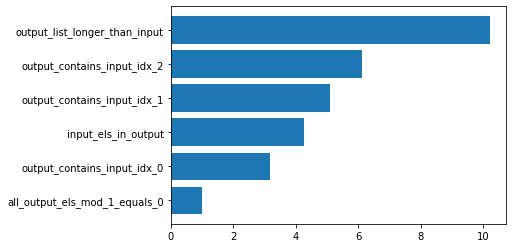

110_1 : list(int) -> list(int)
f([2, 9, 57, 6, 9, 6]) = [2, 6, 9, 57, 6]
f([4, 0, 50, 4, 19, 34, 50, 34, 4, 19]) = [4, 0, 50, 19, 19, 34]
f([8, 79, 23, 60, 74, 49, 71, 0, 76]) = [8, 79, 23, 60, 74, 49, 71, 76, 0, 76]
f([2, 99, 87, 2, 87, 99, 87]) = [2, 87, 99, 87]
f([7, 65, 3, 68, 73, 66, 9, 5]) = [7, 65, 3, 68, 73, 66, 5, 9, 5]
f([2, 50, 1, 2, 32, 32, 2, 53, 21]) = [2, 21, 50, 1, 32, 53, 21]
f([9, 2, 12, 75, 99, 1, 81, 86, 8, 61]) = [9, 2, 12, 75, 99, 1, 81, 86, 61, 8, 61]
f([2, 3, 3, 77, 2, 3, 77, 3, 2, 77]) = [2, 77, 3, 77]
f([2, 8, 74, 56, 62, 33, 33, 3]) = [2, 3, 8, 74, 56, 62, 33, 3]
f([1, 44, 1, 1, 1, 44, 44, 44, 1, 1]) = [1, 1, 44]
f([3, 91, 40, 91, 40, 91, 39, 40, 3, 3]) = [3, 91, 3, 40, 39]


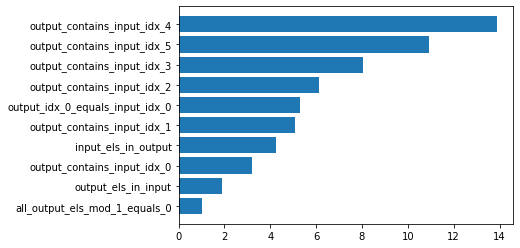

111_1 : list(int) -> list(int)
f([22, 1, 7, 65, 21, 77]) = [77, 21, 65, 65, 21, 7, 1, 22]
f([94, 72, 79, 4, 47, 46]) = [46, 47, 4, 4, 47, 79, 72, 94]
f([97, 59, 0, 39, 8, 48, 53, 4]) = [4, 53, 48, 8, 39, 39, 8, 0, 59, 97]
f([12, 5, 18, 62, 78, 28, 31, 68]) = [68, 31, 28, 78, 62, 62, 78, 18, 5, 12]
f([49, 6, 23, 92, 45, 36, 75]) = [75, 36, 45, 92, 92, 45, 23, 6, 49]
f([94, 4, 13, 20, 90, 33]) = [33, 90, 20, 20, 90, 13, 4, 94]
f([70, 4, 7, 79, 2, 61, 15]) = [15, 61, 2, 79, 79, 2, 7, 4, 70]
f([67, 57, 23, 66, 93, 42, 29, 58]) = [58, 29, 42, 93, 66, 66, 93, 23, 57, 67]
f([56, 50, 86, 37, 5, 74, 62, 9]) = [9, 62, 74, 5, 37, 37, 5, 86, 50, 56]
f([5, 6, 85, 92, 10, 71]) = [71, 10, 92, 92, 10, 85, 6, 5]
f([54, 26, 3, 1, 16, 31, 77]) = [77, 31, 16, 1, 1, 16, 3, 26, 54]


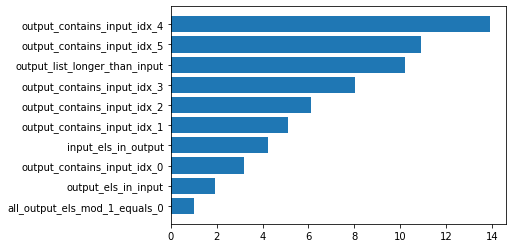

112_1 : list(int) -> list(int)
f([5, 9, 7, 80, 82]) = [5, 9, 3, 3, 3, 7, 80, 82]
f([6, 54, 74, 26, 8, 95]) = [6, 54, 3, 3, 3, 74, 26, 8, 95]
f([59, 96, 98, 25, 87, 86, 4]) = [59, 96, 3, 3, 3, 98, 25, 87, 86, 4]
f([72, 15, 39]) = [72, 15, 3, 3, 3, 39]
f([2, 65, 53, 68]) = [2, 65, 3, 3, 3, 53, 68]
f([0, 34, 9, 85, 67, 33, 75]) = [0, 34, 3, 3, 3, 9, 85, 67, 33, 75]
f([62, 22, 99, 5, 30, 90, 1]) = [62, 22, 3, 3, 3, 99, 5, 30, 90, 1]
f([98, 39, 16, 93, 89, 38]) = [98, 39, 3, 3, 3, 16, 93, 89, 38]
f([64, 92, 14]) = [64, 92, 3, 3, 3, 14]
f([56, 66, 37, 49]) = [56, 66, 3, 3, 3, 37, 49]
f([31, 0, 32, 43, 58]) = [31, 0, 3, 3, 3, 32, 43, 58]


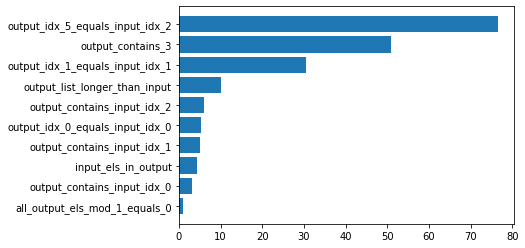

113_1 : list(int) -> list(int)
f([16, 25, 95, 44, 39]) = [16, 25, 39]
f([58, 7, 48, 1, 43, 8, 3, 84, 53, 0]) = [0, 1, 3]
f([62, 5, 41, 7, 68, 65, 3, 32, 18]) = [3, 5, 7]
f([83, 23, 2, 52, 61, 59]) = [2, 23, 52]
f([86, 19, 21, 17, 40, 45, 13]) = [13, 17, 19]
f([46, 1, 33]) = [1, 33, 46]
f([72, 81, 60, 85, 95, 4, 84, 11, 67]) = [4, 11, 60]
f([91, 86, 24, 79, 80, 20]) = [20, 24, 79]
f([98, 30, 88, 8, 66, 29, 10]) = [8, 10, 29]
f([21, 6, 32, 31, 65, 3, 77, 83]) = [3, 6, 21]
f([54, 9, 94, 15]) = [9, 15, 54]


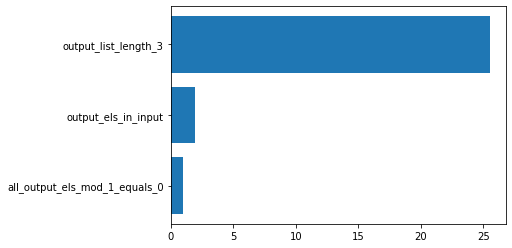

114_1 : list(int) -> list(int)
f([4, 47, 54, 54, 4, 4]) = [47, 54, 54, 4]
f([7, 6, 30, 64, 8, 41, 41, 36, 56]) = [6, 30, 64, 8, 41, 41, 56]
f([2, 7, 23, 63, 63, 23, 93, 78]) = [7, 63, 63, 23, 93, 78]
f([3, 3, 21, 32, 21, 21, 98]) = [3, 21, 21, 21, 98]
f([9, 27, 19, 1, 64, 61, 61, 67, 27, 65]) = [27, 19, 1, 64, 61, 61, 67, 27]
f([6, 19, 47, 77, 69, 74, 5, 61, 9]) = [19, 47, 77, 69, 74, 61, 9]
f([2, 58, 82, 82, 68, 2, 60, 82, 8]) = [58, 82, 68, 2, 60, 82, 8]
f([5, 30, 44, 90, 12, 88, 44, 46, 5, 9]) = [30, 44, 90, 12, 44, 46, 5, 9]
f([8, 22, 4, 2, 0, 8, 52, 2, 0, 56]) = [22, 4, 2, 0, 8, 52, 2, 56]
f([1, 7, 5, 8, 1, 10, 2, 92, 6, 68]) = [5, 8, 1, 10, 2, 92, 6, 68]
f([2, 76, 72, 9, 76, 32, 5, 76, 2, 49]) = [76, 9, 76, 32, 5, 76, 2, 49]


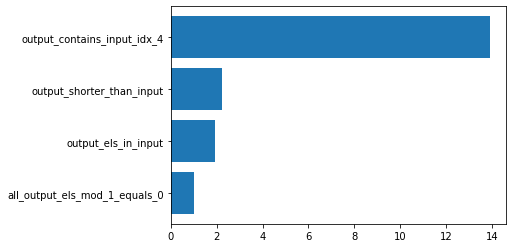

115_1 : list(int) -> list(int)
f([3, 59, 55, 17, 3]) = [59, 55, 5, 3]
f([8, 4, 0, 43, 95, 70, 1, 34, 0, 4]) = [4, 0, 43, 95, 70, 1, 34, 10, 4]
f([5, 74, 35, 35, 36, 78, 36, 35]) = [74, 35, 35, 36, 8, 36, 35]
f([5, 31, 60, 84, 7, 89, 96]) = [31, 60, 84, 7, 7, 96]
f([6, 25, 8, 72, 79, 27, 24, 2, 94]) = [25, 8, 72, 79, 27, 9, 2, 94]
f([9, 99, 47, 53, 99, 67, 8, 99, 47, 99]) = [99, 47, 53, 99, 67, 8, 99, 47, 10]
f([3, 3, 37, 82, 26, 37, 26, 97]) = [3, 37, 8, 26, 37, 26, 97]
f([7, 33, 49, 87, 44, 5, 2, 0, 68]) = [33, 49, 87, 44, 5, 2, 9, 68]
f([4, 20, 14, 29, 21, 0]) = [20, 14, 29, 6, 0]
f([2, 19, 2, 80]) = [19, 4, 80]
f([1, 49, 32]) = [3, 32]


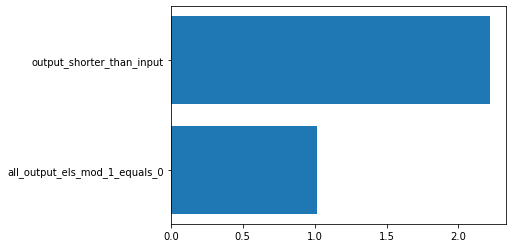

116_1 : list(int) -> list(int)
f([77, 74, 26, 9, 31]) = [9, 26, 31, 77, 74]
f([54, 86, 4, 66, 25, 13, 84]) = [4, 13, 25, 54, 66, 86, 84]
f([91, 20, 3, 82]) = [3, 20, 82, 91]
f([62, 32, 78, 53, 42, 8, 6]) = [8, 6, 32, 42, 53, 62, 78]
f([22, 38, 58, 30, 92, 14]) = [14, 22, 38, 30, 58, 92]
f([17, 9, 6, 56, 33, 4]) = [9, 6, 4, 17, 33, 56]
f([87, 35, 1, 3, 49, 43]) = [1, 3, 35, 49, 43, 87]
f([18, 64, 70, 47, 5]) = [5, 18, 47, 64, 70]
f([69, 73, 72, 81, 23]) = [23, 69, 73, 72, 81]
f([82, 88, 8, 46]) = [8, 46, 82, 88]
f([90, 29, 21, 48, 2, 60, 7]) = [2, 7, 29, 21, 48, 60, 90]


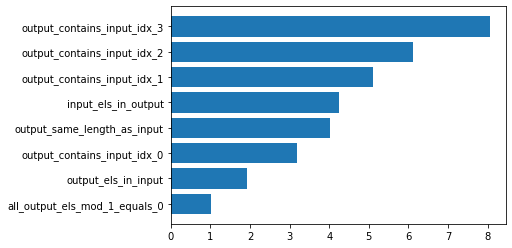

117_1 : list(int) -> list(int)
f([34, 33, 80, 4, 79]) = [80, 33, 34, 4, 79]
f([36, 72, 45, 67, 50, 90]) = [50, 90, 72, 45, 36, 67]
f([66, 52, 15, 32]) = [52, 32, 15, 66]
f([83, 30, 28, 38, 21, 0, 5]) = [30, 0, 21, 83, 5, 28, 38]
f([63, 42, 1, 69, 61, 75, 46]) = [1, 61, 42, 63, 75, 46, 69]
f([1, 8, 9, 86]) = [1, 86, 8, 9]
f([64, 7, 27, 6, 15, 37]) = [64, 15, 6, 7, 27, 37]
f([3, 95, 89, 82, 14]) = [82, 3, 14, 95, 89]
f([71, 94, 48, 51, 5]) = [71, 51, 94, 5, 48]
f([68, 2, 57, 65]) = [2, 65, 57, 68]
f([85, 54, 43, 58, 0, 77, 72]) = [0, 72, 43, 54, 85, 77, 58]


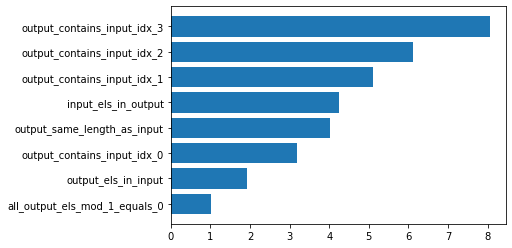

118_1 : list(int) -> list(int)
f([93, 93, 52, 93, 99, 99, 71, 52]) = [93, 93]
f([90, 61, 9, 9, 37, 90, 30, 3, 3]) = [90]
f([55, 2, 55, 6, 6, 19, 53, 8, 55, 55]) = [55, 55, 55]
f([15, 25, 73, 6, 7, 20, 67, 13, 23]) = []
f([45, 27, 1, 45, 1, 27, 45, 45, 45, 1]) = [45, 45, 45, 45]
f([2, 59, 7, 85, 92, 92, 1, 95, 85]) = []
f([60, 8, 60, 60, 60, 60, 60, 8]) = [60, 60, 60, 60, 60]
f([0, 0, 7, 0, 0, 0, 0, 0, 0]) = [0, 0, 0, 0, 0, 0, 0]
f([69, 69, 69, 69, 69, 69, 69, 69, 69, 69]) = [69, 69, 69, 69, 69, 69, 69, 69, 69]
f([51, 51, 66, 51, 51, 51, 51, 51]) = [51, 51, 51, 51, 51, 51]
f([17, 3, 17, 17, 17, 17, 17, 17, 17, 17]) = [17, 17, 17, 17, 17, 17, 17, 17]


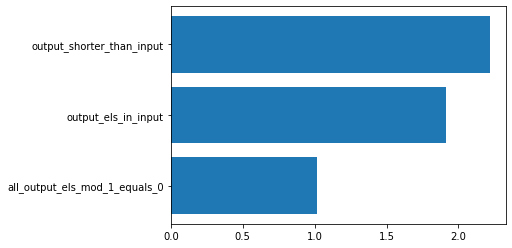

119_1 : list(int) -> list(int)
f([42, 0, 46, 12, 8, 58, 50]) = [42, 46, 8, 50]
f([7, 93, 99, 86, 30, 97, 60, 62, 57, 17]) = [93, 86, 97, 62, 17]
f([3, 52, 78, 9, 94, 54, 90, 89, 37, 14]) = [52, 9, 54, 89, 14]
f([65, 2, 66, 47, 28, 71, 9, 5]) = [2, 47, 71, 5]
f([81, 22, 85, 82, 36, 59, 16, 8, 45]) = [81, 85, 36, 16, 45]
f([83, 27, 2, 69, 67, 1, 99]) = [83, 2, 67, 99]
f([8, 74, 0, 3, 55, 4, 35, 78, 70]) = [8, 0, 55, 35, 70]
f([4, 53, 98, 54, 22, 57, 6, 7, 15]) = [4, 98, 22, 6, 15]
f([18, 55, 9, 84, 54, 61, 26, 7]) = [55, 84, 61, 7]
f([5, 2, 76, 1, 3, 95, 9, 72, 75, 31]) = [2, 1, 95, 72, 31]
f([51, 13, 85, 4, 79, 90, 56]) = [51, 85, 79, 56]


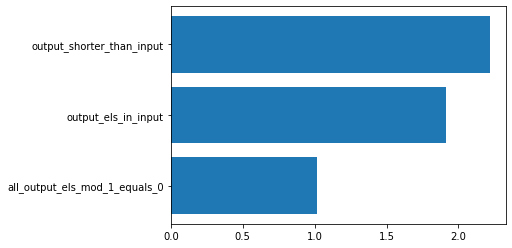

120_1 : list(int) -> list(int)
f([4, 8, 3, 29, 15]) = [12, 24, 9, 87, 45]
f([5, 39]) = [10, 78]
f([19]) = [57]
f([1, 4, 0, 9, 25, 6, 2, 28, 7]) = [3, 12, 0, 27, 75, 18, 6, 84, 21]
f([43, 23, 11, 5, 8, 30, 41, 2]) = [86, 46, 22, 10, 16, 60, 82, 4]
f([38, 35, 9, 4]) = [76, 70, 18, 8]
f([9, 29, 7]) = [27, 87, 21]
f([25, 33, 1, 30, 5, 0, 7]) = [75, 99, 3, 90, 15, 0, 21]
f([4, 37, 6, 3, 0, 32]) = [8, 74, 12, 6, 0, 64]
f([1, 48]) = [2, 96]
f([7, 6, 36, 4, 0, 3, 1, 2, 11, 5]) = [14, 12, 72, 8, 0, 6, 2, 4, 22, 10]


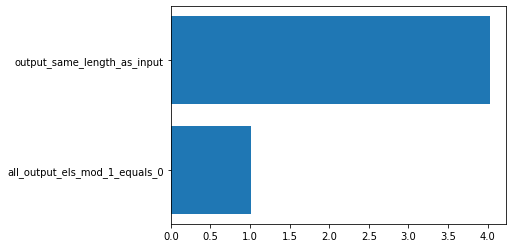

121_1 : list(int) -> list(int)
f([46, 91, 4, 9, 1, 67, 5]) = [50]
f([65, 44, 3, 1, 91, 7, 41, 43, 20]) = [64]
f([55, 26, 34, 95, 19, 6, 0, 79, 8, 53]) = [74]
f([81, 21, 0, 32, 16, 4, 2, 28, 33]) = [82]
f([6, 13, 7, 10, 47, 75, 80, 93]) = [96]
f([4, 97, 6, 61, 46, 2, 41, 27]) = [58]
f([63, 10, 77, 7, 0, 72, 59]) = [82]
f([32, 7, 39, 9, 95, 12, 1, 49]) = [44]
f([15, 5, 7, 6, 3, 9, 58]) = [64]
f([35, 33, 18, 52, 7, 25, 4, 83, 2]) = [76]
f([5, 48, 29, 57, 8, 6, 45, 0, 79, 24]) = [86]


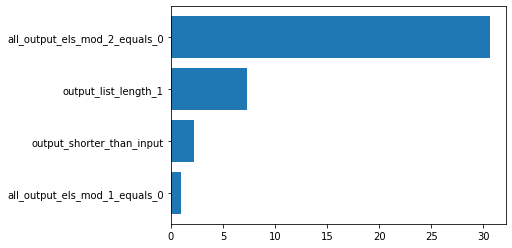

122_1 : list(int) -> list(int)
f([34, 83, 11, 82, 31]) = [5, 5, 5, 5, 5]
f([74, 59, 14, 50]) = [4, 4, 4, 4]
f([25]) = [1]
f([58, 80]) = [2, 2]
f([22, 92, 28]) = [3, 3, 3]
f([]) = []
f([23, 57, 4, 5, 2, 1, 56, 49, 99]) = [9, 9, 9, 9, 9, 9, 9, 9, 9]
f([73, 20, 0, 82, 39, 81, 4, 31, 94, 53]) = [10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
f([61, 88, 94, 68, 44, 0, 29]) = [7, 7, 7, 7, 7, 7, 7]
f([47, 87, 42, 46, 13, 70, 0, 75]) = [8, 8, 8, 8, 8, 8, 8, 8]
f([42, 16, 35, 90, 63, 65]) = [6, 6, 6, 6, 6, 6]


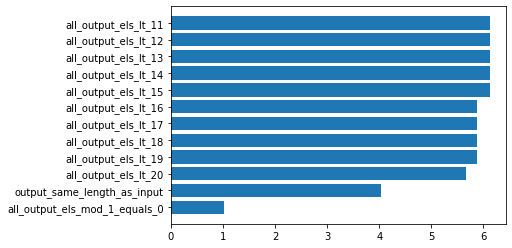

123_1 : list(int) -> list(int)
f([4, 69, 95, 9, 49]) = [40, 96, 59, 90, 94]
f([68, 99, 24]) = [86, 99, 42]
f([54, 62, 9, 7, 32, 57, 45, 92, 47]) = [45, 26, 90, 70, 23, 75, 54, 29, 74]
f([15, 17, 25, 19]) = [51, 71, 52, 91]
f([18, 3, 6, 11, 58, 48]) = [81, 30, 60, 11, 85, 84]
f([43, 4, 12, 49, 3, 38, 2, 64, 73, 10]) = [34, 40, 21, 94, 30, 83, 20, 46, 37, 1]
f([5, 61, 72, 8, 6, 98, 22, 0, 50]) = [50, 16, 27, 80, 60, 89, 22, 0, 5]
f([32, 13, 52]) = [23, 31, 25]
f([65, 36, 28, 7, 41, 39, 93]) = [56, 63, 82, 70, 14, 93, 39]
f([9, 76, 3, 4, 35, 77, 73, 91]) = [90, 67, 30, 40, 53, 77, 37, 19]
f([87, 58, 78, 1, 51]) = [78, 85, 87, 10, 15]


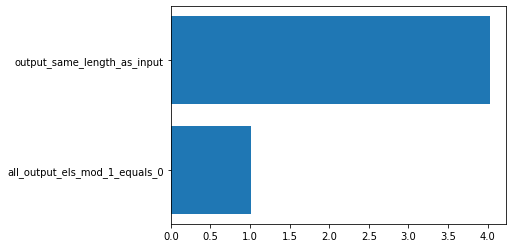

124_1 : list(int) -> list(int)
f([80, 31, 6, 69, 38]) = [38, 6, 80, 31, 69]
f([29, 17, 49, 99, 41, 93, 0, 2, 5, 3]) = [3, 2, 93, 99, 17, 29, 49, 41, 0, 5]
f([68, 4, 34, 17, 24, 85, 82, 7, 52]) = [52, 82, 24, 34, 68, 4, 17, 85, 7]
f([87, 73, 92, 8]) = [8, 73, 87, 92]
f([10, 65, 16, 45, 97, 22, 30]) = [30, 97, 16, 10, 65, 45, 22]
f([7, 99, 63, 94, 1, 90, 62]) = [62, 1, 63, 7, 99, 94, 90]
f([4, 9, 28, 36, 32, 39, 11, 38, 7, 79]) = [79, 38, 39, 36, 9, 4, 28, 32, 11, 7]
f([47, 90, 3, 27, 0, 76, 12, 9, 98]) = [98, 12, 0, 3, 47, 90, 27, 76, 9]
f([51, 60, 8, 26, 48, 83]) = [83, 26, 60, 51, 8, 48]
f([84, 67, 48, 42, 98, 72, 4, 14]) = [14, 72, 42, 67, 84, 48, 98, 4]
f([95, 75, 37, 78]) = [78, 75, 95, 37]


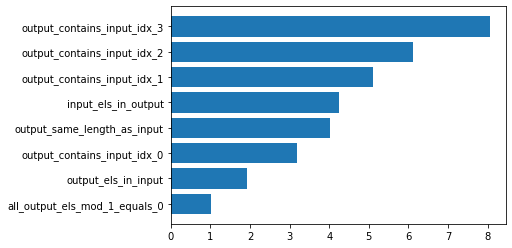

125_1 : list(int) -> list(int)
f([8, 28, 97, 66, 46]) = [97]
f([53, 95, 39, 49, 62, 74, 5, 4]) = [39, 49, 62, 74]
f([11, 87, 44, 41, 6, 27]) = [44, 41]
f([2, 40, 29, 81, 54, 48, 76, 15, 8, 80]) = [29, 81, 54, 48, 76, 15]
f([13, 38, 91, 64, 16, 0, 5]) = [91, 64, 16]
f([32, 47, 97, 99, 52, 25]) = [97, 99]
f([6, 77, 58, 22, 7, 16, 15]) = [58, 22, 7]
f([5, 80, 82, 6, 26, 38, 0, 7, 63]) = [82, 6, 26, 38, 0]
f([92, 36, 13, 57, 37, 51, 6, 9, 22]) = [13, 57, 37, 51, 6]
f([94, 96, 9, 56, 45, 2, 55, 30]) = [9, 56, 45, 2]
f([33, 23, 8, 4, 17, 75, 3, 35, 1, 5]) = [8, 4, 17, 75, 3, 35]


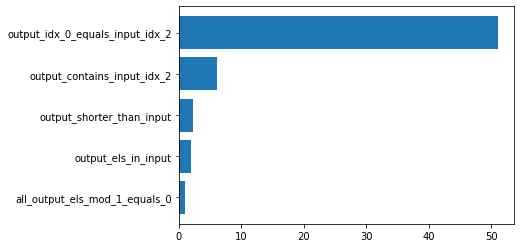

126_1 : list(int) -> list(int)
f([1, 15, 15, 1, 15, 1, 1]) = [15, 15, 1, 15, 1]
f([6, 67, 67, 67, 6, 67, 1, 1]) = [1]
f([5, 64, 64, 5, 83, 83, 83, 83, 8, 5]) = []
f([1, 14, 61, 49, 2, 12, 98, 4, 4]) = [14, 61, 49, 2]
f([1, 5, 3, 96, 37, 35, 68, 5, 23, 0]) = [5, 3, 96, 37, 35, 68, 5, 23, 0]
f([3, 47, 32, 72, 71, 3, 7, 7, 4, 1]) = [72, 71, 3, 7, 7, 4]
f([4, 1, 14, 5, 14, 2, 14, 2]) = [14, 2]
f([7, 3, 42, 0, 9, 67, 4, 13, 2]) = []
f([2, 2, 12, 3, 7, 7, 2, 12, 12, 7]) = [12]
f([0, 5, 57, 29, 8, 95, 58, 57, 1, 3]) = [0, 5, 57, 29, 8, 95, 58]
f([1, 6, 42, 8, 96, 43, 46, 49, 49, 6]) = [6, 42, 8]


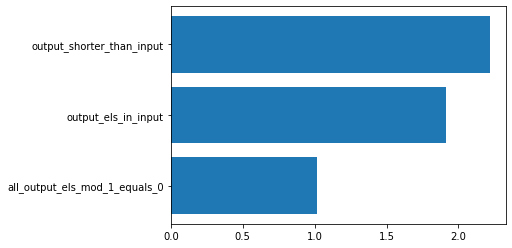

127_1 : list(int) -> list(int)
f([9, 66, 10, 0, 43, 66, 9]) = [9, 66, 10, 43, 0]
f([85, 39, 0, 33, 26, 27, 83, 18]) = [85, 18, 39, 83, 0, 27, 33, 26]
f([40, 75, 49, 75, 40, 49, 49, 68, 49]) = [40, 49, 75, 68]
f([55, 17, 20, 89, 22, 5, 20, 6, 65, 1]) = [55, 1, 17, 65, 20, 6, 89, 22, 5]
f([65, 99, 86, 86, 28, 42, 7, 42, 53, 86]) = [65, 86, 99, 53, 42, 7, 28]
f([63, 63, 63, 63, 63, 63, 63, 63]) = [63]
f([56, 56, 4, 4, 4, 4, 56, 4, 4, 4]) = [56, 4]
f([51, 60, 88, 15, 15, 98, 6, 51, 98, 6]) = [51, 6, 60, 98, 88, 15]
f([]) = []
f([77, 2, 34, 1, 47, 37, 10, 50, 21, 12]) = [77, 12, 2, 21, 34, 50, 1, 10, 47, 37]
f([57, 36, 36, 57, 36, 0, 57, 0, 57]) = [57, 36, 0]


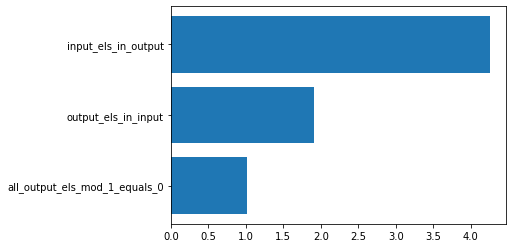

128_1 : list(int) -> list(int)
f([42, 22, 22, 42, 42]) = [1, 1, 2, 2, 3]
f([11, 11, 6, 11, 11, 6, 6, 6]) = [1, 2, 1, 3, 4, 2, 3, 4]
f([80, 80, 80, 80]) = [1, 2, 3, 4]
f([84, 84, 84]) = [1, 2, 3]
f([58, 58]) = [1, 2]
f([20, 20, 20, 20]) = [1, 2, 3, 4]
f([43, 43, 43, 43, 95, 95]) = [1, 2, 3, 4, 1, 2]
f([72, 53, 53, 53, 72, 72, 72, 53]) = [1, 1, 2, 3, 2, 3, 4, 4]
f([41, 8, 41, 41, 8, 8, 99, 41, 99, 99]) = [1, 1, 2, 3, 2, 3, 1, 4, 2, 3]
f([33, 33, 45, 33, 33, 45, 45]) = [1, 2, 1, 3, 4, 2, 3]
f([60, 38, 60, 38, 38, 60, 60, 60, 38]) = [1, 1, 2, 2, 3, 3, 4, 5, 4]


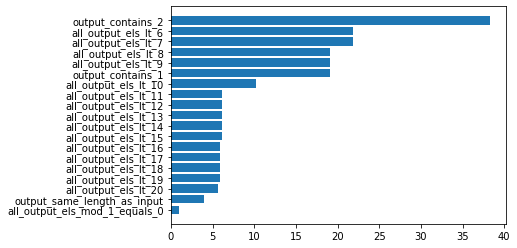

129_1 : list(int) -> list(int)
f([7, 58, 5, 9, 21, 22, 51]) = [51, 22, 21, 9, 5, 58, 7]
f([4, 89, 16, 33, 53, 3, 6, 1, 76]) = [76, 1, 6, 3]
f([5, 18, 99, 7, 7, 99, 81, 11]) = [11, 81, 99, 7, 7]
f([1, 3, 49, 5, 2, 15, 77, 68, 27, 13]) = [13]
f([9, 2, 72, 56, 1, 0, 26, 69, 95, 86]) = [86, 95, 69, 26, 0, 1, 56, 72, 2]
f([3, 29, 7, 35, 63, 1, 2, 6, 70]) = [70, 6, 2]
f([1, 6, 79, 63, 18, 8, 93, 35, 79]) = [79]
f([0, 5, 49, 4, 81, 1, 6, 14, 9, 16]) = []
f([8, 9, 86, 0, 5, 49, 72, 6, 36, 18]) = [18, 36, 6, 72, 49, 5, 0, 86]
f([2, 7, 48, 3, 8, 34, 1, 6, 4]) = [4, 6]
f([6, 14, 7, 5, 70, 80, 8, 27, 99, 3]) = [3, 99, 27, 8, 80, 70]


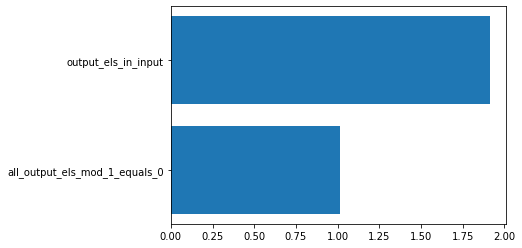

130_1 : list(int) -> list(int)
f([8, 6, 7, 12, 2]) = [2, 4, 6, 8, 10, 12]
f([44, 48]) = [44, 46, 48]
f([5, 1, 7]) = [1, 3, 5, 7]
f([16, 6, 9, 4]) = [4, 6, 8, 10, 12, 14, 16]
f([78, 86]) = [78, 80, 82, 84, 86]
f([63, 70, 71]) = [63, 65, 67, 69, 71]
f([13, 9, 3, 8]) = [3, 5, 7, 9, 11, 13]
f([0, 8, 2]) = [0, 2, 4, 6, 8]
f([5, 9, 8, 6]) = [5, 7, 9]
f([6, 14]) = [6, 8, 10, 12, 14]
f([83, 87]) = [83, 85, 87]


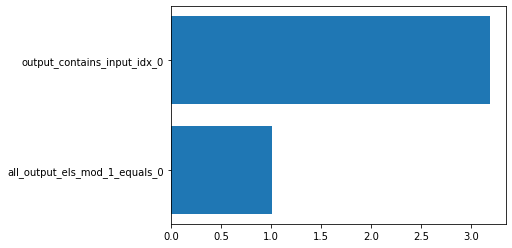

131_1 : list(int) -> list(int)
f([80, 5, 98, 32, 98, 80, 98]) = [1, 1, 2, 3]
f([92, 92, 92, 92, 21, 21, 92, 92]) = [2, 6]
f([78, 34, 78, 78, 34, 34, 4, 4, 34, 4]) = [3, 3, 4]
f([33, 31, 71, 33, 59, 64, 31, 31, 59, 7]) = [1, 1, 1, 2, 2, 3]
f([38, 38, 38, 38, 38, 38, 38, 38, 38]) = [9]
f([94, 0, 2, 60, 23, 15, 15, 69, 67, 52]) = [1, 1, 1, 1, 1, 1, 1, 1, 2]
f([27, 8, 43, 6, 57, 6, 13, 74, 7]) = [1, 1, 1, 1, 1, 1, 1, 2]
f([48, 80, 88, 48, 13, 48, 29, 13, 88, 29]) = [1, 2, 2, 2, 3]
f([68, 86, 86, 41, 82, 2, 75, 5, 41]) = [1, 1, 1, 1, 1, 2, 2]
f([44, 44, 44, 44, 44, 44, 44, 44, 44, 44]) = [10]
f([9, 6, 26, 4, 82, 17, 55, 0, 8, 3]) = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


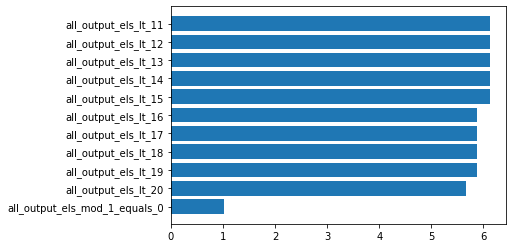

132_1 : list(int) -> list(int)
f([72, 14, 69, 77, 8]) = [48]
f([94, 60, 0, 89, 41]) = [56]
f([18, 10, 16, 4]) = [12]
f([13, 22, 68]) = [34]
f([52, 75, 71]) = [66]
f([5, 85, 4, 99, 84]) = [55]
f([9, 96, 3]) = [36]
f([43, 2, 46, 80, 24]) = [39]
f([53, 95, 97]) = [81]
f([7, 90, 88, 32]) = [54]
f([51, 20, 6, 86]) = [40]


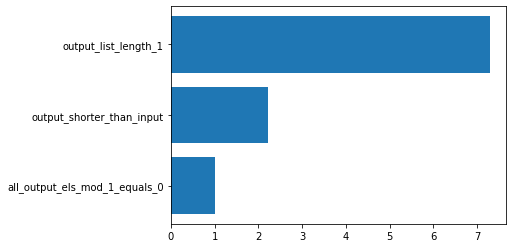

133_1 : list(int) -> list(int)
f([2, 82, 82, 52, 87, 41, 87]) = [1, 2, 1, 2, 1]
f([4, 63, 9, 68, 62, 67, 9, 22, 56]) = [1, 1, 2, 1, 1, 1, 1, 1]
f([34, 34, 34, 34, 34, 34, 34, 34, 34, 34]) = [10]
f([71, 17, 71, 71, 71, 17, 71, 17]) = [5, 3]
f([33, 55, 84, 84, 64, 33, 55, 64, 6, 18]) = [2, 2, 2, 2, 1, 1]
f([3, 4, 59, 9, 61, 33, 90, 7, 6, 60]) = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
f([8, 35, 10, 8, 10, 64, 3, 68, 68, 82]) = [2, 1, 2, 1, 1, 2, 1]
f([92, 15, 6, 92, 6, 13, 15, 92, 13]) = [3, 2, 2, 2]
f([93, 93, 93, 93, 93, 93, 93, 93, 93]) = [9]
f([32, 18, 32, 18, 18, 8, 32, 8, 32, 18]) = [4, 4, 2]
f([73, 37, 31, 66, 37, 12, 70, 4, 0, 5]) = [1, 2, 1, 1, 1, 1, 1, 1, 1]


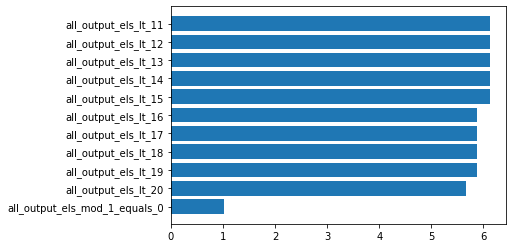

134_1 : list(int) -> list(int)
f([66, 0, 66, 58, 25, 0, 25, 92]) = [66, 0, 25]
f([48, 1, 6, 94, 96, 65, 82, 45, 90, 5]) = []
f([7, 26, 84, 6, 62, 77, 2, 84, 10, 80]) = [84]
f([3, 22, 5, 24, 1, 22, 21, 19, 5, 2]) = [22, 5]
f([4, 16, 85, 16, 8, 16, 4, 85, 85]) = [4, 16, 16, 85, 85]
f([31, 31, 31, 31, 3, 31, 3, 3, 3, 31]) = [31, 31, 31, 31, 31, 3, 3, 3]
f([4, 0, 64, 9, 40, 7, 64, 45]) = [64]
f([39, 39, 23, 39, 79, 27, 6, 79, 27, 44]) = [39, 39, 79, 27]
f([52, 7, 71, 71, 52, 52, 7, 71, 7]) = [52, 52, 7, 7, 71, 71]
f([69, 69, 69, 69, 69, 69, 69, 69, 69, 69]) = [69, 69, 69, 69, 69, 69, 69, 69, 69]
f([75, 75, 75, 75, 75, 75, 80, 80, 80]) = [75, 75, 75, 75, 75, 80, 80]


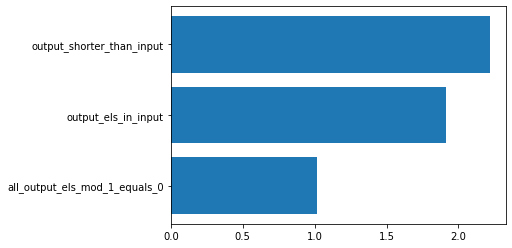

135_1 : list(int) -> list(int)
f([8, 7, 5, 6, 15]) = [8, 7, 6, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
f([46, 43, 42]) = [46, 45, 44, 43, 42]
f([0, 4, 7, 6]) = [0, 1, 2, 3, 4, 5, 6, 7, 6]
f([1, 5, 7]) = [1, 2, 3, 4, 5, 6, 7]
f([6, 9]) = [6, 7, 8, 9]
f([9, 8, 6, 2]) = [9, 8, 7, 6, 5, 4, 3, 2]
f([4, 0, 6, 5]) = [4, 3, 2, 1, 0, 1, 2, 3, 4, 5, 6, 5]
f([5, 10, 6]) = [5, 6, 7, 8, 9, 10, 9, 8, 7, 6]
f([20, 7, 8]) = [20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 8]
f([4, 2, 7, 6, 8]) = [4, 3, 2, 3, 4, 5, 6, 7, 6, 7, 8]
f([7, 8, 4]) = [7, 8, 7, 6, 5, 4]


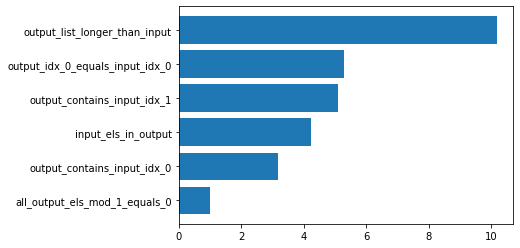

136_1 : list(int) -> list(int)
f([18, 37, 3, 50, 13, 95, 9]) = [9, 25]
f([25, 24, 7, 5, 38, 52, 74, 94]) = [12, 19, 26, 37, 47]
f([92, 84, 9, 23, 7, 87, 73, 28, 90]) = [46, 42, 14, 45]
f([64, 80, 8, 20, 2, 7, 6, 0, 44, 12]) = [32, 40, 4, 10, 1, 3, 0, 22, 6]
f([86, 53, 99, 5, 30, 65, 72, 93, 43]) = [43, 15, 36]
f([50, 1, 94, 4, 22, 5, 0, 6, 72, 97]) = [25, 47, 2, 11, 0, 3, 36]
f([1, 98, 43, 23, 87, 85, 53]) = [49]
f([38, 79, 92, 6, 30, 57, 0, 8]) = [19, 46, 3, 15, 0, 4]
f([70, 80, 0, 5, 8, 28, 7, 32, 38, 4]) = [35, 40, 0, 4, 14, 16, 19, 2]
f([85, 44, 8, 79, 9, 67, 5, 49, 43]) = [22, 4]
f([90, 16, 7, 65, 2, 9, 34]) = [45, 8, 1, 17]


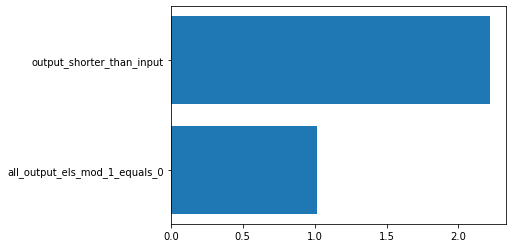

137_1 : list(int) -> list(int)
f([14, 1, 3, 2, 14, 3]) = [14, 15, 18, 20]
f([7, 15, 2, 1, 0, 20, 20, 0, 4]) = [7, 22, 24, 25, 25, 45, 49]
f([1, 4, 1, 7, 0, 3, 2, 0]) = [1, 5, 12, 12, 15, 17]
f([0, 7, 4, 3, 8, 16, 16, 6, 2, 0]) = [0, 7, 11, 14, 22, 38, 44, 46]
f([6, 7, 8, 5, 7, 9, 7]) = [6, 13, 21, 26, 35]
f([2, 1, 1, 8, 15, 9, 8, 6, 2]) = [2, 3, 11, 26, 35, 41]
f([0, 0, 0, 0, 0, 0]) = [0]
f([4, 6, 1, 6, 1, 0, 9]) = [4, 10, 11, 11, 20]
f([12, 6, 6, 7, 12, 6]) = [12, 18, 25]
f([20, 1, 20, 1, 1, 20]) = [20, 21]
f([7, 5, 1, 5, 0, 7, 5]) = [7, 12, 13, 13]


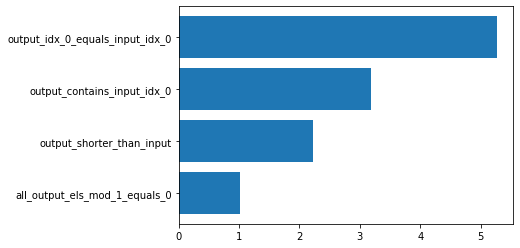

138_1 : list(int) -> list(int)
f([8, 0, 5, 12, 0, 2]) = [8, 5, 12, 2]
f([8, 19, 7, 8, 8, 8, 7, 7, 7, 7]) = [19]
f([0, 1, 18, 9, 9, 0, 15, 6, 1]) = [18, 15, 6]
f([0, 17, 4, 8, 4, 10, 1]) = [0, 17, 8, 10, 1]
f([5, 3, 1, 6, 6, 3, 4, 4]) = [5, 1]
f([0, 16, 6, 5, 6, 0, 7]) = [16, 5, 7]
f([14, 14, 14, 14, 14, 14, 14, 14, 14, 14]) = []
f([2, 1, 2, 0, 5, 10]) = [1, 0, 5, 10]
f([4, 1, 8, 4, 8, 8, 14, 4, 8, 4]) = [1, 14]
f([3, 9, 8, 0, 0, 0, 8, 8, 0]) = [3, 9]
f([5, 0, 5, 4, 8, 0, 0, 15, 8]) = [4, 15]


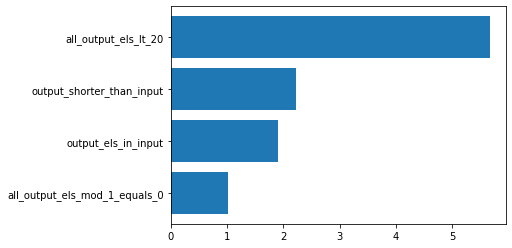

139_1 : list(int) -> list(int)
f([86, 27, 88, 71, 54, 86, 71, 54]) = [3]
f([25, 37, 28, 43, 14, 14, 6, 25, 51]) = [2]
f([13, 84, 48, 60, 84, 60, 21, 21, 96]) = [3]
f([52, 44, 0, 70, 7, 77, 18, 79, 44, 67]) = [1]
f([75, 75, 22, 31, 9, 22, 62, 31, 12, 4]) = [3]
f([59, 2, 26, 26, 9, 11, 97, 99]) = [1]
f([94, 41, 74, 72, 82, 13, 49, 13, 72, 52]) = [2]
f([81, 20, 83, 95, 56, 4, 9, 95]) = [1]
f([91, 3, 91, 55, 63, 91, 63, 55, 91]) = [5]
f([92, 62, 29, 57, 5, 7, 20, 40, 57]) = [1]
f([23, 0, 94, 94, 80, 3, 7, 23, 23, 38]) = [3]


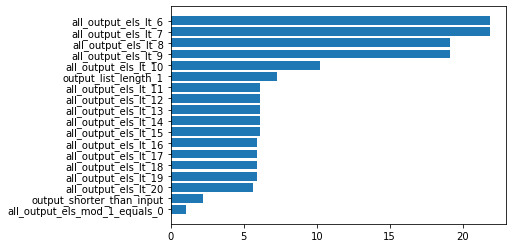

140_1 : list(int) -> list(int)
f([21, 7, 7, 7, 83, 21, 29]) = [3]
f([8, 65, 5, 34, 8, 59, 18, 4]) = [2]
f([60, 24, 51, 8, 72, 9, 98, 2, 65, 1]) = [0]
f([0, 5, 95, 3, 7, 91, 7]) = [2]
f([68, 3, 94, 22, 99, 16, 93, 2, 9]) = [1]
f([73, 64, 34, 3, 9, 1, 2, 9, 33]) = [2]
f([7, 75, 7, 7, 7, 7, 75]) = [5]
f([10, 77, 10, 79, 22, 4, 97, 65, 8, 72]) = [2]
f([6, 6, 7, 7, 7, 48, 7]) = [4]
f([9, 62, 26, 9, 96, 2, 7, 5, 46]) = [2]
f([0, 45, 8, 6, 7, 82, 8, 8]) = [3]


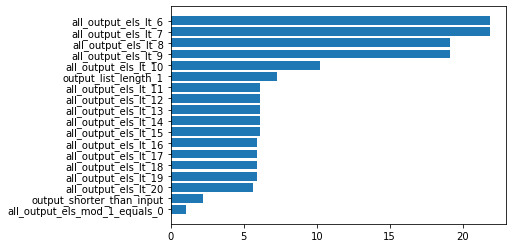

141_1 : list(int) -> list(int)
f([49, 87, 13, 67, 4, 5, 8]) = [2]
f([0, 45, 84, 90, 72, 8, 68, 72, 30]) = [8]
f([5, 53, 61, 57, 7, 63, 12, 3]) = [1]
f([22, 22, 10, 6, 28, 26, 26, 16, 22, 26]) = [10]
f([3, 44, 36, 82, 4, 6, 2, 14, 32, 32]) = [9]
f([8, 2, 64, 87, 9, 0, 50, 36, 4]) = [7]
f([2, 29, 33, 4, 0, 9, 85, 5]) = [3]
f([11, 7, 86, 0, 3, 76, 38, 32, 80, 5]) = [6]
f([8, 30, 47, 62, 3, 1, 28, 55, 31, 9]) = [4]
f([37, 5, 56, 42, 2, 82, 23, 25, 6]) = [5]
f([89, 49, 5, 39, 9, 3, 83]) = [0]


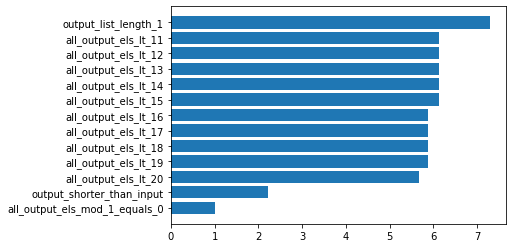

142_1 : list(int) -> list(int)
f([43, 43, 43, 17, 17, 4, 17, 17]) = [17, 43, 4]
f([32, 81, 53, 32, 1, 32, 81, 53, 81, 1]) = [32, 81, 53, 1]
f([66, 0, 6, 66, 31, 66, 28, 28]) = [6, 31, 66, 28, 0]
f([60, 92, 9, 18, 35, 9, 10, 60, 10, 92]) = [10, 35, 92, 60, 18, 9]
f([51, 46, 74, 46, 75, 48, 89, 89, 51]) = [48, 74, 89, 75, 51, 46]
f([85, 21, 26, 99, 21, 26, 99, 21, 21]) = [26, 99, 85, 21]
f([19, 55, 19, 69, 72, 19, 69, 55]) = [55, 72, 69, 19]
f([2, 8, 2, 70, 42, 8, 8, 42, 62]) = [8, 62, 70, 42, 2]
f([16, 40, 16, 5, 5, 40, 98, 96, 96, 16]) = [16, 96, 98, 40, 5]
f([56, 56, 3, 23, 56, 3, 3, 3, 3, 23]) = [23, 56, 3]
f([41, 88, 47, 22, 6, 47, 84, 88]) = [22, 47, 88, 84, 41, 6]


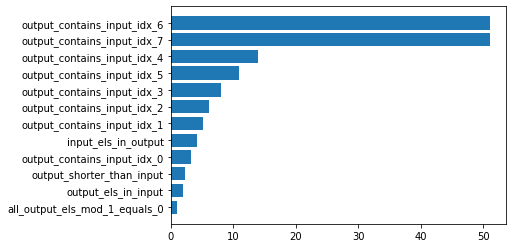

143_1 : list(int) -> list(int)
f([6, 92, 34, 20, 69, 34, 0]) = [1]
f([19, 5, 4, 33, 17, 3, 19, 45, 93, 7]) = [9]
f([24, 21, 15, 94, 32, 47, 2, 3]) = [4]
f([2, 25, 18, 8, 46, 29, 38, 99]) = [3]
f([75, 8, 55, 5, 42, 62, 67, 89, 43]) = [6]
f([44, 24, 62, 42, 4, 0, 8, 2, 54]) = [0]
f([0, 7, 33, 44, 6, 76, 2, 8, 4]) = [2]
f([81, 65, 7, 5, 6, 9, 8, 4]) = [5]
f([48, 5, 63, 1, 13, 5, 7, 26, 3, 9]) = [8]
f([85, 9, 5, 95, 33, 75, 67]) = [7]
f([7, 83, 35, 33, 3, 9, 67, 69, 45, 79]) = [10]


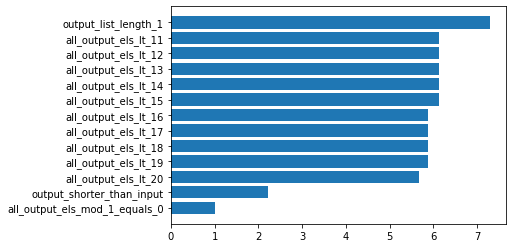

144_1 : list(int) -> list(int)
f([52, 3, 3, 3, 3, 3, 52]) = [5]
f([3, 3, 3, 3, 3, 14, 14, 3, 14]) = [6]
f([28, 79, 1, 3, 55, 42, 70, 60, 7, 67]) = [1]
f([92, 11, 94, 7, 2, 1, 18, 8, 89, 5]) = [0]
f([3, 43, 3, 3, 27, 3, 7, 69]) = [4]
f([3, 3, 3, 3, 3, 3, 3, 3, 3, 3]) = [10]
f([3, 3, 3, 3, 3, 3, 3, 3, 3]) = [9]
f([3, 5, 49, 3, 96, 1, 2, 80, 3]) = [3]
f([3, 3, 3, 3, 3, 3, 3, 3]) = [8]
f([3, 1, 79, 68, 15, 6, 74, 3, 4, 0]) = [2]
f([3, 3, 3, 3, 3, 3, 3]) = [7]


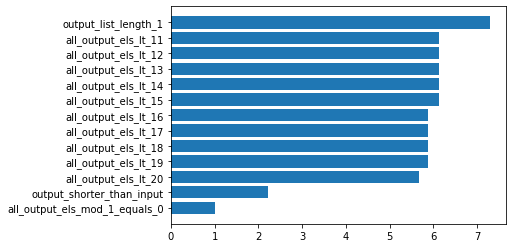

145_1 : list(int) -> list(int)
f([5, 5, 5, 5, 5, 41, 5]) = [5]
f([67, 23, 84, 30, 18, 80, 1, 69, 28]) = [0]
f([1, 40, 1, 3, 51, 9, 91, 1, 2, 1]) = [3]
f([59, 87, 59, 91, 53, 0, 2, 62, 76, 61]) = [1]
f([18, 49, 72, 7, 71, 8, 27, 97]) = [0]
f([1, 4, 1, 0, 76, 1, 2, 44, 90, 69]) = [2]
f([17, 17, 17, 17, 17, 17, 17, 17, 17]) = [8]
f([45, 45, 45, 45, 45, 45, 45, 45]) = [7]
f([34, 34, 5, 34, 54, 34, 34, 34, 34]) = [6]
f([48, 48, 48, 48, 48, 48, 48, 48, 48, 48]) = [9]
f([28, 28, 28, 0, 8, 28, 2, 28, 6, 57]) = [4]


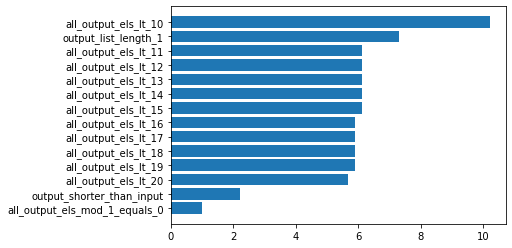

146_1 : list(int) -> list(int)
f([76, 5, 19, 22, 19, 3, 9]) = [6]
f([98, 64, 57, 6, 45, 79, 2, 59, 92]) = [9]
f([99, 77, 42, 26, 75, 7, 90, 38]) = [8]
f([]) = [0]
f([37, 87, 33, 24, 18, 2, 17, 71, 47, 66]) = [10]
f([78, 44, 0, 86, 23, 82, 8]) = [7]
f([13, 71, 13, 71, 71, 13, 13]) = [2]
f([74, 74, 74, 74, 74, 74, 74]) = [1]
f([49, 90, 30, 1, 90, 36, 49]) = [5]
f([69, 95, 95, 95, 69, 88, 88]) = [3]
f([25, 60, 25, 37, 63, 37, 25, 63]) = [4]


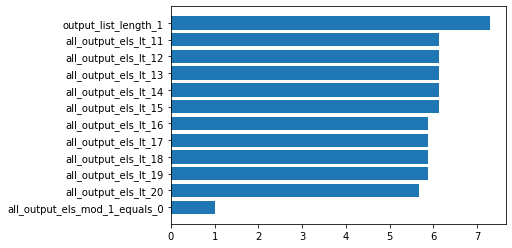

147_1 : list(int) -> list(int)
f([5, 26, 7, 23, 0, 93, 0, 18, 1]) = [5, 26, 7, 23]
f([1, 71, 89, 0, 71, 46, 8, 87, 0, 7]) = [1, 71, 89]
f([9, 86, 0, 60, 69, 53, 1, 0, 6, 60]) = [9, 86]
f([4, 0, 80, 87, 87, 0, 45, 2, 4]) = [4]
f([84, 0, 20, 0, 63, 63, 20, 20, 20]) = [84]
f([78, 38, 0, 78, 3, 1, 78, 0, 6, 1]) = [78, 38]
f([1, 1, 38, 7, 0, 7, 38, 0, 7, 38]) = [1, 1, 38, 7]
f([68, 0, 65, 0, 8, 8, 65, 65, 68]) = [68]
f([90, 7, 90, 0, 6, 6, 7, 0, 90]) = [90, 7, 90]
f([30, 30, 0, 30, 33, 30, 5, 33, 0, 0]) = [30, 30]
f([80, 5, 9, 0, 0, 80, 9, 80, 5]) = [80, 5, 9]


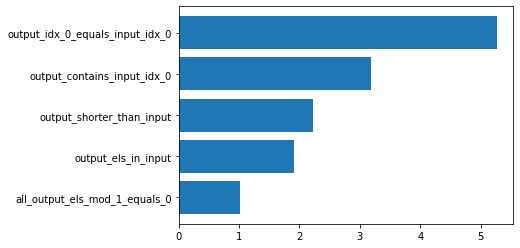

148_1 : list(int) -> list(int)
f([9, 0, 4, 8, 0, 2, 46, 96, 30]) = [2, 46, 96, 30]
f([97, 0, 46, 8, 89, 0, 17, 3, 17, 7]) = [17, 3, 17, 7]
f([0, 1, 5, 1, 32, 5, 41, 5, 0, 87]) = [87]
f([70, 6, 11, 0, 37, 9, 9, 0, 13, 54]) = [13, 54]
f([86, 7, 99, 0, 99, 0, 3, 4, 38]) = [3, 4, 38]
f([45, 0, 45, 5, 5, 5, 5, 0, 5]) = [5]
f([94, 65, 8, 0, 44, 7, 0, 7, 8]) = [7, 8]
f([89, 44, 0, 89, 44, 7, 7, 89, 0, 7]) = [7]
f([1, 50, 0, 93, 50, 0, 1, 93, 75, 1]) = [1, 93, 75, 1]
f([14, 0, 53, 13, 7, 32, 0, 3, 6, 37]) = [3, 6, 37]
f([0, 11, 15, 54, 0, 54, 4, 44, 9]) = [54, 4, 44, 9]


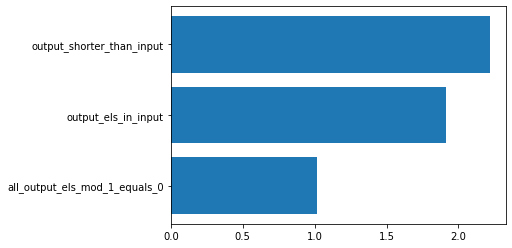

149_1 : list(int) -> list(int)
f([64, 0, 50, 1, 50, 1, 0, 1, 64]) = [64, 50, 1]
f([8, 0, 4, 68, 68, 78, 0, 68, 25, 68]) = [8, 4, 68]
f([94, 9, 3, 5, 5, 0, 5, 0, 95]) = [94, 5, 95]
f([2, 3, 67, 0, 44, 0, 6, 91, 76]) = [2, 44, 6]
f([42, 37, 80, 0, 47, 13, 80, 0, 80, 42]) = [42, 47, 80]
f([34, 0, 63, 42, 0, 34, 34, 33, 9, 42]) = [34, 63, 34]
f([1, 2, 0, 83, 4, 2, 0, 2, 4]) = [1, 83, 2]
f([10, 1, 1, 0, 10, 10, 3, 0, 8]) = [10, 10, 8]
f([71, 0, 71, 47, 0, 87, 5, 25, 47]) = [71, 71, 87]
f([94, 55, 0, 1, 94, 40, 55, 0, 39, 39]) = [94, 1, 39]
f([86, 6, 6, 53, 13, 0, 3, 5, 0, 8]) = [86, 3, 8]


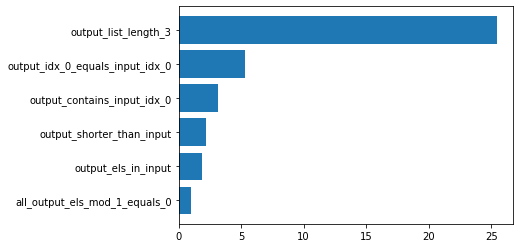

150_1 : list(int) -> list(int)
f([38, 0, 38, 3, 60, 60, 0, 3, 38]) = [38, 60, 60, 3, 38, 38, 3]
f([4, 8, 0, 77, 0, 25, 66, 77, 40, 66]) = [8, 4, 77, 66, 40, 77, 66, 25]
f([7, 27, 0, 8, 5, 0, 86, 24, 4, 4]) = [27, 7, 5, 8, 4, 4, 24, 86]
f([6, 14, 75, 0, 1, 75, 75, 0, 0]) = [75, 14, 6, 75, 75, 1]
f([2, 0, 62, 80, 54, 49, 0, 6, 4]) = [2, 49, 54, 80, 62, 4, 6]
f([30, 7, 90, 0, 90, 0, 90, 2, 83, 4]) = [90, 7, 30, 90, 4, 83, 2, 90]
f([5, 8, 0, 73, 1, 12, 0, 40, 73]) = [8, 5, 12, 1, 73, 73, 40]
f([62, 1, 0, 7, 0, 9, 1, 33, 33]) = [1, 62, 7, 33, 33, 1, 9]
f([59, 56, 0, 59, 59, 3, 56, 0, 59, 3]) = [56, 59, 56, 3, 59, 59, 3, 59]
f([0, 54, 5, 3, 0, 75, 52, 75, 44]) = [3, 5, 54, 44, 75, 52, 75]
f([81, 5, 45, 45, 34, 0, 81, 0, 6, 43]) = [34, 45, 45, 5, 81, 81, 43, 6]


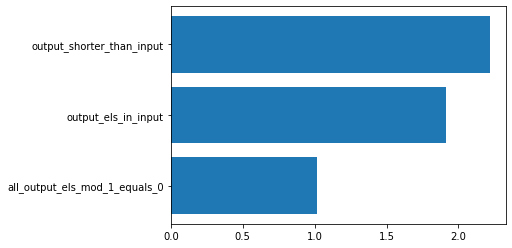

In [10]:
def plot_properties(taskIdx):
    _, _, sortedPropAndScores = createSimilarTasksDf(
        tasks,
        taskIdx,
        helmholtzFrontiers, 
        properties,
        helmholtzTasksPropertyMatrix, 
        propertyToPriorDistribution, 
        valuesToInt=valuesToInt,
        onlyUseTrueProperties=True,
        filterSimilarProperties=False, 
        maxFractionSame=None, 
        recomputeTasksWithTaskSpecificInputs=False, 
        computePriorFromTasks=True,
        verbose=False)

    print(tasks[taskIdx].describe())

    fig, ax = plt.subplots()
    ax.barh([el[0].name for el in sortedPropAndScores], [1.0 / el[1] for el in sortedPropAndScores])
    ax.invert_yaxis()
    plt.show()
    
for taskIdx in range(len(tasks)):
    plot_properties(taskIdx)